# Imports

In [1]:
%%capture
import os
import pickle

import re
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('seaborn')
import pandas as pd
import multiprocessing as mp
from pathlib import Path

import sys
sys.path.append('/n/groups/patel/JbProst/Heart/')
from DataFunctions import *
from EvaluatingFunctions import *
from PlottingFunctions import *
from EvaluatingModels import R2Callback, resume_training, save_print_lr
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tqdm import tqdm

from sklearn.metrics import r2_score, mean_squared_error, f1_score
%config Completer.use_jedi = False
from scipy.stats import pearsonr, ttest_1samp, zscore,ttest_ind, chisquare
from  statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ttest_ind as ttest_ind_sm

from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

cpu_count = len(os.sched_getaffinity(0))
config = tf.ConfigProto(intra_op_parallelism_threads=cpu_count,
                        inter_op_parallelism_threads=cpu_count, 
                        allow_soft_placement=True, 
                        device_count = {'CPU': cpu_count})
config.gpu_options.allow_growth = True
sess= tf.Session(config = config)
print('{} CPUs'.format(cpu_count))
print('tensorflow version : ', tf.__version__)
print('Build with Cuda : ', tf.test.is_built_with_cuda())
print('Gpu available : ', tf.test.is_gpu_available())
print('Available ressources : ', tf.config.experimental.list_physical_devices())
from keras.layers import LSTM, Flatten, Dense, Input, Reshape, BatchNormalization, InputLayer, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv3D, MaxPooling3D
from keras.models import Sequential, load_model
from keras import regularizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import multi_gpu_model
from keras import initializers
K.set_session(session= sess)
K.tensorflow_backend._get_current_tf_device()
K.tensorflow_backend._get_available_gpus()

# Get scores

#### Functions

In [3]:
# -------- Plotting functions --------
plt.style.use('seaborn')

TICKS = 10
LEGEND = 12
AXES = 16
TITLE = 18

plt.rc('font', size=TICKS)          # controls default text sizes
plt.rc('axes', titlesize=AXES)     # fontsize of the axes title
plt.rc('axes', labelsize=AXES)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICKS)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICKS)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND)    # legend fontsize
plt.rc('figure', titlesize=TITLE)

from matplotlib.ticker import MultipleLocator
from sklearn import linear_model
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_residuals(pred, truth, ax=False, bar=False):
    df= pd.DataFrame(truth)
    df['Pred'] = pred
    
    if not ax:
        fig, ax= plt.subplots(1, 1, figsize=(15,6), sharex=False, sharey=False )   
    
    ages= sorted(df.Age.unique().astype(int))
    df_plot = pd.DataFrame(index=ages, columns=['Mean', 'Std'])
    
    #colors:
    df['Residual'] = df.apply(lambda x: abs(x[0]-x[1]), axis=1)
    df_plot_res = df.groupby('Age').count().Residual #/ df.groupby('Age').count().Residual
    df_plot_res.index = df_plot_res.index.astype(int)
    df_plot_res.dropna(inplace = True)
    mean_pred_err = -df.groupby('Age').mean().index + df.groupby('Age').mean().Pred

    norm = mpl.colors.Normalize(vmin=-mean_pred_err.abs().max(), vmax=mean_pred_err.abs().max())
    cmap = plt.cm.coolwarm #LinearSegmentedColormap.from_list("", ["b", "white","r"])
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap = ListedColormap(my_cmap)

    colors = my_cmap([norm(x) for x in mean_pred_err])

    #plots for colorbar,  remove it afterwards
    plot_tmp = plt.scatter(mean_pred_err, mean_pred_err, c = mean_pred_err, cmap = my_cmap, norm=norm)
    plot_tmp.remove()
    
    
    for age in ages:
        err = df[df['Age']==age].apply(lambda x: abs(x[0]-x[1]), axis=1)
        df_plot.loc[age,'Mean'] = err.mean()
        df_plot.loc[age,'Std'] = err.std()
    df_plot.fillna(0,inplace=True)
    
    if bar:
        ax_ = df_plot['Mean'].plot.bar(figsize=(15,6), 
                                  width=0.9,
                                  grid=True,
                                  legend=False, 
                                  yerr=df_plot['Std'], ax= ax)#, ylim=[39,85])  
    else:
        ax_ = df_plot['Mean'].plot(figsize=(15,6), marker='o')
        ax_.fill_between(df_plot.index,  df_plot['Mean']+df_plot['Std'],
                         df_plot['Mean']-df_plot['Std'],
                           colors=sns.color_palette()[1],
                    alpha= 0.5, label ='std')
    #goodies

    #ax_.set_title('Mean residuals per age', fontsize=15)
    #ax.set_xlabel('Ages', fontsize=12)
    #ax.set_ylabel('Mean Error', fontsize=12)
    ax_.grid(True, 'both')
    ml = MultipleLocator(1)
    ax_.yaxis.set_minor_locator(ml)
    #if bar:
    cbar = ax_.colorbar(plot_tmp, norm=norm, pad=0.03)
    cbar.ax.set_ylabel('Mean predicted age difference', rotation=90, va="top", labelpad= 10)
    #ax_.set_xlim([truth.min()-3, truth.max()+3])
    
    return ax_

def plot_linear_reg(pred, truth, bar=True):
    
    TICKS = 10
    LEGEND = 12
    AXES = 16
    TITLE = 18
    plt.style.use('seaborn-notebook')
    plt.rc('font', size=TICKS)          # controls default text sizes
    plt.rc('axes', titlesize=AXES)     # fontsize of the axes title
    plt.rc('axes', labelsize=AXES)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=TICKS)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=TICKS)    # fontsize of the tick labels
    plt.rc('legend', fontsize=LEGEND)    # legend fontsize
    plt.rc('figure', titlesize=TITLE)  # fontsize of the figure title
    lin = linear_model.LinearRegression()
    lin.fit(pred.reshape(-1, 1), truth)

    a=0
    fig, ax= plt.subplots(2, 1, figsize=(15,8), sharex=True, sharey=False )   

    lin = linear_model.LinearRegression()
    lin.fit(pred.reshape(-1, 1), truth)
    r2 = np.round(r2_score(truth, pred),3)
    rmse = np.round(np.sqrt(mean_squared_error(truth, pred)),2)
    title = 'R$^2$ {}, RMSE {} years'.format(r2, rmse)
    ax[0].scatter(truth,pred,color= sns.color_palette('deep', desat=0.5)[0], alpha = 0.5)
    ax[0].plot([truth.min()-a, truth.max()+a], [truth.min()-a, truth.max()+a], '--k', label='Perfect precition')
    
    df= pd.DataFrame(truth)
    df['Pred'] = pred
    mean_pred = df.groupby('Age').mean()
    
    
    reg_coef = np.round(lin.coef_.copy(),4)[0]
    #ax[0].plot([truth.min()-a, truth.max()+a], lin.coef_ * np.array([truth.min()-a, truth.max()+a]) + lin.intercept_,  color =sns.color_palette('bright', desat=0.7)[2], label = 'Regression: slope = {:0.2f}'.format(reg_coef))
    ax[0].plot(mean_pred.index, mean_pred, color= sns.color_palette('bright')[3], label='Mean prediction per age')
    ax[0].legend()
    #ax[0].set_title(title)
    ax[0].set_ylabel('Predicted Age')
    #ax[0].set_xlim([43.5,82.5])
    #ax[0].set_xlabel('Age')
    #ax[0].tick_params(labelbottom=False)
    
    # -------------- -------------- -------------- -------------- --------------  
    df= pd.DataFrame(truth)
    df['Pred'] = pred
    
    ages= sorted(df.Age.unique().astype(int))
    df_plot = pd.DataFrame(index=ages, columns=['Mean', 'Std'])
    
    #colors:
    df['Residual'] = df.apply(lambda x: abs(x[0]-x[1]), axis=1)
    df_plot_res = df.groupby('Age').count().Residual #/ df.groupby('Age').count().Residual
    df_plot_res.index = df_plot_res.index.astype(int)
    df_plot_res.dropna(inplace = True)
    mean_pred_err = -df.groupby('Age').mean().index + df.groupby('Age').mean().Pred

    norm = mpl.colors.Normalize(vmin=-mean_pred_err.abs().max(), vmax=mean_pred_err.abs().max())
    cmap = plt.cm.coolwarm #LinearSegmentedColormap.from_list("", ["b", "white","r"])
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap = ListedColormap(my_cmap)

    colors = my_cmap([norm(x) for x in mean_pred_err])

    #plots for colorbar,  remove it afterwards
    plot_tmp = ax[1].scatter(mean_pred_err, mean_pred_err, c = mean_pred_err, cmap = my_cmap, norm=norm)
    plot_tmp.remove()
    
    
    for age in ages:
        err = df[df['Age']==age].apply(lambda x: abs(x[0]-x[1]), axis=1)
        df_plot.loc[age,'Mean'] = err.mean()
        df_plot.loc[age,'Std'] = err.std()
    df_plot.fillna(0,inplace=True)
    
    if bar:
        ax[1].bar(df_plot.index, df_plot.Mean, color=colors, yerr =df_plot['Std'] )

    else:
        ax_ = df_plot['Mean'].plot(figsize=(15,6), marker='o', )
        ax_.fill_between(df_plot.index,  df_plot['Mean']+df_plot['Std'],
                         df_plot['Mean']-df_plot['Std'],
                           colors=sns.color_palette()[1],
                    alpha= 0.5, label ='std')
    #goodies

    #ax_.set_title('Mean residuals per age', fontsize=15)
    #ax.set_xlabel('Ages', fontsize=12)
    #ax.set_ylabel('Mean Error', fontsize=12)
    ax[0].grid(True, 'both')
    ml = MultipleLocator(1)
    #ax[0].xaxis.set_minor_locator(ml)

    #if bar:
    cbaxes = fig.add_axes([0.27, 0.45, 0.5, 0.03]) 
    cb = plt.colorbar(plot_tmp, fraction =0.25, cax = cbaxes,  orientation='horizontal')  
    #cbar = fig.colorbar(plot_tmp, orientation='horizontal', norm=norm, pad=-3.3)
    cb.ax.set_xlabel('Mean predicted age difference', rotation=0, va="top", labelpad= 10)
    cb.ax.xaxis.set_label_position('top') 
    ax[1].set_ylim([0,9])
    ax[1].set_xlim([44,83])
    ax[1].set_ylabel('RMSE per age')
    ax[1].set_xlabel('Age')
    #ax[1].xaxis.set_minor_locator(ml)

    fig.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None) #, hspace=0.25)
    #plt.show()  
def plot_mispredicted(proportion, pred, truth):
    """
    ...
    """
    df= pd.DataFrame(truth)
    df['Pred'] = pred
    df['Residual'] = df.apply(lambda x: abs(x[0]-x[1]), axis=1)
    
    mean_pred_err = -df.groupby('Age').mean().index + df.groupby('Age').mean().Pred
    
    if isinstance(proportion,list):
        f= plt.figure(figsize=(7*len(proportion),6))

        for i, prop in enumerate(sorted(proportion)):
            plt.subplot(1,len(proportion), i+1)
            df_reduced = df.sort_values(by='Residual',ascending=False).iloc[:int(np.ceil(prop*df.shape[0]))]
            df_plot_res = df_reduced.groupby('Age').count().Residual / df.groupby('Age').count().Residual
            df_plot_res.index = df_plot_res.index.astype(int)
            df_plot_res.dropna(inplace = True)

            if i==0:
                norm = mpl.colors.Normalize(vmin=-mean_pred_err.abs().max(), vmax=mean_pred_err.abs().max())
                cmap = plt.cm.coolwarm #LinearSegmentedColormap.from_list("", ["b", "white","r"])
                my_cmap = cmap(np.arange(cmap.N))
                my_cmap = ListedColormap(my_cmap)

            colors = my_cmap([norm(x) for x in mean_pred_err])

            #plots for colorbar,  remove it afterwards
            plot_tmp = plt.scatter(mean_pred_err, mean_pred_err, c = mean_pred_err, cmap = my_cmap, norm=norm)
            plot_tmp.remove()

            
            plt.xticks(range(int(df.Age.unique().min()), int(df.Age.unique().max())))

            plt.bar(x=df_plot_res.index, height=df_plot_res, color= colors)  
            plt.title('{}% most mispredicted'.format(int(100*prop)))
            plt.ylim([0, 1])
            plt.xlim([int(df.Age.unique().min())-1, int(df.Age.unique().max())])
            plt.xticks()
            plt.xlabel('Age')
            
            if i==0:
                plt.ylabel('Frequency per age')
            elif i==len(proportion)-1:
                cbar = f.colorbar(plot_tmp, norm=norm, pad=0.03)
                cbar.ax.set_ylabel('Mean predicted age difference', rotation=90, va="top", labelpad= 10)
                
    else: #type float
        f= plt.figure(figsize=(15,6))
        if proportion==1:
            #df_reduced = df.sort_values(by='Residual',ascending=False).iloc[:int(np.ceil(proportion*df.shape[0]))]
            df_plot_res = df.groupby('Age').count().Residual #/ df.groupby('Age').count().Residual
        else:
            df_reduced = df.sort_values(by='Residual',ascending=False).iloc[:int(np.ceil(proportion*df.shape[0]))]
            df_plot_res = df_reduced.groupby('Age').count().Residual / df.groupby('Age').count().Residual
        df_plot_res.index = df_plot_res.index.astype(int)
        df_plot_res.dropna(inplace = True)

        norm = mpl.colors.Normalize(vmin=-mean_pred_err.abs().max(), vmax=mean_pred_err.abs().max())
        cmap = plt.cm.coolwarm #LinearSegmentedColormap.from_list("", ["b", "white","r"])
        my_cmap = cmap(np.arange(cmap.N))
        my_cmap = ListedColormap(my_cmap)

        colors = my_cmap([norm(x) for x in mean_pred_err])

        #plots for colorbar,  remove it afterwards
        plot_tmp = plt.scatter(mean_pred_err, mean_pred_err, c = mean_pred_err, cmap = my_cmap, norm=norm)
        plot_tmp.remove()


        plt.xticks(range(int(df.Age.unique().min()), int(df.Age.unique().max()+1)))
        plt.bar(x=df_plot_res.index, height=df_plot_res, color= colors)  
        plt.title('{}% most mispredicted'.format(int(100*proportion)))
        
        if proportion!=1:
            plt.ylim([0, 1])
        plt.xlim([int(df.Age.unique().min())-1, int(df.Age.unique().max())+1])
        plt.xticks()
        plt.xlabel('Age')

        plt.ylabel('Frequency per age')
        cbar = f.colorbar(plot_tmp, norm=norm, pad=0.03)
        cbar.ax.set_ylabel('Mean predicted age difference', rotation=90, va="top", labelpad= 10)
    
    
    plt.tight_layout()
    plt.show()

# -------- Get the predctions --------
def retrieve_predictions(directory):
    """
    Retireve the test predictions for every folder
    """
    df_predictions = pd.DataFrame()
    folds = sorted([f for f in os.listdir(directory) if f.startswith('Fold')])

    for fold in folds:
        try:
            df_tmp = pd.read_csv(directory+ fold +'/testpredictions.csv')
            df_predictions = pd.concat((df_predictions,df_tmp), axis=0)
        except FileNotFoundError:
            pass
    return df_predictions

# -------- Bootstrapping
def bootstrap_classification_score(df_fold, target, nb_bootstrap = 100):
    """
    Compute the metrics score for the regression task
    """
    df_bootstrap_score = pd.DataFrame()
        
    for n in range(nb_bootstrap):
        df_tmp = df_fold.sample(frac=1, replace= True)
        labels = df_tmp[target]
        pred = df_tmp['Pred'] 

        df_bootstrap_score.loc[n, 'AvgPrec'] = average_precision_score(labels, pred, pos_label =1)
        df_bootstrap_score.loc[n,'AUC'] = roc_auc_score(labels, pred)
        _ , _ , thresholds = precision_recall_curve(labels, pred)
        #arg_theshold = np.argmin(abs(precision - recall))
        threshold = 0.5 #thresholds[arg_theshold]
        pred[pred > threshold] = 1
        pred[pred <= threshold] = 0
        df_bootstrap_score.loc[n,'Balanced_Acc'] = balanced_accuracy_score(labels,pred)
        df_bootstrap_score.loc[n,'F1'] = f1_score(labels, pred)

        df_bootstrap_score.loc[n,'Precision'] = precision_score(labels, pred, pos_label=0)
        df_bootstrap_score.loc[n,'Recall'] =recall_score(labels, pred)
    
    return df_bootstrap_score

def bootstrap_regression_score(df_fold, target, nb_bootstrap = 100):
    """
    Compute the metrics score for the regression task
    """
    df_bootstrap_score = pd.DataFrame()
        
    for n in range(nb_bootstrap):
        df_tmp = df_fold.sample(frac=1, replace= True)
        labels = df_tmp[target]
        pred = df_tmp['Pred'] 
        df_bootstrap_score.loc[n,'R2'] = r2_score(labels, pred)
        df_bootstrap_score.loc[n,'RMSE'] = np.sqrt(mean_squared_error(labels, pred))
    
    return df_bootstrap_score

def bootstrap_score_folds(directory, target, nb_bootstrap = 100):
    """
    Get the test predictionsfor every fold, bootstrap the results and compute the score.
    If the number of unique labels is >2 --> regression --> R squarred metric is used.
    Otherwise, F1, Recall, Precision, AUC and Average-Precision are computed.
    """
    folds = sorted([f for f in os.listdir(directory) if f.startswith('Fold')])
    df_scores = pd.DataFrame()
    df_err = pd.DataFrame()
    df_all = pd.DataFrame()

    for fold in tqdm(folds):
        try:
            df_fold = pd.read_csv(directory + fold + '/testpredictions.csv')
            df_all= df_all.append(df_fold)

            if target.lower().startswith('sex'):
                    metrics = ['AvgPrec', 'AUC', 'Precision', 'Recall', 'Balanced_Acc', 'F1' ]
                    df_bootstrap_score = bootstrap_classification_score(df_fold, target, nb_bootstrap)

            elif target.lower().startswith('age'):
                metrics = ['R2', 'RMSE']
                df_bootstrap_score = bootstrap_regression_score(df_fold.copy(), target, nb_bootstrap)
            else:
                print('Target should be age or sex')
                return None

            for metric in metrics:
                df_scores.loc[fold, metric] = df_bootstrap_score[metric].mean()
                df_err.loc[fold, metric] = df_bootstrap_score[metric].std()

        except FileNotFoundError:
            print(fold)
            pass
    
    # On all dataframe
    if target.lower().startswith('sex'):
        metrics = ['AvgPrec', 'AUC', 'Precision', 'Recall', 'Balanced_Acc', 'F1' ]
        df_bootstrap_score = bootstrap_classification_score(df_all, target, nb_bootstrap)

    elif target.lower().startswith('age'):
        metrics = ['R2', 'RMSE']
        df_bootstrap_score = bootstrap_regression_score(df_all, target, nb_bootstrap)  

    for metric in metrics:
        df_scores.loc['All', metric] = df_bootstrap_score[metric].mean()
        df_err.loc['All', metric] = df_bootstrap_score[metric].std()

    return df_scores, df_err

def plot_bootstrap(df, df_err, ax= False, output_name= False):
    """
    Plot bar plot from the bootstraping results. Error bar are the std from 
    all the bootstraping computations
    """
    return_ax =True
    if not ax:
        fig, ax = plt.subplots()
        return_ax =False
    ax = df.plot.bar(figsize=(15,6), 
                    width=0.9,
                    grid=True,
                    legend=True,
                    yerr = df_err)
    ax.set_ylabel('Score')
    [t.set_rotation(0) for t in ax.get_xticklabels()]
    #ax.legend(loc="lower center", ncol= int(df.shape[1]), bbox_to_anchor=(0.5, -0.15))
    ax.set_ylim([0.70, 1])

    if return_ax:
        return ax
    else:
        fig.tight_layout()
        if output_name:
            fig.savefig(output_name)
        fig.show()

### Models and chambers

#### 4 chambers

In [4]:
channel = 4
directory = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}ch/'.format(channel)
df_scores_4, df_err_4 =  bootstrap_score_folds(directory, target= 'Age_raw', nb_bootstrap = 1000)
print('Overall score : {} ± {}'.format(np.round(df_scores_4.loc['All','R2'],3), 
                                       np.round(df_err_4.loc['All','R2'],3)))
print('Overall RMSE : {} ± {}'.format(np.round(df_scores_4.loc['All','RMSE'],3), 
                                       np.round(df_err_4.loc['All','RMSE'],3)))
R2_all =np.round(df_scores_4.loc['All','R2'],3)
RMSE_all = np.round(df_scores_4.loc['All','RMSE'],3)   

100%|██████████| 10/10 [00:37<00:00,  3.73s/it]


Overall score : 0.79 ± 0.002
Overall RMSE : 3.51 ± 0.013


In [5]:
df_scores_4

R2      RMSE
Fold0  0.789365  3.517262
Fold1  0.792692  3.514056
Fold2  0.785822  3.508347
Fold3  0.789428  3.523207
Fold4  0.788432  3.521420
Fold5  0.787924  3.500561
Fold6  0.785519  3.533371
Fold7  0.798688  3.457501
Fold8  0.786388  3.540395
Fold9  0.791312  3.483053
All    0.789738  3.510151

#### 3 chambers

In [6]:
channel = 3
directory = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}ch/'.format(channel)
df_scores_3, df_err_3 =  bootstrap_score_folds(directory, target= 'Age_raw', nb_bootstrap = 1000)
print('Overall score : {} ± {}'.format(np.round(df_scores_3.loc['All','R2'],3), 
                                       np.round(df_err_3.loc['All','R2'],3)))
print('Overall RMSE : {} ± {}'.format(np.round(df_scores_3.loc['All','RMSE'],3), 
                                       np.round(df_err_3.loc['All','RMSE'],3)))
R2_all =np.round(df_scores_3.loc['All','R2'],3)
RMSE_all = np.round(df_scores_3.loc['All','RMSE'],3)   

100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


Overall score : 0.808 ± 0.002
Overall RMSE : 3.353 ± 0.012


In [7]:
df_scores_3

R2      RMSE
Fold0  0.814006  3.305213
Fold1  0.809633  3.364882
Fold2  0.802949  3.362735
Fold3  0.812276  3.324696
Fold4  0.809231  3.341695
Fold5  0.806795  3.337676
Fold6  0.805225  3.367028
Fold7  0.797108  3.469568
Fold8  0.811988  3.322071
Fold9  0.808989  3.329583
All    0.807926  3.353355

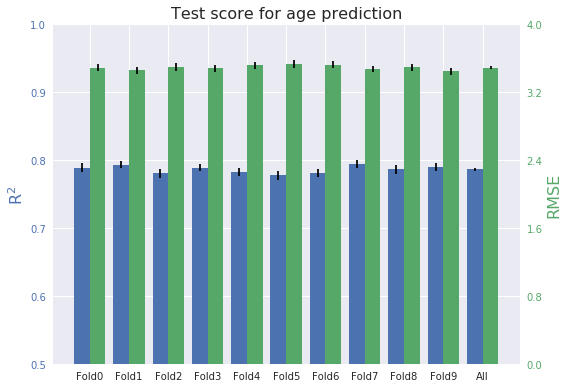

In [6]:
# Plot score per fold
fig, ax1 = plt.subplots()
width= 0.4
x_ticks = np.array(list(range(0,len(df_err))))# + [10.5])
color = sns.color_palette()[0]
ax1.bar(height= df_scores['R2'], x= x_ticks-width/2, 
        yerr= df_err['R2'], width= width,
        color=color)
ax1.set_ylabel('R$^2$' , color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0.5,1])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = sns.color_palette()[1]
ax2.bar(height= df_scores['RMSE'], x= x_ticks+width/2, 
        yerr= df_err['RMSE'], width= width,
        color=color)
ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,4])
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
ax2.grid(None)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(df_scores.index)
ax2.set_xlabel('Folds')
ax2.set_title('Test score for age prediction')


fig.tight_layout()
fig.show()

### All predictions - Final output

In [27]:
df_all_scores = pd.DataFrame()
df_all_scores.loc[0,'view']='3chambers'
df_all_scores.loc[0,'architecture']='3D'
df_folds = pd.DataFrame()
for fold in range(10):
    df_all_scores.loc[0,'R-Squared_{}'.format(fold)] = df_scores_3.loc['Fold{}'.format(fold),'R2']
    df_all_scores.loc[0,'RMSE_{}'.format(fold)] = df_scores_3.loc['Fold{}'.format(fold),'RMSE']
    
    df_all_scores.loc[0,'R-Squared_sd_{}'.format(fold)] = df_err_3.loc['Fold{}'.format(fold),'R2']
    df_all_scores.loc[0,'RMSE_sd_{}'.format(fold)] = df_err_3.loc['Fold{}'.format(fold),'RMSE']
    df_tmp = pd.DataFrame(index=df_all.index, data={'outer_fold': fold})
    df_folds = pd.concat((df_folds, df_tmp), axis= 0 )

df_all_scores.loc[0,'R-Squared_all'] = df_scores_3.R2.mean()
df_all_scores.loc[0,'R-Squared_str_all'] = df_scores_3.loc['All','R2']

df_all_scores.loc[0,'RMSE_all'] = df_scores_3.RMSE.mean()
df_all_scores.loc[0,'RMSE_str_all'] = df_scores_3.loc['All','RMSE']

df_all_scores.loc[0,'R-Squared_folds_sd_all'] = df_scores_3.R2.std()
df_all_scores.loc[0,'R-Squared_sd_all'] = df_err_3.loc['All','R2']

df_all_scores.loc[0,'RMSE_folds_sd_all'] = df_scores_3.RMSE.std()
df_all_scores.loc[0,'RMSE_sd_all'] = df_err_3.loc['All','RMSE']

In [28]:
df_all_scores.loc[1,'view']='4chambers'
df_all_scores.loc[1,'architecture']='3D'
for fold in range(10):
    df_all_scores.loc[1,'R-Squared_{}'.format(fold)] = df_scores_4.loc['Fold{}'.format(fold),'R2']
    df_all_scores.loc[1,'RMSE_{}'.format(fold)] = df_scores_4.loc['Fold{}'.format(fold),'RMSE']
    
    df_all_scores.loc[1,'R-Squared_sd_{}'.format(fold)] = df_err_4.loc['Fold{}'.format(fold),'R2']
    df_all_scores.loc[1,'RMSE_sd_{}'.format(fold)] = df_err_4.loc['Fold{}'.format(fold),'RMSE']
    df_tmp = pd.DataFrame(index=df_all.index, data={'outer_fold': fold})
    df_folds = pd.concat((df_folds, df_tmp), axis= 0 )


df_all_scores.loc[1,'R-Squared_all'] = df_scores_4.R2.mean()
df_all_scores.loc[1,'R-Squared_str_all'] = df_scores_4.loc['All','R2']

df_all_scores.loc[1,'RMSE_all'] = df_scores_4.RMSE.mean()
df_all_scores.loc[1,'RMSE_str_all'] = df_scores_4.loc['All','RMSE']

df_all_scores.loc[1,'R-Squared_folds_sd_all'] = df_scores_4.R2.std()
df_all_scores.loc[1,'R-Squared_sd_all'] = df_err_4.loc['All','R2']

df_all_scores.loc[1,'RMSE_folds_sd_all'] = df_scores_4.RMSE.std()
df_all_scores.loc[1,'RMSE_sd_all'] = df_err_4.loc['All','RMSE']

#### Ensemble

In [13]:
df_all =pd.DataFrame()
for channel in [3,4]:
    directory = '/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/{}ch/'.format(channel)
    df_ch = retrieve_predictions(directory)
    df_ch.rename(columns={'Age_raw': 'Age{}'.format(channel)}, inplace= True)
    df_ch.rename(columns={'Pred': '{}ch'.format(channel)}, inplace= True)
    df_ch.set_index(('eid'), inplace=True)
    df_all= pd.concat((df_all, df_ch), axis=1)

df_all.rename(columns={'Age{}'.format(3): 'Age'}, inplace= True)
df_all.drop(columns='Age4', inplace=True)
df_all.dropna(inplace=True)

In [14]:
df_all['Mean'] = (df_all['3ch'] + df_all['4ch'])/2 #df_all[['4ch','3ch']].apply(lambda x: np.mean(x), axis= 1) 

print('R2 {}'.format(r2_score(df_all['Age'],df_all['Mean'])))
print('RMSE {}'.format(np.sqrt(mean_squared_error(df_all['Age'],df_all['Mean']))))

R2 0.8336877008310356
RMSE 3.1200874085968002


In [15]:
df_bootstrap_score = pd.DataFrame()
for n in tqdm(range(1000)):
    df_tmp = df_all[['Mean', 'Age']].sample(frac=1, replace= True)
    df_bootstrap_score.loc[n,'R2'] = r2_score(df_tmp['Age'], df_tmp['Mean'] )
    df_bootstrap_score.loc[n,'RMSE'] = np.sqrt(mean_squared_error(df_tmp['Age'], df_tmp['Mean'] ))

df_all_scores.loc[2,'R-Squared_all'] = r2_score(df_all['Age'],df_all['Mean'])
df_all_scores.loc[2,'R-Squared_str_all'] = df_bootstrap_score.R2.mean()
df_all_scores.loc[2,'R-Squared_sd_all'] = df_bootstrap_score.R2.std()


df_all_scores.loc[2,'RMSE_all'] = np.sqrt(mean_squared_error(df_all['Age'],df_all['Mean']))
df_all_scores.loc[2,'RMSE_str_all'] = df_bootstrap_score.RMSE.mean()
df_all_scores.loc[2,'RMSE_sd_all'] = df_bootstrap_score.R2.std()


print('R2 {} ± {}'.format(df_bootstrap_score.R2.mean(),df_bootstrap_score.R2.std() ))
print('RMSE {} ± {}'.format(df_bootstrap_score.RMSE.mean(), df_bootstrap_score.RMSE.std()))

100%|██████████| 1000/1000 [00:06<00:00, 164.49it/s]

R2 0.8336788624845719 ± 0.0013599288167782195
RMSE 3.1203101563559867 ± 0.010936747461141838


In [17]:
df_all_scores.loc[2,'view']='*'
df_all_scores.loc[2,'architecture']='3D *'

for fold in tqdm(range(10)):
    csv_dir = '/n/groups/patel/Alan/Aging/Medical_Images/data2/data-features_Heart_20208_Age_{}_{}.csv'
    partition, _ = get_data_fold(fold, csv_dir, target = 'Age_raw')
    partition = partition['test']
    df_tmp = df_all.loc[partition]
    df_tmp.dropna(inplace=True)
    
    df_all_scores.loc[2,'R-Squared_{}'.format(fold)] = r2_score(df_tmp.Age, df_tmp.Mean)
    df_all_scores.loc[2,'RMSE_{}'.format(fold)] = np.sqrt(mean_squared_error(df_tmp.Age, df_tmp.Mean))

    df_bootstrap_score = pd.DataFrame()

    for n in range(1000):
        df_tmp_2 = df_tmp[['Mean', 'Age']].sample(frac=1, replace= True)
        df_bootstrap_score.loc[n,'R2'] = r2_score(df_tmp_2['Age'], df_tmp_2['Mean'] )
        df_bootstrap_score.loc[n,'RMSE'] = np.sqrt(mean_squared_error(df_tmp_2['Age'], df_tmp_2['Mean'] ))

    df_all_scores.loc[2,'R-Squared_sd_{}'.format(fold)] = df_bootstrap_score.R2.std()
    df_all_scores.loc[2,'RMSE_sd_{}'.format(fold)] = df_bootstrap_score.RMSE.std()

df_all_scores.loc[2,'R-Squared_folds_sd_all'] = df_all_scores.loc[2, ['R-Squared_{}'.format(fold) for fold in range(10)]].std()
df_all_scores.loc[2,'RMSE_folds_sd_all'] = df_all_scores.loc[2,['RMSE_{}'.format(fold) for fold in range(10)]].std()

100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


In [18]:
print(df_all_scores.loc[2, ['R-Squared_{}'.format(fold) for fold in range(10)]].std())
print(df_all_scores.loc[2, ['RMSE_{}'.format(fold) for fold in range(10)]].std())

0.003883095667788333
0.030280202339322465


In [19]:
df_all_scores

view architecture  R-Squared_0    RMSE_0  R-Squared_sd_0  RMSE_sd_0  \
0  3chambers           3D     0.814006  3.305213        0.004887   0.036502   
1  4chambers           3D     0.789365  3.517262        0.006008   0.040696   
2          *         3D *     0.834396  3.089857        0.004771   0.036772   

   R-Squared_1    RMSE_1  R-Squared_sd_1  RMSE_sd_1  ...  R-Squared_sd_9  \
0     0.809633  3.364882        0.004914   0.037135  ...        0.005294   
1     0.792692  3.514056        0.005215   0.037749  ...        0.005528   
2     0.836335  3.074491        0.004417   0.034551  ...        0.004605   

   RMSE_sd_9  R-Squared_all  R-Squared_str_all  RMSE_all  RMSE_str_all  \
0   0.037566       0.807830           0.807926  3.352591      3.353355   
1   0.037133       0.789574           0.789738  3.509939      3.510151   
2   0.035811       0.833688           0.833679  3.120087      3.120310   

   R-Squared_folds_sd_all  R-Squared_sd_all  RMSE_folds_sd_all  RMSE_sd_all  
0                0.004779          0.001541           0.043556     0.011643  
1                0.003750          0.001779           0.023277     0.012762  
2                0.003883          0.001360           0.030280     0.001360  

[3 rows x 50 columns]

In [20]:
df_all_scores['transformation']='raw'
df_all_scores['organ']='Heart'

df_all_scores.to_csv('/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/PERFORMANCES_Age_test.csv')

<Figure size 1296x720 with 0 Axes>

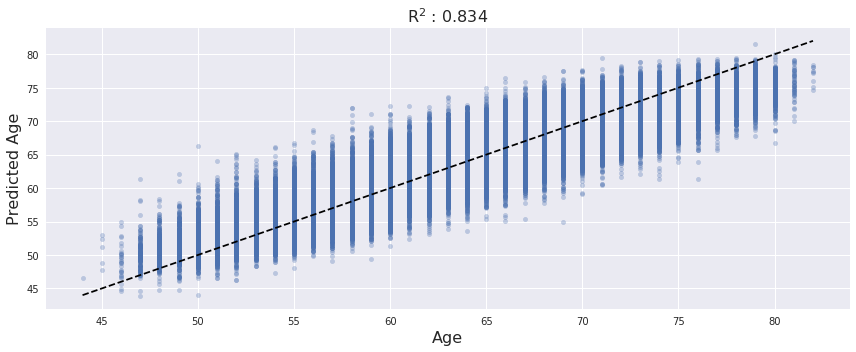

In [21]:
plt.figure(figsize=(18,10))
df_all[['Age','Mean']].plot.scatter(x='Age', y='Mean', alpha=0.3, figsize=(12,5) )
plt.xlabel('Age')
plt.ylabel('Predicted Age')
plt.title('R$^2$ : {}'.format(np.round(r2_score(df_all.Age, df_all.Mean), 3)))
plt.plot([44, 82],[44, 82], 'k--')
plt.tight_layout()
plt.show()

In [22]:
df_all_scores

view architecture  R-Squared_0    RMSE_0  R-Squared_sd_0  RMSE_sd_0  \
0  3chambers           3D     0.814006  3.305213        0.004887   0.036502   
1  4chambers           3D     0.789365  3.517262        0.006008   0.040696   
2          *         3D *     0.834396  3.089857        0.004771   0.036772   

   R-Squared_1    RMSE_1  R-Squared_sd_1  RMSE_sd_1  ...  R-Squared_all  \
0     0.809633  3.364882        0.004914   0.037135  ...       0.807830   
1     0.792692  3.514056        0.005215   0.037749  ...       0.789574   
2     0.836335  3.074491        0.004417   0.034551  ...       0.833688   

   R-Squared_str_all  RMSE_all  RMSE_str_all  R-Squared_folds_sd_all  \
0           0.807926  3.352591      3.353355                0.004779   
1           0.789738  3.509939      3.510151                0.003750   
2           0.833679  3.120087      3.120310                0.003883   

   R-Squared_sd_all  RMSE_folds_sd_all  RMSE_sd_all  transformation  organ  
0          0.001541           0.043556     0.011643             raw  Heart  
1          0.001779           0.023277     0.012762             raw  Heart  
2          0.001360           0.030280     0.001360             raw  Heart  

[3 rows x 52 columns]

### Comparison between 2D and 3D models

In [23]:
import plotly.graph_objects as go

dir_alan = '/n/groups/patel/Alan/Aging/Medical_Images/'
fold = 'test'
Performances = pd.read_csv(dir_alan + 'data2/PERFORMANCES_withEnsembles_ranked_Age_' + fold + '.csv')
df = Performances[['organ', 'view', 'architecture', 'transformation', 'R-Squared_all']]
df_organ = df[(df['organ'] == 'Heart') & (~df['architecture'].isin([',', '?']))]
df_organ = df_organ.append(df_all_scores.loc[0, ['organ','view','architecture','transformation','R-Squared_all']])
df_organ = df_organ.append(df_all_scores.loc[1, ['organ','view','architecture','transformation','R-Squared_all']])

#Load 3D models perf
df_all_scores= pd.read_csv('/n/groups/patel/JbProst/Heart/Scripts/CrossVal/Age/PERFORMANCES_Age_test.csv')
df_all_scores.loc[2, 'architecture'] = '3D *'
df_organ = df_organ.append(df_all_scores.loc[2, ['organ','view','architecture','transformation','R-Squared_all']])

# Specify 2D ensemble model
df_organ.at[(df_organ.architecture=='*') & (df_organ.view=='*'), 'architecture'] = '2D *'
df_organ.at[(df_organ['architecture']=='*') & (df_organ['view']!='*'), 'architecture'] = '2D *'
display(df_organ[(df_organ.architecture=='*') & (df_organ.view!='*')])
#df_organ= df_organ.drop(5)

transformations = df_organ['transformation'].unique()
Ys = {}
for transformation in transformations:
    Ys[transformation] = []
level_1 = []
level_2 = []
views = df_organ['view'].unique()
views.sort()
for view in views: #level 1
    df_view = df_organ[df_organ['view'] == view]
    architectures = df_view['architecture'].unique()
    architectures.sort()
    for architecture in architectures: #level 2
        df_architecture = df_view[df_view['architecture'] == architecture]

        level_1.append(view)
        level_2.append(architecture)
        for transformation in transformations:
            try:
                Ys[transformation].append(df_architecture['R-Squared_all'][df_architecture['transformation'] == transformation].values[0])
            except:
                Ys[transformation].append(0)

# add spacing to the view level labels
level_1 =['*', '*'] + [v[0]+' '+v[1:] for v in level_1 if v !='*' ] 
x = [level_1, level_2]

fig = go.Figure()
for i, transformation in enumerate(transformations):
    fig.add_bar(x=x, y=Ys[transformation], 
                name=transformation.capitalize(),
               marker_color= 'rgb{}'.format(str(sns.color_palette()[i])))

fig.update_layout(legend_orientation="h")
fig.update_layout(legend=dict(x=0.78, y=1.01, bgcolor='rgba(0,0,0,0)'))
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), 
                  yaxis_title= r"$\text{R}^2$",
                  font=dict(size=16),
                 width=1200,
                height=600)

fig.update_yaxes(automargin=True)




fig.show()

Empty DataFrame
Columns: [organ, view, architecture, transformation, R-Squared_all]
Index: []

In [260]:
def plot_RMSE(pred, truth, R2, rmse, title, fill=False):
    TICKS = 10
    LEGEND = 12
    AXES = 16
    TITLE = 18
    plt.style.use('seaborn-notebook')
    plt.rc('font', size=TICKS)          # controls default text sizes
    plt.rc('axes', titlesize=AXES)     # fontsize of the axes title
    plt.rc('axes', labelsize=AXES)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=TICKS)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=TICKS)    # fontsize of the tick labels
    plt.rc('legend', fontsize=LEGEND)    # legend fontsize
    plt.rc('figure', titlesize=TITLE)  # fontsize of the figure title
    lin = linear_model.LinearRegression()
    lin.fit(pred.reshape(-1, 1), truth)

    
    df = pd.DataFrame({'Truth': truth, 'Pred': pred})
    df.index= np.int32(df.index)
    
    df_plot= pd.DataFrame()
    for age in df.Truth.unique():
        err = df[df['Truth']==age].apply(lambda x: np.power((x[0]-x[1]),2), axis=1)
        df_plot.loc[int(age),'Pred'] = df[df['Truth']==age].Pred.mean()
        df_plot.loc[int(age),'Mean'] = np.sqrt(err.mean())
    df_plot.fillna(0,inplace=True)
    
    fig, ax1= plt.subplots(1,1,figsize = (12,5))    
    a=0
    ax1.plot([truth.min()-a, truth.max()+a], [truth.min()-a, truth.max()+a], '--k')#, label='Perfect Prediction')
    df_plot.sort_index(inplace=True)
    if fill:
        ax1.fill_between(df_plot.index,  df_plot.index+df_plot.Mean, df_plot.index - df_plot.Mean, 
                        alpha= 0.4, label ='RMSE', color=sns.color_palette()[1])
    ax1.scatter(truth,pred, alpha = 0.3, color=sns.color_palette()[0])

    
    ax1.legend(loc='upper left')
    ax1.set_title(title)
    ax1.set_xlabel('Age')
    ax1.set_ylabel('Predicted Age')
    fig.tight_layout()
    fig.show()

# Age difference seconde and third instance

In [18]:
# load predictions
path = '/n/groups/patel/Alan/Aging/Medical_Images/data_predictions_videos/'
file_name = 'Predictions_instances_Age_Heart_MRI_34chambersRawVideo_3DCNN_2_1024_Adam_0.0001_0.0_0.2_1.0_test.csv'
df_predictions = pd.read_csv(path + file_name, index_col = 'id')

In [19]:
df_predictions.dropna(inplace= True)
df_predictions.head()

pred  outer_fold
id                              
1000046_2  54.276139           0
1000304_2  68.124710           0
1001465_2  66.504378           0
1002268_2  66.337570           0
1002569_2  54.344504           0

In [20]:
df_predictions.reset_index(inplace=True)
df_predictions.dropna(inplace= True)
df_predictions['instance'] = df_predictions.id.apply(lambda x : int(str(x)[-1]))
df_predictions['eid'] = df_predictions.id.apply(lambda x : int(str(x)[:-2]))
df_predictions.drop(columns=['id', 'outer_fold'], inplace=True)
df_predictions.set_index('eid', inplace=True)

In [21]:
df_predictions.head()

pred  instance
eid                         
1000046  54.276139         2
1000304  68.124710         2
1001465  66.504378         2
1002268  66.337570         2
1002569  54.344504         2

In [45]:
df_2 = df_predictions[df_predictions.instance ==2].drop(columns = ['instance'])
df_3 = df_predictions[df_predictions.instance ==3].drop(columns = ['instance'])
df_diff = df_3.join(df_2, lsuffix='_3', rsuffix='_2')
df_diff['Predicted_Difference'] = df_diff.pred_3 - df_diff.pred_2
age_interval = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/Age_difference_instance_2_3.p', 'rb'))
df_diff['Age_Difference'] = age_interval
df_diff['Age_Difference_Error'] = df_diff['Age_Difference'] - df_diff['Predicted_Difference']

df_diff.head()

pred_3     pred_2  Predicted_Difference  Age_Difference  \
eid                                                                   
1009386  70.848252  67.989190              2.859062        2.283368   
1018575  67.032250  67.000770              0.031480        2.184805   
1028323  54.065799  51.221380              2.844419        2.198494   
1080716  74.179725  73.554258              0.625467        2.286105   
1108594  66.131965  61.152822              4.979143        2.121834   

         Age_Difference_Error  
eid                            
1009386             -0.575694  
1018575              2.153325  
1028323             -0.645925  
1080716              1.660638  
1108594             -2.857308

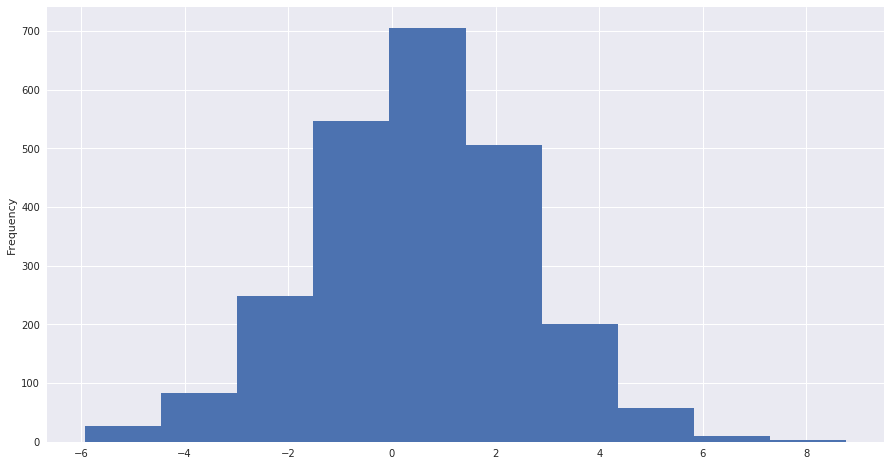

In [47]:
f, ax = plt.subplots(figsize=(15,8))
df_diff.Age_Difference_Error.plot.hist(ax =ax)
plt.show()

# Mispredictions exploration

#### Load Data

In [255]:
fold_ ='test'
preds_all = pickle.load(open('{}Pred.p'.format(fold_), 'rb'))

### Correction

In [256]:
mean_diff_val = preds_all.groupby('Age').mean() - np.sort(preds_all.Age.unique()).reshape(-1,1)

In [257]:
preds_corrected= pd.DataFrame()
for age in tqdm(preds_all.Age.unique()):
    preds_corrected = pd.concat((preds_corrected,preds_all[preds_all.Age==age][['Mean']] - mean_diff_val.loc[age]), axis=0)
preds_corrected= preds_corrected.join(preds_all.Age, how='left')


100%|██████████| 39/39 [00:00<00:00, 111.97it/s]


In [258]:
#preds_corrected['Mean'] = preds_corrected['Pred']
R2_corr = r2_score(preds_corrected.Age.copy(),preds_corrected.Mean.copy()) 
RMSE_corr = np.sqrt(mean_squared_error(preds_corrected.Age.copy(),preds_corrected.Mean.copy()))
print('R2 corrected : ', R2_corr)
print('RMSE corrected : ', RMSE_corr)

R2 corrected :  0.8649608776459302
RMSE corrected :  2.7780818582012934


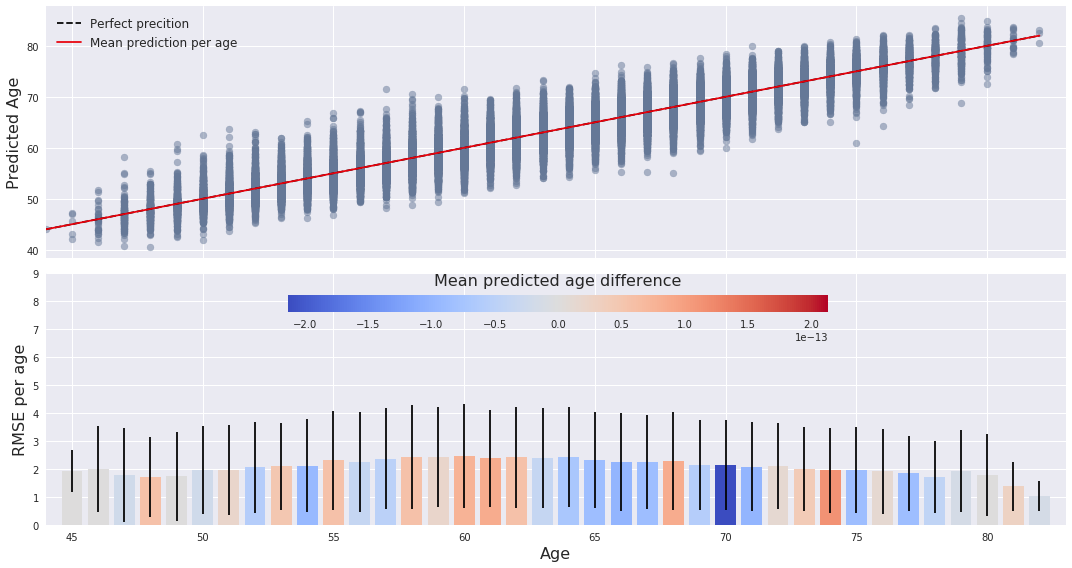

In [272]:
plot_linear_reg(preds_corrected.Mean.to_numpy().copy(), preds_corrected.Age.copy())

In [259]:
preds_corrected['Residual'] = preds_corrected[['Age', 'Mean']].apply(lambda row: row[0]-row[1], axis=1)

## CVDs

### ALL

In [251]:
def plot_CVD_residuals(cvds, percent = 1, acc_agers = True, min_prevalence = 32):
    """
    cvds : all patient dataframe. True in the column of CVDs or Nan.
    """
    # --- Definies the group ---
    if percent !=1:
        if acc_ager:
            cvds = cvds.sort_values('Residual', ascending=True).\
                    iloc[:int(percent*cvds.shape[0])]
        else:
            cvds = cvds.sort_values('Residual', ascending=Falsee).\
                    iloc[:int(percent*cvds.shape[0])]
    else:
        pass
    
    # --- number of patient or each cvds ---
    counts= cvds.count()
    counts = counts[counts>min_prevalence]
    cvds = cvds[counts.index]
    counts= counts.drop('Residual')
    counts.sort_index(inplace=True, ascending=False)
    index_order = counts.index.tolist() 
    
    # --- Residuals associated with each patient suffering from a certain CVD  ---
    
    df_cvds_res =pd.DataFrame()
    for pathology in cvds.drop(columns=['Residual']).columns:
        tmp = cvds[cvds[pathology]==True]['Residual']
        not_tmp = cvds.loc[~cvds.index.isin(tmp.index), 'Residual']
        if tmp.count()>min_prevalence :
            _, p_val = ttest_ind(tmp, not_tmp, axis=0)
            df_cvds_res.loc[pathology,'P-value'] = p_val
        
    #all cvds:
    label = 'CVDs'
    cvds.insert(cvds.shape[1]-1, label, cvds.apply(lambda x : x[:-1].any(), axis=1))
    index_order = index_order + [label]
    cvds.replace(inplace=True, to_replace= False,value=np.nan)
    tmp = cvds[cvds[label]==True]['Residual']
    tmp.dropna(inplace=True)
    not_tmp = cvds.loc[~cvds.index.isin(tmp.index), 'Residual']
    not_tmp.dropna(inplace=True)
    _, p_val = ttest_ind(tmp, not_tmp, axis=0)
    df_cvds_res.loc[label,'P-value'] = p_val
    counts.loc[label] = counts.sum()
    

    # Adjust and transform p value
    adj_TypeI_err =  0.05 / len(df_cvds_res['P-value'])
    df_cvds_res['P-value'] = -np.log10(df_cvds_res['P-value'])
    
    # --- plotting ---
    boxprops = dict(linestyle='-', linewidth=1.3)
    meanpointprops = dict(marker ='o',
                          markeredgecolor='r', markerfacecolor='firebrick', markersize=7)
    color=dict(boxes='k', whiskers='k', medians='r', caps='k')
    plt.rc('ytick', labelsize=12) 
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,10), sharey=True)
    df_cvds_res = df_cvds_res.loc[index_order]
    ax1.barh(width =df_cvds_res['P-value'], y= range(1,df_cvds_res.shape[0]+1))
    ax1.plot([-np.log10(adj_TypeI_err), -np.log10(adj_TypeI_err)], [0, df_cvds_res.shape[0]+1], 'r--', label= 'Adjusted 5% significance')
    ax1.set_ylabel('Cardiovascualr diseases')
    ax1.set_xlabel('Type I error [-log$_{10}$]')
    ax1.set_yticklabels(df_cvds_res.index)
    ax1.set_yticks(range(1,df_cvds_res.shape[0]+1))
    for i in range(len(counts)):
        ax1.text(0.1, i+1, 'n = {}'.format(counts[i])
                 ,verticalalignment='center')
    
    #bold for significant
    df_cvds_res = df_cvds_res.loc[index_order]
    
    tmp = df_cvds_res.reset_index()
    index_signif = tmp[tmp['P-value'] >= -np.log10(adj_TypeI_err)].index.tolist()
    for bold in index_signif:
        ax1.get_yticklabels()[bold].set_weight("bold")
    ax1.set_title('Cardiovascular disease mean impact')
    ax1.set_xscale('log')

    # Age distribution
    cvds_distrib = cvds.drop(columns=['Residual'])
    cvds_distrib = cvds_distrib.join(preds_corrected.Age)
    cvds_distrib = cvds_distrib.apply(lambda row: row[:-1]*row[-1], axis=1)

    #scatter
    df_scatter= pd.DataFrame(columns= ['X','Y'], dtype='object')
    df_scatter = df_scatter.astype('object')
    for i, col_name in enumerate(index_order):
        vals_tmp = cvds_distrib[col_name].dropna().tolist()
        df_scatter.loc[col_name,'X'] = vals_tmp
        df_scatter.loc[col_name,'Y'] = np.random.normal(i+1, 0.04,len(vals_tmp))

    colors = np.array(sns.color_palette()[0]).reshape(1,3)
    for name in df_scatter.index :
        ax2.scatter(df_scatter.loc[name,'X'], df_scatter.loc[name,'Y'], 
                    c=colors, alpha=0.3, s=8, label= name)
    #boxplot
    cvds_distrib.plot.box(vert=False, ax= ax2, boxprops=boxprops, showfliers=False, 
                      medianprops=boxprops,
                      showmeans=True, meanline=False, meanprops = meanpointprops,
                      color= color) 

    cvds_distrib.plot.box(vert=False, ax= ax2, boxprops=boxprops, showfliers=False, 
                      medianprops=boxprops,
                      showmeans=True, meanline=False, meanprops = meanpointprops,
                      color= color)

    ax2.set_title('Age distribution')
    ax2.set_xlabel('Age')

    # --- residuals
    cvds_res = cvds.apply(lambda row: row[:-1]*row[-1], axis=1)
    
    ax3.plot([0,0], [0, cvds.shape[1]], 'k--', linewidth=0.5)
    #scatter
    names, vals, ys = [], [] ,[]
    for i, col_name in enumerate(index_order):
        names.append(col_name)
        vals_tmp = cvds_res[col_name].dropna().tolist()
        vals.append(vals_tmp)
        ys.append(np.random.normal(i+1, 0.04,len(vals_tmp)))

    colors = np.array(sns.color_palette()[0]).reshape(1,3)
    for y, val in zip(ys, vals):
        ax3.scatter(val, y, c=colors, alpha=0.3, s=8)
    #boxplot
    cvds_res.columns = index_order
    cvds_res.plot.box(vert=False, ax= ax3,  boxprops=boxprops, showfliers=False, 
                      medianprops=boxprops,
                      showmeans=True, meanline=False, meanprops = meanpointprops,
                      color= color)
    
    ax3.set_ylim([0, cvds.shape[1]])
    ax3.set_title('Residuals distribution')
    ax3.set_xlabel('Residuals')

    fig.tight_layout()
    fig.show()
    
def get_prevalences(cvds, percent, min_prevalence = 32):
        
    counts= cvds.count()
    counts = counts[counts>min_prevalence]
    cvds = cvds[counts.index]
    
    n_obs = int(percent*cvds.shape[0])
    acc_agers = cvds.sort_values('Residual', ascending=True).iloc[:int(percent*cvds.shape[0])]
    slow_agers = cvds.sort_values('Residual', ascending=False).iloc[:int(percent*cvds.shape[0])]

    #best predicted --> closer to their chronological age
    top_predicted = cvds.copy() 
    top_predicted['Abs Residual'] = abs(top_predicted['Residual'])
    top_predicted= top_predicted.sort_values('Abs Residual', ascending=True).iloc[:int(percent*cvds.shape[0])]

    #control group : all patient that are not in the top extrem miss-predicted
    control = cvds.loc[~cvds.index.isin(acc_agers.index)]
    control = control.loc[~control.index.isin(slow_agers.index)]
    
    prev_acc = acc_agers.drop(columns=['Residual']).count()
    prev_slow = slow_agers.drop(columns=['Residual']).count()
    prev_top = top_predicted.drop(columns=['Residual', 'Abs Residual']).count()
    prev_control = control.drop(columns=['Residual']).count()
    
    prevalences = pd.DataFrame({'Accelerated Agers' : prev_acc, 
                            'Slow Agers' : prev_slow,
                            'Best Predicted' : prev_top,
                            'Control' : prev_control})
    prevalences.sort_index(axis=0 ,inplace=True, ascending=False)
    prevalences.loc['CVD',:] = prevalences.sum()
    
    prevalences_pval = prevalences.copy()
    for cvd in prevalences.index:
        for group in prevalences.columns[:-1]:
            _, p_val = proportions_ztest([prevalences.loc[cvd,group],prevalences.loc[cvd,'Control']],
                                         [n_obs, len(control)])
            prevalences_pval.loc[cvd, group] = -np.log10(p_val)
            
    prevalences = prevalences/[n_obs, n_obs,n_obs, len(control)]
    prevalences_pval['Control'] = 0
    
    return prevalences, prevalences_pval

def volcano_plot_CVD_residuals(cvds, percent = 1, acc_agers = True, min_prevalence = 32):
    """
    cvds : all patient dataframe. True in the column of CVDs or Nan.
    """
    # --- Definies the group ---
    if percent !=1:
        if acc_ager:
            cvds = cvds.sort_values('Residual', ascending=True).\
                    iloc[:int(percent*cvds.shape[0])]
        else:
            cvds = cvds.sort_values('Residual', ascending=Falsee).\
                    iloc[:int(percent*cvds.shape[0])]
    else:
        pass
    
    # --- number of patient or each cvds ---
    counts= cvds.count()
    counts = counts[counts>min_prevalence]
    cvds = cvds[counts.index]
    counts= counts.drop('Residual')
    counts.sort_index(inplace=True, ascending=False)
    index_order = counts.index.tolist() 
    
    # --- Residuals associated with each patient suffering from a certain CVD  ---
    
    df_cvds_res =pd.DataFrame()
    for pathology in cvds.drop(columns=['Residual']).columns:
        tmp = cvds[cvds[pathology]==True]['Residual']
        tmp.dropna(inplace=True)
        not_tmp = cvds.loc[~cvds.index.isin(tmp.index), 'Residual']
        not_tmp.dropna(inplace=True)

        if tmp.count()>min_prevalence :
            _, p_val = ttest_ind(tmp, not_tmp, axis=0)
            df_cvds_res.loc[pathology,'P-value'] = p_val
            df_cvds_res.loc[pathology,'Fold_change'] =  tmp.mean() - not_tmp.mean()
        
    #all cvds:
    label = 'CVDs'
    cvds.insert(cvds.shape[1]-1, label, cvds.apply(lambda x : x[:-1].any(), axis=1))
    index_order = index_order + [label]
    cvds.replace(inplace=True, to_replace= False,value=np.nan)
    tmp = cvds[cvds[label]==True]['Residual']
    tmp.dropna(inplace=True)
    not_tmp = cvds.loc[~cvds.index.isin(tmp.index), 'Residual']
    not_tmp.dropna(inplace=True)
    _, p_val = ttest_ind(tmp, not_tmp, axis=0)
    df_cvds_res.loc[label,'P-value'] = p_val
    df_cvds_res.loc[label,'Fold_change'] = tmp.mean() - not_tmp.mean()
    counts.loc[label] = counts.sum()
    

    # Adjust and transform p value
    adj_TypeI_err =  0.05 / len(df_cvds_res['P-value'])
    df_cvds_res['P-value'] = -np.log10(df_cvds_res['P-value'])

    # --- plotting ---
    plt.rc('ytick', labelsize=12) 
    fig, ax1 = plt.subplots(1,1,figsize=(20,8))
    df_cvds_res = df_cvds_res.loc[index_order]
    ax1.scatter(df_cvds_res['Fold_change'], df_cvds_res['P-value'])
    ax1.plot([-np.max(abs(df_cvds_res['Fold_change'])), np.max(abs(df_cvds_res['Fold_change']))],
             [-np.log10(adj_TypeI_err), -np.log10(adj_TypeI_err)],
              'r--', label= 'Adjusted 5% significance')
    ax1.set_yscale('log')
    #ax1.set_xlim([-np.max(abs(df_cvds_res['Fold_change'])), np.max(abs(df_cvds_res['Fold_change']))])
    ax1.set_ylabel('-log(P value)')
    ax1.set_xlabel('Mean residual difference')

In [303]:
cvds =  pickle.load(open('/n/groups/patel/JbProst/Heart/Data/CVDs.p', 'rb'))
cvds = pd.concat((cvds,preds_corrected['Residual']), axis=1)
cvds.dropna(subset=['Residual'], inplace=True)

#### All patients

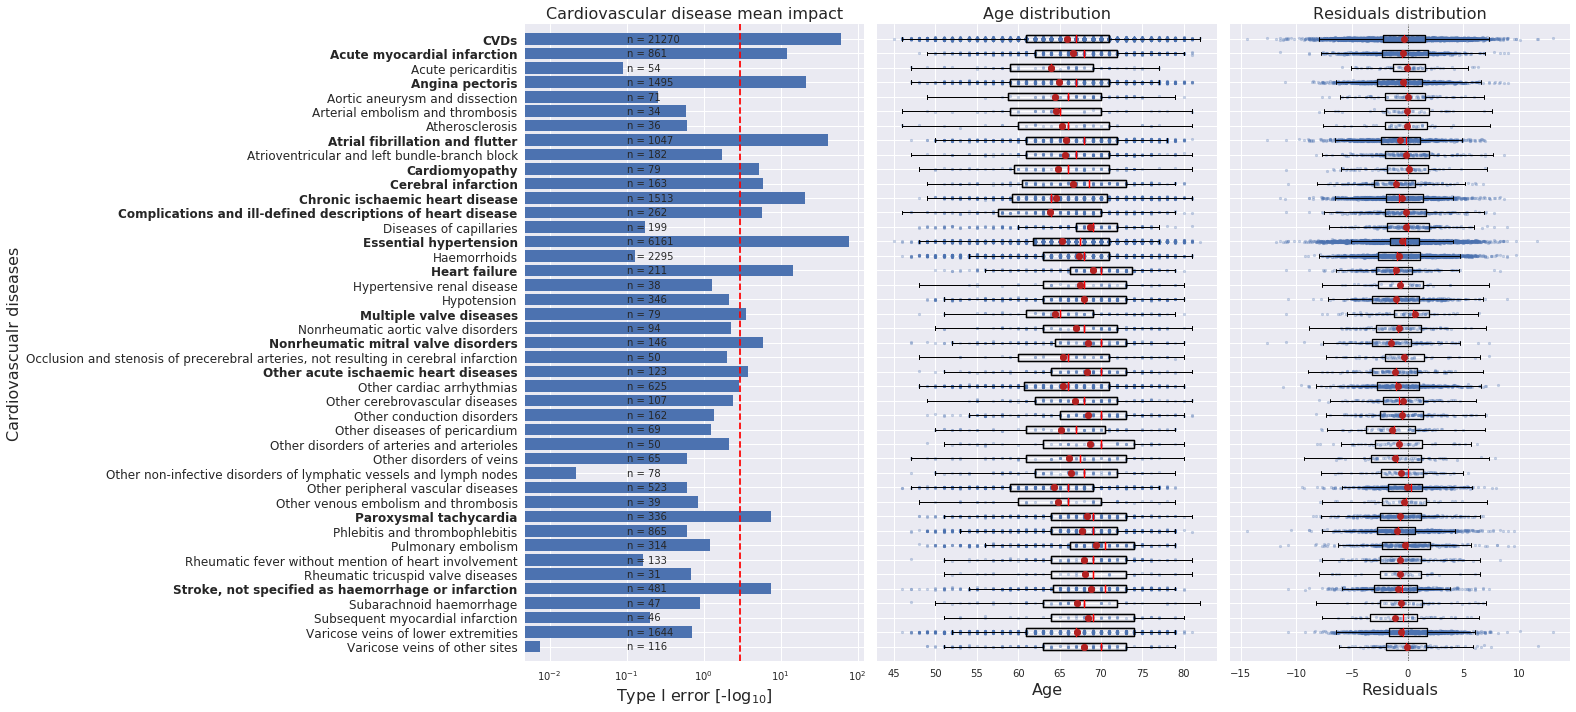

In [281]:
plot_CVD_residuals(cvds, percent = 1, acc_agers = True, min_prevalence = 30)

In [220]:
from adjustText import adjust_text # for plotting

def get_t_test_residuals(df_raw, percent = 1, acc_agers = True, min_prevalence = 32):
    
    if percent !=1:
        if acc_agers:
            df_raw = df_raw.sort_values('Residual', ascending=True).\
                    iloc[:int(percent*df_raw.shape[0])]
        else:
            df_raw = df_raw.sort_values('Residual', ascending=False).\
                    iloc[:int(percent*df_raw.shape[0])]
        
    # --- number of patient or each df_raw ---
    counts= df_raw.count()
    counts = counts[counts>min_prevalence]
    df_raw = df_raw[counts.index]
    counts= counts.drop('Residual')
    counts.sort_index(inplace=True, ascending=False)
    index_order = counts.index.tolist() 

    # --- Residuals associated with each patient suffering from a certain CVD  ---

    df_raw_res =pd.DataFrame()
    for pathology in df_raw.drop(columns=['Residual']).columns:
        tmp = df_raw[df_raw[pathology]==True]['Residual']
        tmp.dropna(inplace=True)
        not_tmp = df_raw.loc[~df_raw.index.isin(tmp.index), 'Residual']
        not_tmp.dropna(inplace=True)

        if tmp.count()>min_prevalence :
            _, p_val = ttest_ind(tmp, not_tmp, axis=0)
            df_raw_res.loc[pathology,'P-value'] = p_val
            df_raw_res.loc[pathology,'Fold_change'] =  tmp.mean() - not_tmp.mean()

    #all df_raw:
    label = 'CVDS'
    df_raw.insert(df_raw.shape[1]-1, label, df_raw.apply(lambda x : x[:-1].any(), axis=1))
    index_order = index_order + [label]
    df_raw.replace(inplace=True, to_replace= False, value=np.nan)
    tmp = df_raw[df_raw[label]==True]['Residual']
    tmp.dropna(inplace=True)
    not_tmp = df_raw.loc[~df_raw.index.isin(tmp.index), 'Residual']
    not_tmp.dropna(inplace=True)
    _, p_val = ttest_ind(tmp, not_tmp, axis=0)
    df_raw_res.loc[label,'P-value'] = p_val
    df_raw_res.loc[label,'Fold_change'] = tmp.mean() - not_tmp.mean()
    counts.loc[label] = counts.sum()


    # Adjust and transform p value
    adj_TypeI_err =  0.05 / len(df_raw_res['P-value'])
    df_raw_res['P-value'] = -np.log10(df_raw_res['P-value'])

    return df_raw_res, index_order, adj_TypeI_err

In [315]:
acc_agers, index_order, adj_TypeI_err = get_t_test_residuals(cvds, percent = 1, acc_agers = False, min_prevalence = 32)

In [316]:
acc_agers

P-value  Fold_change
Rheumatic fever without mention of heart involv...   0.163794    -0.097620
Multiple valve diseases                              3.551668    -1.136440
Essential hypertension                              76.594561    -0.716234
Hypertensive renal disease                           1.301100    -0.883753
Angina pectoris                                     21.581748    -0.711319
Acute myocardial infarction                         12.152854    -0.687078
Subsequent myocardial infarction                     0.199962    -0.196856
Other acute ischaemic heart diseases                 3.790286    -0.946238
Chronic ischaemic heart disease                     20.842485    -0.694521
Pulmonary embolism                                   1.193426    -0.291491
Acute pericarditis                                   0.088632    -0.088328
Other diseases of pericardium                        1.258127    -0.641819
Nonrheumatic mitral valve disorders                  5.902673    -1.116439
Nonrheumatic aortic valve disorders                  2.241586    -0.792543
Cardiomyopathy                                       5.177531    -1.409292
Atrioventricular and left bundle-branch block        1.724328    -0.484677
Other conduction disorders                           1.371521    -0.443679
Paroxysmal tachycardia                               7.533490    -0.843990
Atrial fibrillation and flutter                     41.490363    -1.183611
Other cardiac arrhythmias                            2.852112    -0.357732
Heart failure                                       14.486930    -1.510703
Complications and ill-defined descriptions of h...   5.716334    -0.819880
Subarachnoid haemorrhage                             0.891252     0.616415
Cerebral infarction                                  5.881253    -1.054713
Stroke, not specified as haemorrhage or infarction   7.516671    -0.705859
Occlusion and stenosis of precerebral arteries,...   1.982677    -1.007196
Other cerebrovascular diseases                       2.405005    -0.775404
Atherosclerosis                                      0.608910    -0.537312
Aortic aneurysm and dissection                       0.253857    -0.193633
Other peripheral vascular diseases                   0.613352    -0.142613
Arterial embolism and thrombosis                     0.581831    -0.534744
Other disorders of arteries and arterioles           2.156794    -1.060770
Diseases of capillaries                              0.175148     0.084651
Phlebitis and thrombophlebitis                       0.606923    -0.110534
Other venous embolism and thrombosis                 0.845788    -0.652516
Varicose veins of lower extremities                  0.709759    -0.090705
Haemorrhoids                                         0.127448    -0.019387
Varicose veins of other sites                        0.007541    -0.005574
Other disorders of veins                             0.607055    -0.399130
Other non-infective disorders of lymphatic vess...   0.021743    -0.019283
Hypotension                                          2.115343    -0.399994
CVDS                                                59.815077    -0.490273

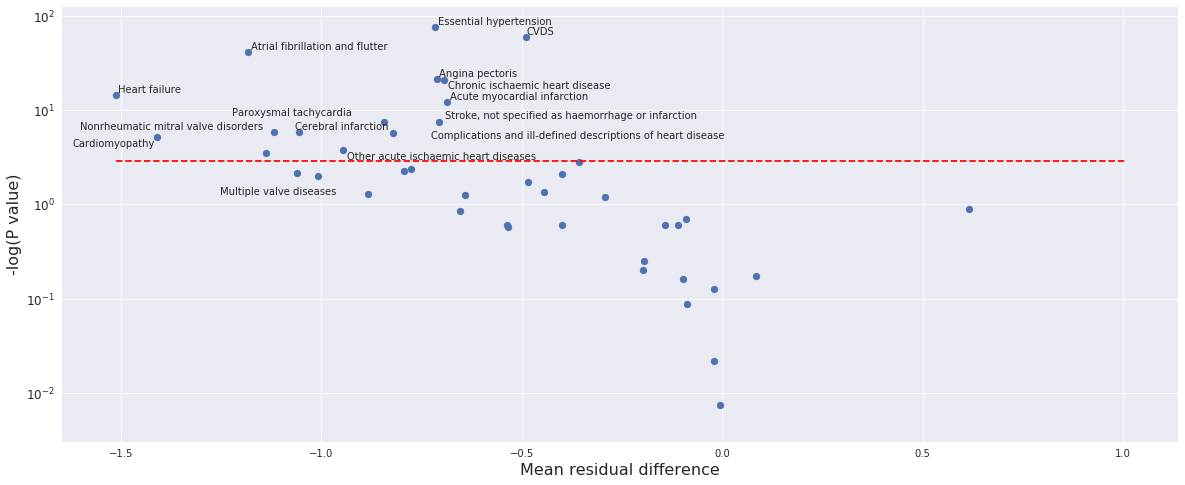

In [325]:
# --- plotting ---
plt.rc('ytick', labelsize=12) 
fig, ax1 = plt.subplots(1,1,figsize=(20,8))

# scatter plot
acc_agers = acc_agers.loc[index_order]
ax1.plot([-np.max(abs(acc_agers['Fold_change'])), np.max(abs(acc_agers['Fold_change']))-0.5],
         [signif_thresh, signif_thresh],
          'r--', label= 'Adjusted 5% significance')
ax1.scatter(acc_agers['Fold_change'], acc_agers['P-value'])

# significance level
signif_thresh = -np.log10(adj_TypeI_err)

texts =[]
for pathology in acc_agers.index:
    if acc_agers.loc[pathology,'P-value'] > signif_thresh:
        texts.append(ax1.annotate(pathology, 
                 (acc_agers.loc[pathology, 'Fold_change'], acc_agers.loc[pathology,'P-value'])))

adjust_text(texts, only_move={'points':'xy', 'text':'xy'})
    
ax1.set_yscale('log')
#ax1.set_xlim([-np.max(abs(acc_agers['Fold_change'])), np.max(abs(acc_agers['Fold_change']))])
ax1.set_ylabel('-log(P value)')
ax1.set_xlabel('Mean residual difference')
fig.show()

#### Accelerated agers -- irrelevant

In [71]:
percent =0.1
acc_agers = cvds.sort_values('Residual', ascending=True).iloc[:int(percent*cvds.shape[0])]

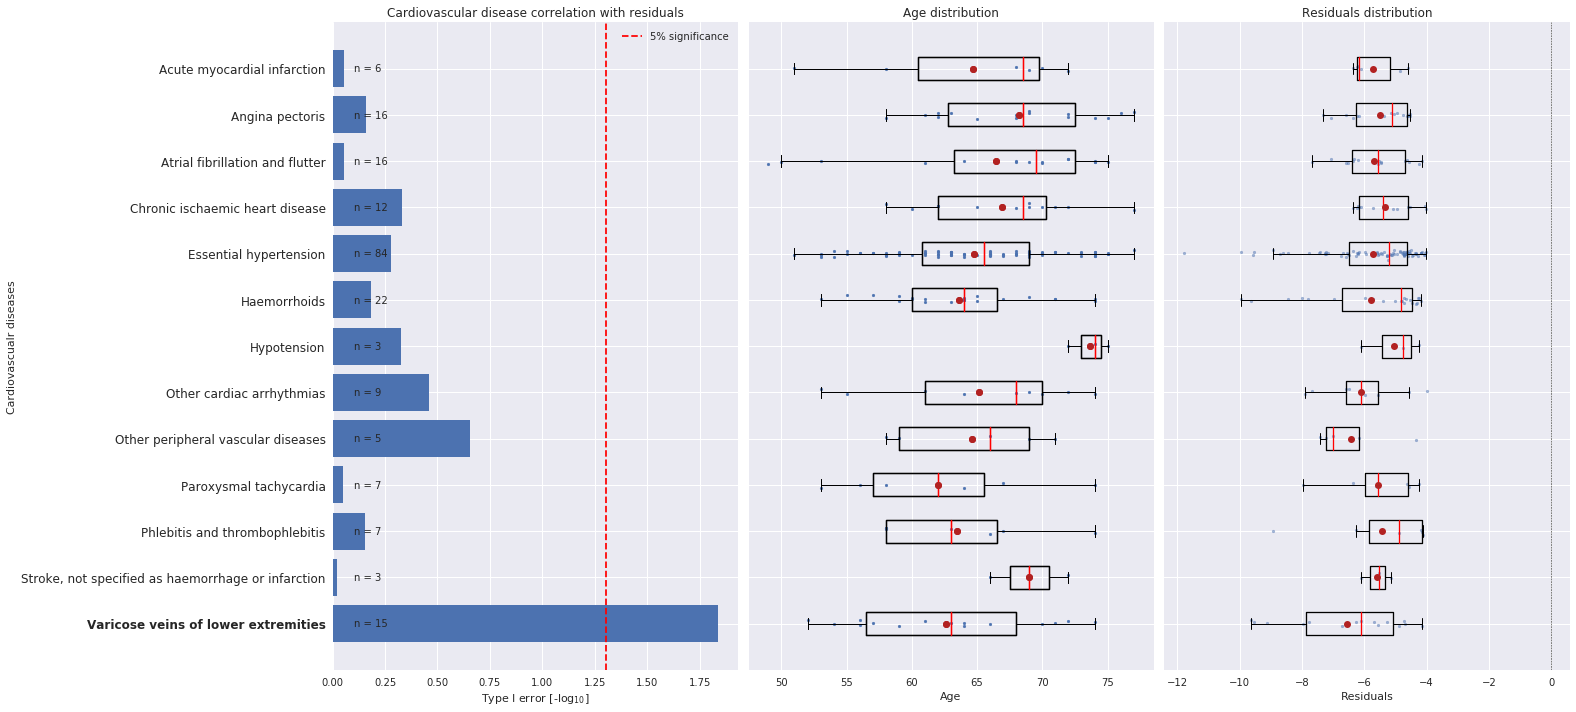

In [72]:
plot_CVD_residuals(acc_agers, percent = 1, acc_agers = True, min_prevalence = 1)

### Top X % of miss-classified

#### Old

In [18]:
cvds =  pickle.load(open('/n/groups/patel/JbProst/Heart/Data/CVDs.p', 'rb'))
cvds.dropna(how='all', inplace=True)

In [19]:
cvds = pd.concat((cvds,preds_corrected['Residual']), axis=1)
cvds.dropna(subset=['Residual'], inplace=True)

In [20]:
counts= cvds.count()
counts = counts[counts>32]
cvds = cvds[counts.index]

In [21]:
prevalance_cvds = cvds.count().drop('Residual')/cvds.count()['Residual']

In [22]:
percent = 0.1
#cvds['Abs Residual'] = abs(cvds.Residual)
#top_percent = cvds.sort_values('Abs Residual', ascending=False).iloc[:int(percent*cvds.shape[0])]
#top_percent= top_percent.drop(columns=('Abs Residual'))
top_percent = cvds.sort_values('Residual', ascending=True).iloc[:int(percent*cvds.shape[0])]

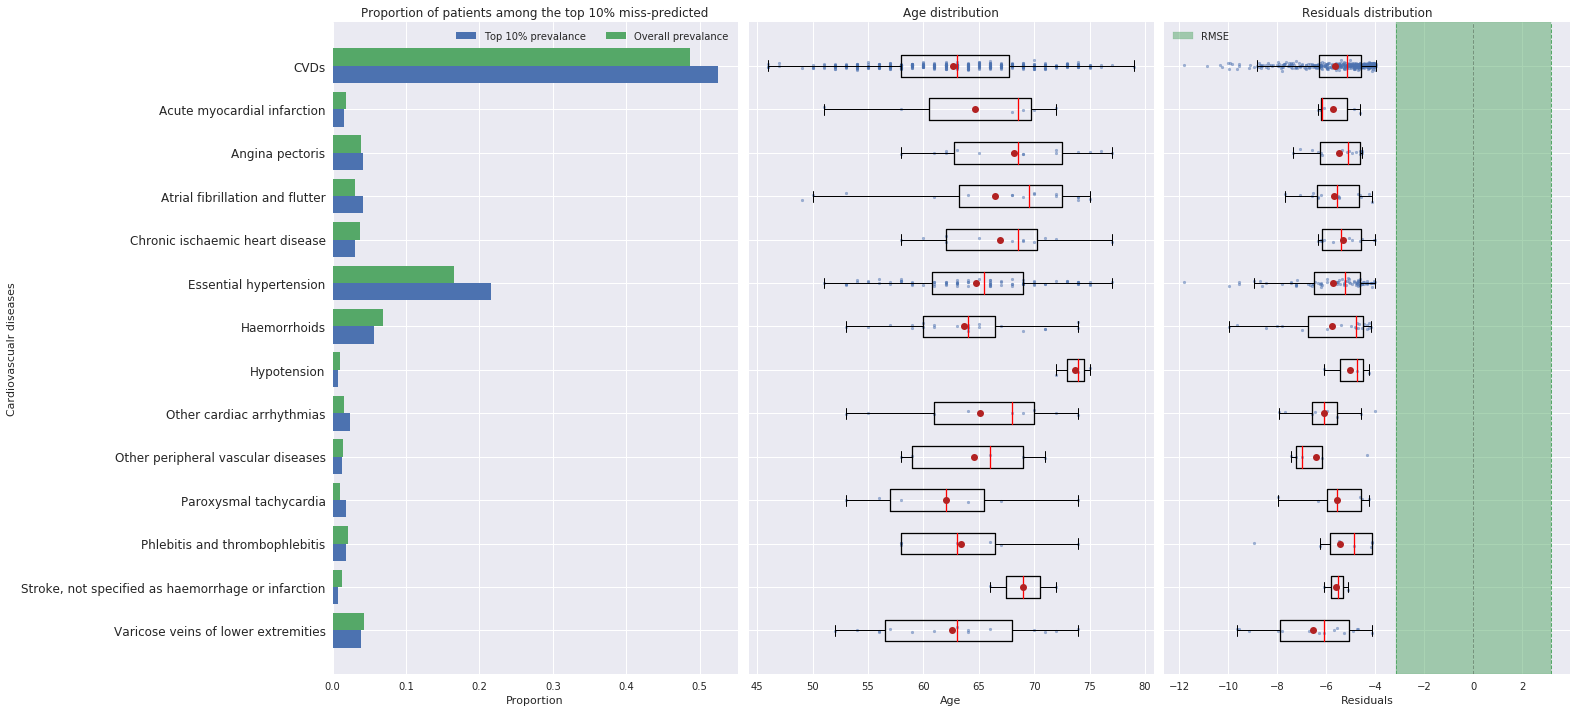

In [23]:
boxprops = dict(linestyle='-', linewidth=1.3)
meanpointprops = dict(marker ='o',
                      markeredgecolor='r', markerfacecolor='firebrick', markersize=7)#, linewidth=5)
medianprops= boxprops#dict(linestyle='-', linewidth=1.5),
color=dict(boxes='k', whiskers='k', medians='r', caps='k')

plt.rc('ytick', labelsize=12) 
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,10), sharey=True)

df_count = top_percent.count().drop('Residual')/top_percent.count()['Residual']
#prevalance_cvds = cvds.count().drop('Residual')/cvds.count()['Residual']
df_count.sort_index(inplace=True, ascending=False)
prevalance_cvds.sort_index(inplace=True, ascending=False)
w=0.2
ax1.barh(width= df_count.to_numpy(), y =np.array(range(1,df_count.shape[0]+1))-w,
         height=w*2,
         align='center')
ax1.barh(width= prevalance_cvds, y = np.array(range(1,df_count.shape[0]+1))+w,
         height=w*2,
        align='center')

ax1.barh(width= df_count.sum() , y = df_count.shape[0]+1-w ,
         height=w*2,
         color=sns.color_palette()[0],
         align='center', label='Top {}% prevalance'.format(int(percent*100)))
ax1.barh(width= prevalance_cvds.sum()  , y = prevalance_cvds.shape[0]+1+w,
         height=w*2,
         color=sns.color_palette()[1],
         align='center', label='Overall prevalance')
ax1.legend(ncol=2)
ax1.set_ylabel('Cardiovascualr diseases')
ax1.set_xlabel('Proportion')
ax1.set_yticks(range(1,df_count.shape[0]+2))
ax1.set_title('Proportion of patients among the top {}% miss-predicted'.format(int(100*percent)))

# Age distribution
cvds_distrib = top_percent.drop(columns=['Residual'])
cvds_distrib = cvds_distrib.join(preds_corrected.Age)
cvds_distrib = cvds_distrib.apply(lambda row: row[:-1]*row[-1], axis=1)
cvds_distrib.sort_index(axis=1,inplace=True, ascending=False)
cvds_distrib = cvds_distrib.join(preds_corrected.Age).rename(columns={'Age' : 'CVDs'})

#scatter
names, vals, ys = [], [] ,[]
for i, col_name in enumerate(cvds_distrib):
    names.append(col_name)
    vals_tmp = cvds_distrib[col_name].dropna().tolist()
    vals.append(vals_tmp)
    ys.append(np.random.normal(i+1, 0.04,len(vals_tmp)))

colors = np.array(sns.color_palette()[0]).reshape(1,3)
for y, val in zip(ys, vals):
    ax2.scatter(val, y, c=colors, alpha=0.5, s=8)

cvds_distrib.plot.box(vert=False, ax= ax2, boxprops=boxprops, showfliers=False, 
                  medianprops=medianprops,
                  showmeans=True, meanline=False, meanprops = meanpointprops,
                  color= color) 

#ax2.set_yticks(range(cvds_distrib.shape[1]+1))
#ax2.yaxis.set_ticklabels([])
ax2.set_title('Age distribution')
ax2.set_xlabel('Age')

#residuals
cvds_res = top_percent.apply(lambda row: row[:-1]*row[-1], axis=1)
cvds_res.sort_index(axis=1,inplace=True, ascending=False)
cvds_res = cvds_res.join(top_percent.Residual).rename(columns={'Residual' : 'CVDs'})
ax3.plot([-RMSE_corr,-RMSE_corr], [0, cvds_res.shape[1]+1], '--', linewidth=1, color= sns.color_palette()[1])
ax3.plot([RMSE_corr,RMSE_corr], [0, cvds_res.shape[1]+1], '--', linewidth=1, color= sns.color_palette()[1])
ax3.plot([0,0], [0, cvds_res.shape[1]+1], 'k--', linewidth=1, alpha=0.3)
ax3.axvspan(-RMSE_corr, RMSE_corr, alpha=0.5, color=sns.color_palette()[1], 
            label= 'RMSE')

names, vals, ys = [], [] ,[]
for i, col_name in enumerate(cvds_res):
    names.append(col_name)
    vals_tmp = cvds_res[col_name].dropna().tolist()
    vals.append(vals_tmp)
    ys.append(np.random.normal(i+1, 0.04,len(vals_tmp)))

colors = np.array(sns.color_palette()[0]).reshape(1,3)
for y, val in zip(ys, vals):
    ax3.scatter(val, y, c=colors, alpha=0.5, s=8)

cvds_res.plot.box(vert=False, ax= ax3, boxprops=boxprops, showfliers=False, 
                  medianprops=medianprops,
                  showmeans=True, meanline=False, meanprops = meanpointprops,
                  color= color) 
ax3.set_ylim([0, cvds.shape[1]+1])
ax3.set_title('Residuals distribution')
ax3.legend()
ax3.set_xlabel('Residuals')

fig.tight_layout()
fig.show()

### Prevalence difference inter-groups

In [252]:
cvds =  pickle.load(open('/n/groups/patel/JbProst/Heart/Data/CVDs.p', 'rb'))
cvds.dropna(how='all', inplace=True)

cvds = pd.concat((cvds,preds_corrected['Residual']), axis=1)
cvds.dropna(subset=['Residual'], inplace=True)

counts= cvds.count()
counts = counts[counts>32]
cvds = cvds[counts.index]

KeyError: 'Residual'

KeyError: 'CVDS'

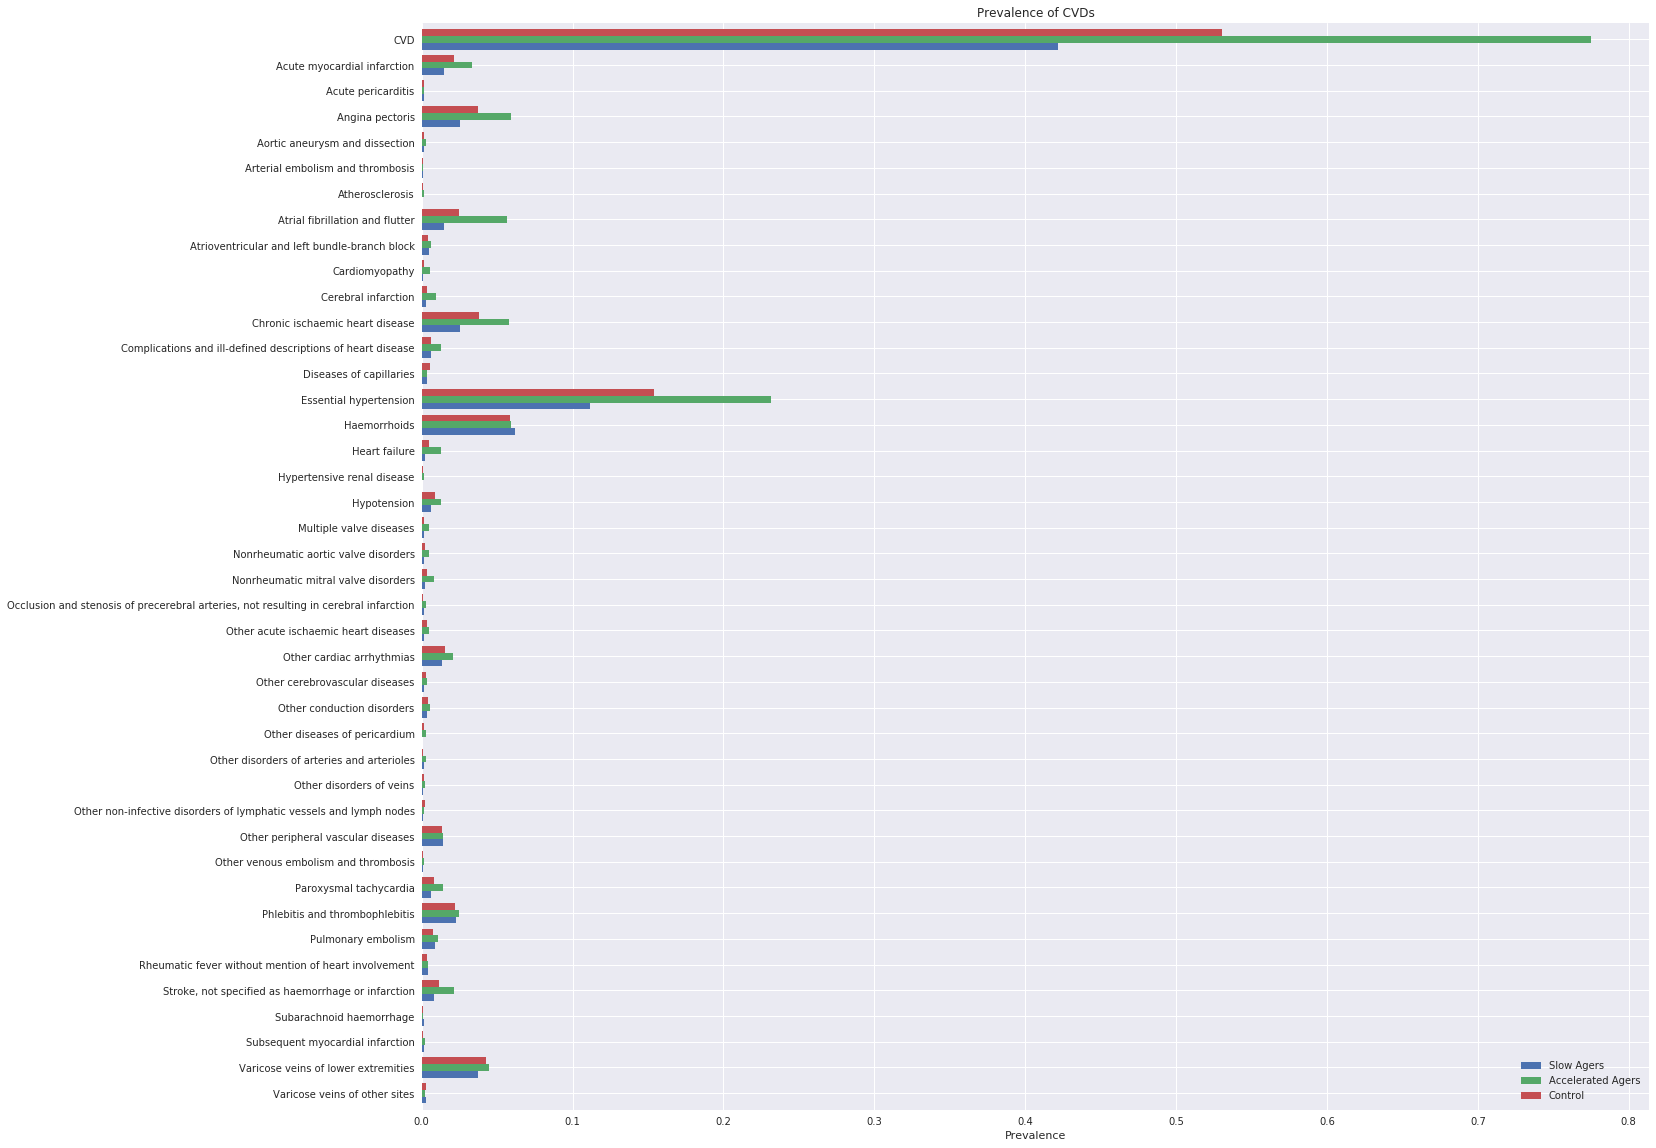

In [328]:
prevalences, prevalences_val = get_prevalences(cvds, percent=0.1)
prevalences = prevalences[['Slow Agers', 'Accelerated Agers', 'Control']]
prevalences_val = prevalences_val[['Slow Agers', 'Accelerated Agers', 'Control']]
plt.rc('ytick', labelsize=12) 
plt.style.use('seaborn')

fig, (ax1) = plt.subplots(1,1, figsize=(22,20))

# Prevalances
width= 0.8
prevalences.plot.barh(ax=ax1, width=width)
ax1.set_xlabel('Prevalence')
ax1.set_title('Prevalence of CVDs')

#significance
typeI_err_corr =-np.log10( 0.05 / prevalences_val.shape[0])
HT_pval = prevalences_val.copy()
HT_pval.mask(HT_pval <  typeI_err_corr, inplace=True)
significance = prevalences*(prevalences*HT_pval)/(prevalences*HT_pval)
subbar_position = [-1.5*width/3, 0]

for c, cvd in enumerate(prevalences_val.index):
    for g, group in enumerate(significance.loc[cvd]):
        if group == group: # test if nan
            ax1.text(prevalences.iloc[c,g] +0.005 , c+ subbar_position[g], '*', 
                     verticalalignment='center', fontsize= 16, color='r' )
        if prevalences_val.loc[pathology,'Slow Agers'] > typeI_err_corr:
            texts.append(ax1.annotate(pathology, 
                 (prevalences.loc[pathology,'Slow Agers'], prevalences_val.loc[pathology,'Slow Agers']), 
                                  color=sns.color_palette(desat=0.7)[1])) 
            
#bold for significance
significance = significance.reset_index()
index_signif =significance.drop(columns=['index']).dropna(how='all').index.tolist()
for bold in index_signif:
    ax1.get_yticklabels()[bold].set_weight("bold")

fig.tight_layout()
fig.show()

In [260]:
def plot_CVD_residuals_prevalance(cvds, percent = 1, acc_agers = True, min_prevalence = 32):
    """
    cvds : all patient dataframe. True in the column of CVDs or Nan.
    """
    # --- Definies the group ---
    if percent !=1:
        if acc_ager:
            cvds = cvds.sort_values('Residual', ascending=True).\
                    iloc[:int(percent*cvds.shape[0])]
        else:
            cvds = cvds.sort_values('Residual', ascending=Falsee).\
                    iloc[:int(percent*cvds.shape[0])]
    else:
        pass
    
    # --- number of patient or each cvds ---
    counts= cvds.count()
    counts = counts[counts>min_prevalence]
    cvds = cvds[counts.index]
    counts= counts.drop('Residual')
    counts.sort_index(inplace=True, ascending=False)
    index_order = counts.index.tolist() 
    
    # --- Residuals associated with each patient suffering from a certain CVD  ---
    
    df_cvds_res =pd.DataFrame()
    for pathology in cvds.drop(columns=['Residual']).columns:
        tmp = cvds[cvds[pathology]==True]['Residual']
        not_tmp = cvds.loc[~cvds.index.isin(tmp.index), 'Residual']
        if tmp.count()>min_prevalence :
            _, p_val = ttest_ind(tmp, not_tmp, axis=0)
            df_cvds_res.loc[pathology,'P-value'] = p_val
        
    #all cvds:
    label = 'CVDs'
    cvds.insert(cvds.shape[1]-1, label, cvds.apply(lambda x : x[:-1].any(), axis=1))
    index_order = index_order + [label]
    cvds.replace(inplace=True, to_replace= False,value=np.nan)
    tmp = cvds[cvds[label]==True]['Residual']
    tmp.dropna(inplace=True)
    not_tmp = cvds.loc[~cvds.index.isin(tmp.index), 'Residual']
    not_tmp.dropna(inplace=True)
    _, p_val = ttest_ind(tmp, not_tmp, axis=0)
    df_cvds_res.loc[label,'P-value'] = p_val
    counts.loc[label] = counts.sum()
    

    # Adjust and transform p value
    adj_TypeI_err =  0.05 / len(df_cvds_res['P-value'])
    df_cvds_res['P-value'] = -np.log10(df_cvds_res['P-value'])
    
    # --- plotting ---
    boxprops = dict(linestyle='-', linewidth=1.3)
    meanpointprops = dict(marker ='o',
                          markeredgecolor='r', markerfacecolor='firebrick', markersize=7)
    color=dict(boxes='k', whiskers='k', medians='r', caps='k')
    plt.rc('ytick', labelsize=12) 
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,10), sharey=True)
    df_cvds_res = df_cvds_res.loc[index_order]
    ax1.barh(width =df_cvds_res['P-value'], y= range(1,df_cvds_res.shape[0]+1))
    ax1.plot([-np.log10(adj_TypeI_err), -np.log10(adj_TypeI_err)], [0, df_cvds_res.shape[0]+1], 'r--', label= 'Adjusted 5% significance')
    ax1.set_ylabel('Cardiovascualr diseases')
    ax1.set_xlabel('Type I error [-log$_{10}$]')
    ax1.set_yticklabels(df_cvds_res.index)
    ax1.set_yticks(range(1,df_cvds_res.shape[0]+1))
    for i in range(len(counts)):
        ax1.text(0.1, i+1, 'n = {}'.format(counts[i])
                 ,verticalalignment='center')
    
    #bold for significant
    df_cvds_res = df_cvds_res.loc[index_order]
    
    tmp = df_cvds_res.reset_index()
    index_signif = tmp[tmp['P-value'] >= -np.log10(adj_TypeI_err)].index.tolist()
    for bold in index_signif:
        ax1.get_yticklabels()[bold].set_weight("bold")
    ax1.set_title('Cardiovascular disease mean impact')
    ax1.set_xscale('log')

    # Prevalences
    prevalences, prevalences_val = get_prevalences(cvds, percent=0.1)
    prevalences = prevalences[['Slow Agers', 'Accelerated Agers', 'Control']]
    prevalences = prevalences.loc[index_order]
    prevalences_val = prevalences_val[['Slow Agers', 'Accelerated Agers', 'Control']]
    prevalences_val = prevalences_val.loc[index_order]
    # Prevalances
    width= 0.8
    prevalences.plot.barh(ax=ax2, width=width)
    ax2.set_xlabel('Prevalence')
    ax2.set_title('Prevalence of CVDs')

    #significance
    typeI_err_corr =-np.log10( 0.05 / prevalences_val.shape[0])
    HT_pval = prevalences_val.copy()
    HT_pval.mask(HT_pval <  typeI_err_corr, inplace=True)
    significance = prevalences*(prevalences*HT_pval)/(prevalences*HT_pval)
    subbar_position = [-1.5*width/3, 0]

    for c, cvd in enumerate(prevalences_val.index):
        for g, group in enumerate(significance.loc[cvd]):
            if group == group: # test if nan
                ax2.text(prevalences.iloc[c,g] +0.005 , c+ subbar_position[g], '*', 
                         verticalalignment='center', fontsize= 16, color='r' )

    fig.tight_layout()
    fig.show()   

In [261]:
plot_CVD_residuals_prevalance(cvds, percent = 1, acc_agers = True, min_prevalence = 30)

KeyError: "['Residual'] not found in axis"

In [262]:
cvds =  pickle.load(open('/n/groups/patel/JbProst/Heart/Data/CVDs.p', 'rb'))
cvds = pd.concat((cvds,preds_corrected['Residual']), axis=1)
cvds.dropna(subset=['Residual'], inplace=True)
prevalences, prevalences_val = get_prevalences(cvds, percent=0.1)

#fold change
prevalences['Accelerated Agers'] = prevalences['Accelerated Agers'] / prevalences['Control']
prevalences['Slow Agers'] = prevalences['Slow Agers'] / prevalences['Control']

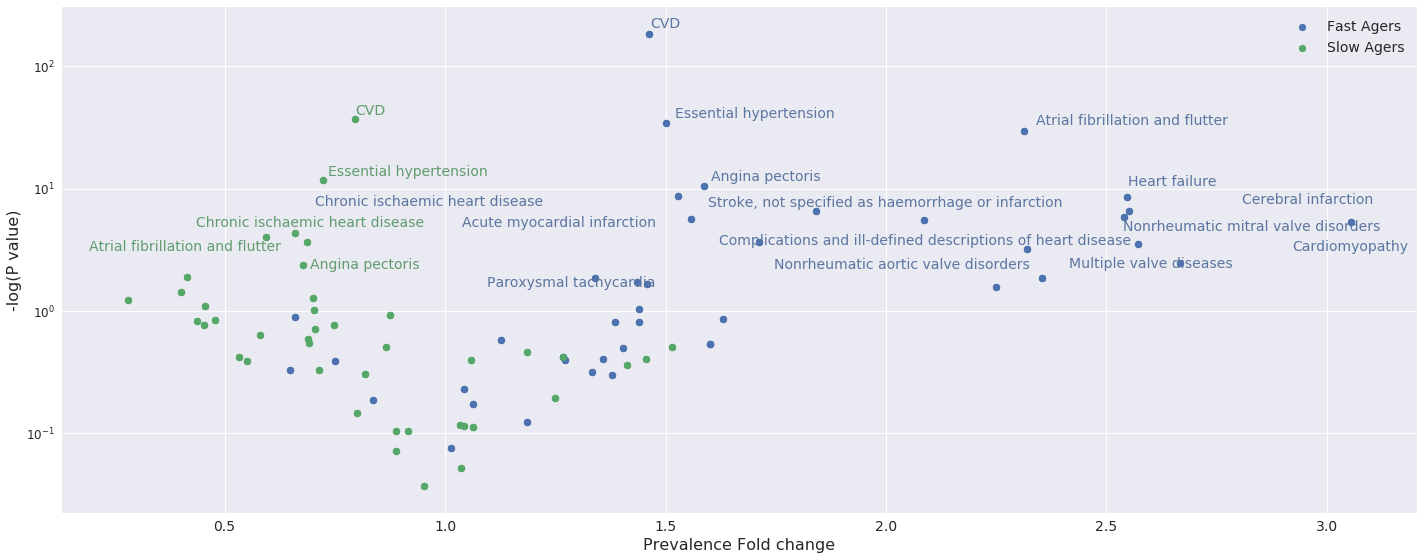

In [268]:
plt.rc('ytick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
fig, ax1 = plt.subplots(1,1,figsize=(20,8))
typeI_err_corr =-np.log10( 0.05 / prevalences_val.shape[0])

ax1.scatter(prevalences['Accelerated Agers'], prevalences_val['Accelerated Agers'],
            color= sns.color_palette()[0], label='Fast Agers')
ax1.scatter(prevalences['Slow Agers'], prevalences_val['Slow Agers'],
            color= sns.color_palette()[1], label='Slow Agers')
boundaries= np.max([np.max(abs(prevalences['Slow Agers'])),
                   np.max(abs(prevalences['Accelerated Agers']))])

#ax1.plot([1-boundaries, boundaries],
#         [typeI_err_corr, typeI_err_corr],
#          'r--', label= 'Adjusted 5% significance')
ax1.set_yscale('log')
#ax1.set_xlim([-np.max(abs(df_cvds_res['Fold_change'])), np.max(abs(df_cvds_res['Fold_change']))])
ax1.set_ylabel('-log(P value)')
ax1.set_xlabel('Prevalance difference')
texts =[] 

for pathology in prevalences_val.index:
    if prevalences_val.loc[pathology,'Accelerated Agers'] > typeI_err_corr:
        texts.append(ax1.annotate(pathology, 
                 (prevalences.loc[pathology,'Accelerated Agers'], prevalences_val.loc[pathology,'Accelerated Agers']),
                                 color=sns.color_palette(desat=0.7)[0],
                     fontsize=14))

adjust_text(texts, only_move={'points':'xy', 'text':'xy'})

for pathology in prevalences_val.index:
    if prevalences_val.loc[pathology,'Slow Agers'] > typeI_err_corr:
        texts.append(ax1.annotate(pathology, 
                 (prevalences.loc[pathology,'Slow Agers'], prevalences_val.loc[pathology,'Slow Agers']), 
                                  color=sns.color_palette(desat=0.7)[1], 
                    fontsize=14))

adjust_text(texts, only_move={'points':'xy', 'text':'xy'})

ax1.scatter(prevalences['Accelerated Agers'], prevalences_val['Accelerated Agers'],
            color= sns.color_palette()[0])
ax1.scatter(prevalences['Slow Agers'], prevalences_val['Slow Agers'],
            color= sns.color_palette()[1])
ax1.set_yscale('log')
ax1.set_ylabel('-log(P value)')
ax1.set_xlabel('Prevalence Fold change')
ax1.legend()
fig.tight_layout()
fig.show()

### Old

In [ ]:
# prevalences_percents = pd.DataFrame()
prevalences_pval_percents = pd.DataFrame()

for percent in np.arange(0.05, 0.9, 0.05):
    df_tmp, df_tmp_pval = get_prevalences(cvds, percent=percent)
    df_tmp.columns = pd.MultiIndex.from_product([[percent], df_tmp.columns ])
    prevalences_percents = pd.concat((prevalences_percents,df_tmp), axis=1) 
    
    df_tmp_pval.columns = pd.MultiIndex.from_product([[percent], df_tmp_pval.columns ])
    prevalences_pval_percents = pd.concat((prevalences_pval_percents,df_tmp_pval), axis=1)    

<Figure size 576x396 with 0 Axes>

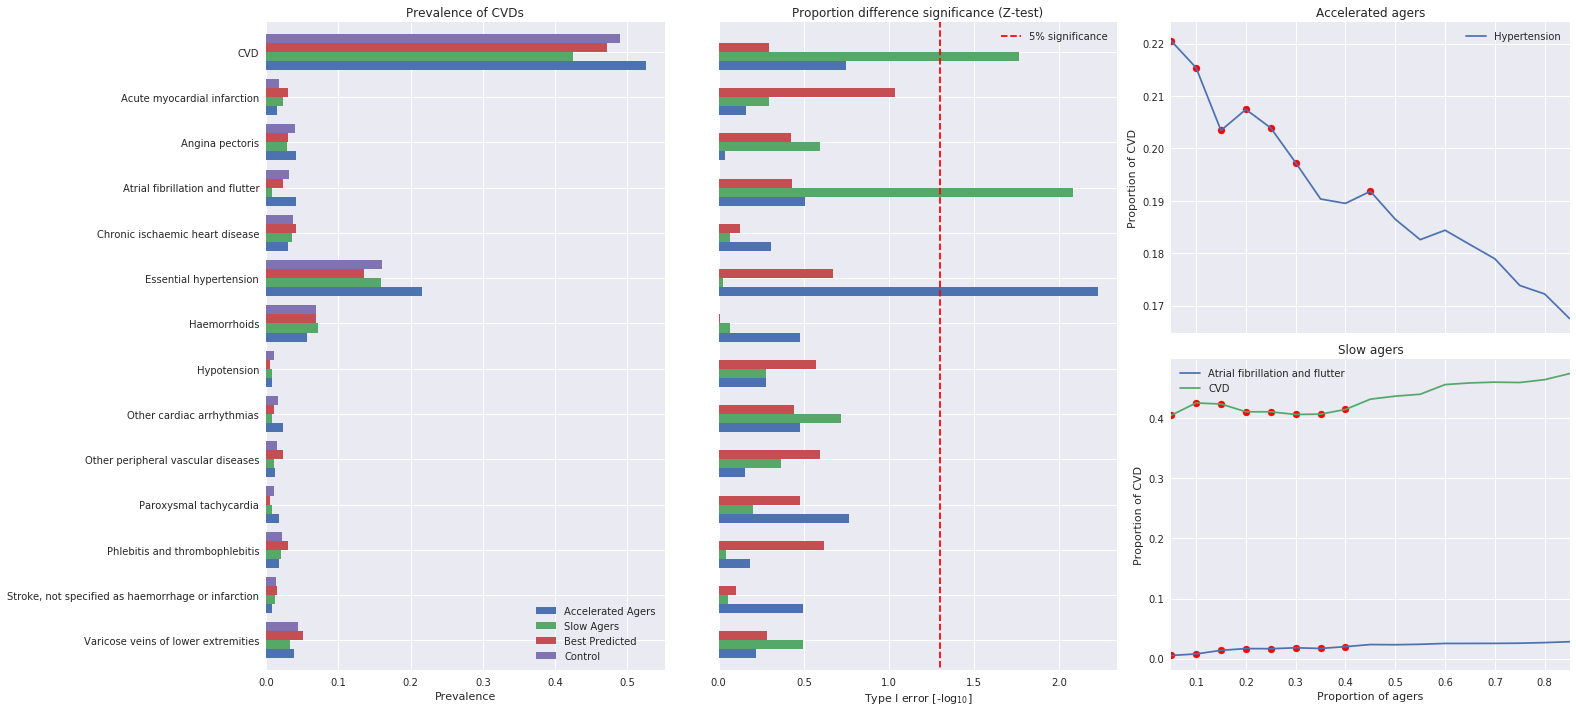

In [36]:
prevalences, prevalences_val = get_prevalences(cvds, percent=0.1)

plt.rc('ytick', labelsize=12) 
plt.style.use('seaborn')
fig = plt.figure()

fig = plt.figure(constrained_layout=True, figsize=(22,10))
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[:, 0])
ax2 = fig.add_subplot(spec[:, 1])
ax3 = fig.add_subplot(spec[0, -1])
ax4 = fig.add_subplot(spec[1, -1])
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22,10), sharey=True)
# Prevalances
prevalences.plot.barh(ax=ax1, width=0.8)
ax1.set_xlabel('Prevalence')
ax1.set_title('Prevalence of CVDs')


#significance
prevalences_val.plot.barh(ax=ax2, width=0.8, legend=False)
ax2.plot([-np.log10(0.05), -np.log10(0.05)], [-1, prevalences.shape[0]+1], 'r--', label= '5% significance')
ax2.legend(['5% significance'])
ax2.set_xlabel('Type I error [-log$_{10}$]')
ax2.set_title('Proportion difference significance (Z-test)')
ax2.set_yticklabels([])

HT = prevalences_percents.swaplevel(axis=1).\
            sort_index(level=0,axis=1)['Accelerated Agers'].\
            loc['Essential hypertension'].transpose()
HT.plot(ax=ax3, label='Hypertension')
HT_pval = prevalences_pval_percents.swaplevel(axis=1).\
            sort_index(level=0,axis=1)['Accelerated Agers'].loc['Essential hypertension']
HT_pval.mask(HT_pval < 1.3,inplace=True)
significance = HT*(HT*HT_pval)/(HT*HT_pval)
ax3.scatter(significance.index, significance, marker='o', color='r')
ax3.set_title('Accelerated agers')
ax3.legend()
ax3.set_ylabel('Proportion of CVD')
ax3.set_xticklabels([])

HT = prevalences_percents.swaplevel(axis=1).\
            sort_index(level=0,axis=1)['Slow Agers'].\
            loc['Atrial fibrillation and flutter'].transpose()
HT.plot(ax=ax4, label='Atrial fibrillation and flutter')
HT_pval = prevalences_pval_percents.swaplevel(axis=1).\
            sort_index(level=0,axis=1)['Slow Agers'].loc['Atrial fibrillation and flutter']
HT_pval.mask(HT_pval < 1.3,inplace=True)
significance = HT*(HT*HT_pval)/(HT*HT_pval)
ax4.scatter(significance.index, significance, marker='o', color='r')
ax4.set_title('Atrial fibrillation and flutter - Slow agers')
ax4.legend(['Atrial fibrillation and flutter'])

HT = prevalences_percents.swaplevel(axis=1).\
            sort_index(level=0,axis=1)['Slow Agers'].\
            loc['CVD'].transpose()
HT.plot(ax=ax4, label='CVD')
HT_pval = prevalences_pval_percents.swaplevel(axis=1).\
            sort_index(level=0,axis=1)['Slow Agers'].loc['CVD']
HT_pval.mask(HT_pval < 1.3,inplace=True)
significance = HT*(HT*HT_pval)/(HT*HT_pval)
ax4.scatter(significance.index, significance, marker='o', color='r')#, markerfacecolor='r')
ax4.set_title('Slow agers')
ax4.set_ylabel('Proportion of CVD')
ax4.legend()
ax4.set_xlabel('Proportion of agers')

fig.tight_layout()
fig.show()

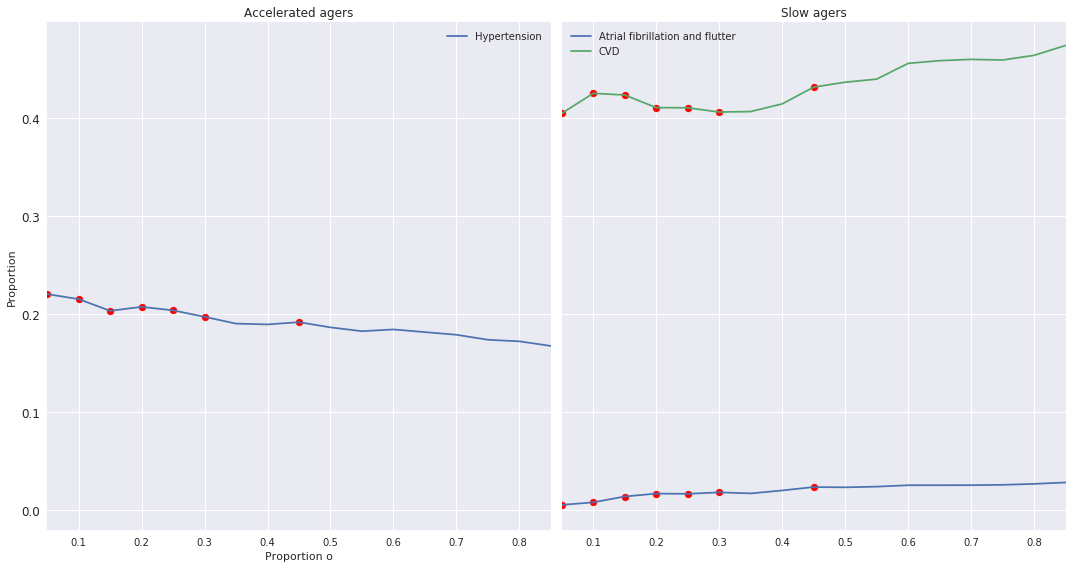

In [475]:
fig, (ax3,ax4) = plt.subplots(1,2,figsize=(15,8), sharey=True)

HT = prevalences_percentsswaplevel(axis=1).\
            sort_index(level=0,axis=1)['Accelerated Agers'].\
            loc['Essential hypertension'].transpose()
HT.plot(ax=ax3, label='Hypertension')
HT_pval = prevalences_pval_percents.swaplevel(axis=1).\
            sort_index(level=0,axis=1)['Accelerated Agers'].loc['Essential hypertension']
HT_pval.mask(x < 1.3,inplace=True)
significance = HT*(HT*HT_pval)/(HT*HT_pval)
ax3.scatter(significance.index, significance, marker='o', color='r')
ax3.set_title('Accelerated agers')
ax3.legend()
ax3.set_ylabel('Proportion')
ax3.set_xlabel('Proportion of Accelerated agears')


HT = prevalences_percentsswaplevel(axis=1).\
            sort_index(level=0,axis=1)['Slow Agers'].\
            loc['Atrial fibrillation and flutter'].transpose()
HT.plot(ax=ax4, label='Atrial fibrillation and flutter')
HT_pval = prevalences_pval_percents.swaplevel(axis=1).\
            sort_index(level=0,axis=1)['Slow Agers'].loc['Atrial fibrillation and flutter']
HT_pval.mask(x < 1.3,inplace=True)
significance = HT*(HT*HT_pval)/(HT*HT_pval)
ax4.scatter(significance.index, significance, marker='o', color='r')
ax4.set_title('Atrial fibrillation and flutter - Slow agers')
ax4.legend(['Atrial fibrillation and flutter'])

HT = prevalences_percentsswaplevel(axis=1).\
            sort_index(level=0,axis=1)['Slow Agers'].\
            loc['CVD'].transpose()
HT.plot(ax=ax4, label='CVD')
HT_pval = prevalences_pval_percents.swaplevel(axis=1).\
            sort_index(level=0,axis=1)['Slow Agers'].loc['CVD']
HT_pval.mask(x < 1.3,inplace=True)
significance = HT*(HT*HT_pval)/(HT*HT_pval)
ax4.scatter(significance.index, significance, marker='o', color='r')#, markerfacecolor='r')
ax4.set_title('Slow agers')
ax4.legend()
fig.tight_layout()

In [203]:
df_cvds_test =pd.DataFrame()
for pathology in top_percent.drop(columns=['Residual']).columns:
    tmp = top_percent[top_percent[pathology]==True]['Residual']
    not_tmp = top_percent.loc[~top_percent.index.isin(tmp.index), 'Residual']
    if tmp.count()>0:
        _, p_val = ttest_ind(tmp, not_tmp, axis=0)
        df_cvds_test.loc[pathology,'P-value'] = p_val
df_cvds_test = -np.log10(df_cvds_test['P-value'])

all_cvds= top_percent.loc[top_percent.drop(columns=('Residual')).dropna(how='all').index, 'Residual']
n_all_cvds = len(all_cvds)
_, p_val_all = ttest_ind(all_cvds, top_percent.loc[~top_percent.index.isin(all_cvds.index), 'Residual'], axis=0)

In [204]:
df_cvds_test

Essential hypertension                                0.276284
Angina pectoris                                       0.159445
Acute myocardial infarction                           0.052776
Chronic ischaemic heart disease                       0.332869
Paroxysmal tachycardia                                0.050504
Atrial fibrillation and flutter                       0.053745
Other cardiac arrhythmias                             0.461111
Stroke, not specified as haemorrhage or infarction    0.023165
Other peripheral vascular diseases                    0.653529
Phlebitis and thrombophlebitis                        0.155948
Varicose veins of lower extremities                   1.838787
Haemorrhoids                                          0.184319
Hypotension                                           0.324827
Name: P-value, dtype: float64

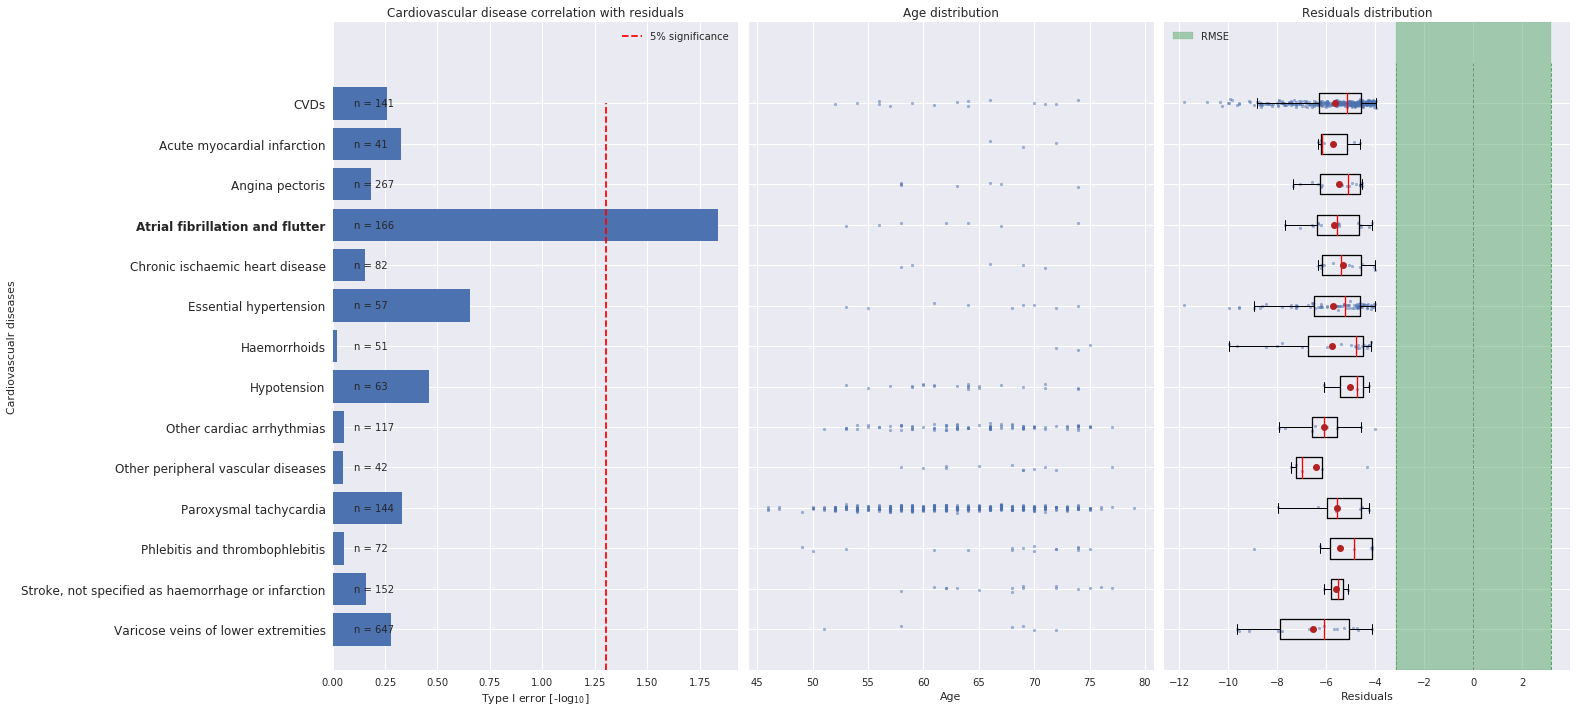

In [205]:
boxprops = dict(linestyle='-', linewidth=1.3)
meanpointprops = dict(marker ='o',
                      markeredgecolor='r', markerfacecolor='firebrick', markersize=7)#, linewidth=5)
medianprops= boxprops#dict(linestyle='-', linewidth=1.5),
color=dict(boxes='k', whiskers='k', medians='r', caps='k')

plt.rc('ytick', labelsize=12) 
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,10), sharey=True)

ax1.barh(width =df_cvds_test, y= range(1,df_cvds_test.shape[0]+1))
ax1.barh(width =p_val_all, y=df_cvds_test.shape[0]+1, color=sns.color_palette()[0])
ax1.plot([-np.log10(0.05), -np.log10(0.05)], [0, df_cvds_test.shape[0]+1], 'r--', label= '5% significance')
ax1.set_ylabel('Cardiovascualr diseases')
ax1.set_xlabel('Type I error [-log$_{10}$]')
ax1.set_yticklabels(df_cvds_test.index)
ax1.set_yticks(range(1,df_cvds_test.shape[0]+1))
for i in range(len(counts[:-1])):
    ax1.text(0.1, i+1, 'n = {}'.format(counts[i]), verticalalignment='center')
ax1.text(0.1, i+2, 'n = {}'.format(n_all_cvds), verticalalignment='center')
#bold for significant
tmp = df_cvds_test.reset_index()
index_signif= tmp[tmp['P-value'] >= -np.log10(0.05)].index.tolist()
for bold in index_signif:
    ax1.get_yticklabels()[bold].set_weight("bold")
ax1.set_title('Cardiovascular disease correlation with residuals')
ax1.legend()


ax1.set_ylabel('Cardiovascualr diseases')
ax1.set_ylabel('Cardiovascualr diseases')
ax1.set_xlabel('Type I error [-log$_{10}$]')
ax1.set_yticks(range(1,df_count.shape[0]+2))

# Age distribution
cvds_distrib = top_percent.drop(columns=['Residual'])
cvds_distrib = cvds_distrib.join(preds_corrected.Age)
cvds_distrib = cvds_distrib.apply(lambda row: row[:-1]*row[-1], axis=1)
cvds_distrib.sort_index(axis=0,inplace=True, ascending=False)
cvds_distrib = cvds_distrib.join(preds_corrected.Age).rename(columns={'Age' : 'CVDs'})

#scatter
names, vals, ys = [], [] ,[]
for i, col_name in enumerate(sorted(cvds_distrib)):
    names.append(col_name)
    vals_tmp = cvds_distrib[col_name].dropna().tolist()
    vals.append(vals_tmp)
    ys.append(np.random.normal(i+1, 0.04,len(vals_tmp)))

colors = np.array(sns.color_palette()[0]).reshape(1,3)
for y, val in zip(ys, vals):
    ax2.scatter(val, y, c=colors, alpha=0.5, s=8)

#cvds_distrib.plot.box(vert=False, ax= ax2, boxprops=boxprops, showfliers=False, 
#                  medianprops=medianprops,
#                  showmeans=True, meanline=False, meanprops = meanpointprops,
#                  color= color) 

#ax2.set_yticks(range(cvds_distrib.shape[1]+1))
#ax2.yaxis.set_ticklabels([])
ax2.set_title('Age distribution')
ax2.set_xlabel('Age')

#residuals
cvds_res = top_percent.apply(lambda row: row[:-1]*row[-1], axis=1)
cvds_res.sort_index(axis=1,inplace=True, ascending=False)
cvds_res = cvds_res.join(top_percent.Residual).rename(columns={'Residual' : 'CVDs'})
ax3.plot([-RMSE_corr,-RMSE_corr], [0, cvds_res.shape[1]+1], '--', linewidth=1, color= sns.color_palette()[1])
ax3.plot([RMSE_corr,RMSE_corr], [0, cvds_res.shape[1]+1], '--', linewidth=1, color= sns.color_palette()[1])
ax3.plot([0,0], [0, cvds_res.shape[1]+1], 'k--', linewidth=1, alpha=0.3)
ax3.axvspan(-RMSE_corr, RMSE_corr, alpha=0.5, color=sns.color_palette()[1], 
            label= 'RMSE')

names, vals, ys = [], [] ,[]
for i, col_name in enumerate(cvds_res):
    names.append(col_name)
    vals_tmp = cvds_res[col_name].dropna().tolist()
    vals.append(vals_tmp)
    ys.append(np.random.normal(i+1, 0.04,len(vals_tmp)))

colors = np.array(sns.color_palette()[0]).reshape(1,3)
for y, val in zip(ys, vals):
    ax3.scatter(val, y, c=colors, alpha=0.5, s=8)

cvds_res.plot.box(vert=False, ax= ax3, boxprops=boxprops, showfliers=False, 
                  medianprops=medianprops,
                  showmeans=True, meanline=False, meanprops = meanpointprops,
                  color= color) 
ax3.set_ylim([0, cvds.shape[1]+2])
ax3.set_title('Residuals distribution')
ax3.legend()
ax3.set_xlabel('Residuals')

fig.tight_layout()
fig.show()

## Antropometry

In [240]:
import statsmodels.api as sm

In [241]:
def get_correlation(df, percent, Pred_Age, plot_ResVsRawCondition = False,
                    plot_ResVsCorrCondition = False, plot_AgeDistrib =False,
                    plot_top = False, plot_corr_evolution = False,
                   plot_TopResVsCorrCondition = True):


    top_percent_pos = df.sort_values('Residual', ascending=False).iloc[:int(percent*df.shape[0])]
    top_percent_neg = df.sort_values('Residual', ascending=True).iloc[:int(percent*df.shape[0])]
    
    ###  --- Residuals vs raw condition ---
    if plot_ResVsRawCondition:
        fig, axes = plt.subplots(1,len(df.columns[:-2]), figsize=(18,6), sharey=True)
        for i,col in enumerate(df.columns[:-2]):
            axes[i].scatter(df[col],df['Residual'], alpha=0.3, s=10)
            tmp = df[col].dropna()
            coef, pval = pearsonr(tmp,df.loc[tmp.index, 'Residual'])
            axes[i].set_title(col[0].upper()+ col[1:] )#+ ' ' + str(np.round(coef, 3)))
        axes[0].set_ylabel('Residuals')
        fig.tight_layout()

    # plot the distribution over the top percent of miss predicted
    if plot_top:
        fig, axes = plt.subplots(2,len(df.columns[:-2]), figsize=(20,8), sharey='row', sharex='col')
        axes = axes.flatten()

        df_corr_pos= pd.DataFrame() 
        df_corr_neg= pd.DataFrame() 

        for i, col in enumerate(top_percent_pos.columns[:-2]):
            #Positives residuals
            axes[i].scatter(top_percent_pos[col],top_percent_pos['Residual'], alpha=0.3, s=10)
            tmp = top_percent_pos[col].dropna()
            coef, pval = pearsonr(tmp,top_percent_pos.loc[tmp.index, 'Residual'])
            axes[i].set_title(col[0].upper()+ col[1:] )#+ ' ' + str(np.round(coef, 3)))
            df_corr_pos.loc[col, 'P-value'] = pval
            df_corr_pos.loc[col, 'Correlation'] = coef

            if pval < 0.05:
                reg = LinearRegression().fit(tmp.to_numpy().reshape(-1, 1),
                                             top_percent_pos.loc[tmp.index, 'Residual'].to_numpy().reshape(-1, 1))
                X = np.array([top_percent_pos[col].min(),top_percent_pos[col].max()]).reshape(-1,1)
                axes[i].plot(X, reg.intercept_ + reg.coef_*X, 'r--', label='R$^2$ = {}'.format(np.round(coef*coef, 2)))
                axes[i].legend()
                df_corr_pos.loc[col, 'Linear coefficient'] = reg.coef_


            #Negatives residuals
            axes[i+len(df.columns[:-2])].scatter(top_percent_neg[col],top_percent_neg['Residual'], alpha=0.3, s=10)
            tmp = top_percent_neg[col].dropna()
            coef, pval = pearsonr(tmp,top_percent_neg.loc[tmp.index, 'Residual'])
            df_corr_neg.loc[col, 'P-value'] = pval
            df_corr_neg.loc[col, 'Correlation'] = coef

            if pval < 0.05:
                reg = LinearRegression().fit(tmp.to_numpy().reshape(-1, 1),
                                             top_percent_neg.loc[tmp.index, 'Residual'].to_numpy().reshape(-1, 1))
                X = np.array([top_percent_neg[col].min(),top_percent_neg[col].max()]).reshape(-1,1)
                axes[i+len(df.columns[:-2])].plot(X, reg.intercept_ + reg.coef_*X, 'r--', label='R$^2$ = {}'.format(np.round(coef*coef, 2)))
                axes[i+len(df.columns[:-2])].legend()
                df_corr_neg.loc[col, 'Linear coefficient'] = reg.coef_


        axes[0].set_ylabel('Residuals')
        axes[len(df.columns[:-2])].set_ylabel('Residuals')
        fig.tight_layout()

    # ---- Difference with average for each age    
    # Distribution per age
    if plot_AgeDistrib:
        fig, axes = plt.subplots(1,len(df.columns[:-2]), figsize=(18,6), sharey=True)
        for i,col in enumerate(df.columns[:-2]):
            tmp = df[[col, 'Age']].groupby('Age').mean()
            axes[i].barh(width = tmp[col] , y= tmp.index)# alpha=0.3, s=10)
            axes[i].set_title(col[0].upper()+ col[1:] )#+ ' ' + str(np.round(coef, 3)))
        axes[0].set_ylabel('Age')
        fig.tight_layout()

    df_mean = df.drop(columns='Residual').groupby('Age').mean()
    df_mean['Residual'] =0
    df_mean['Age'] =0
    for age in df.Age.unique():
        df[df.Age==age] -= df_mean.loc[age,]

    if plot_ResVsCorrCondition:
        fig, axes = plt.subplots(1,len(df.columns[:-2]), figsize=(18,6), sharey=True)
        for i,col in enumerate(df.columns[:-2]):
            tmp = df[col].dropna()
            tmp = tmp[(np.abs(zscore(tmp)) < 3)]
            axes[i].scatter(df.loc[tmp.index, col],df.loc[tmp.index, 'Residual'], alpha=0.3, s=10)
            coef, pval = pearsonr(tmp,df.loc[tmp.index, 'Residual'])
            axes[i].set_title(col[0].upper()+ col[1:] )#+ ' ' + str(np.round(coef, 3)))
        axes[0].set_ylabel('Residuals')
        fig.tight_layout()
    
    if plot_TopResVsCorrCondition:
        top_percent_pos = df.sort_values('Residual', ascending=False).iloc[:int(percent*df.shape[0])]
        top_percent_neg = df.sort_values('Residual', ascending=True).iloc[:int(percent*df.shape[0])]

        fig, axes = plt.subplots(2,len(df.columns[:-2]), figsize=(3*len(top_percent_pos.columns[:-2]),8)
                                                                  , sharey='row', sharex='col')
        axes = axes.flatten()

        for i, col in enumerate(top_percent_pos.columns[:-2]):
            # --- Positives residuals
            tmp = top_percent_pos[col].dropna()
            tmp = tmp[(np.abs(zscore(tmp)) < 4)]
            axes[i].scatter(top_percent_pos.loc[tmp.index,col],
                            top_percent_pos.loc[tmp.index,'Residual'],
                            alpha=0.3, s=10)
            coef, pval = pearsonr(tmp,top_percent_pos.loc[tmp.index, 'Residual'])

            if pval < 0.05:
                axes[i].set_title( r"$\bf{" +(col[0].upper()+ col[1:]).replace(' ', ' \\ ') +r'}$'+ '\ncorr = {}'.format(np.round(coef, 2) ))
            else:
                axes[i].set_title( r"$\bf{" +(col[0].upper()+ col[1:]).replace(' ', ' \\ ')+r'}$'+ '\n-' )
            
            #Linear model
            X = tmp.to_numpy().reshape(-1, 1)
            X = sm.add_constant(X)
            y = top_percent_pos.loc[tmp.index, 'Residual'].to_numpy().reshape(-1, 1)
            mod = sm.OLS(y, X)
            fii = mod.fit()
            p_value = fii.f_pvalue
            if p_value < 0.05:
                X = np.array([X.min(),X.max()]).reshape(-1,1)
                coef = fii.params[1]
                intercept =  fii.params[0]
                axes[i].plot(X, intercept + coef*X, 'r--', label='Lin. Coef = {}'.format(np.round(coef, 3)))
                axes[i].legend()

            # --- Negatives residuals
            tmp = top_percent_neg[col].dropna()
            tmp = tmp[(np.abs(zscore(tmp)) < 4)]
            coef, pval = pearsonr(tmp,top_percent_neg.loc[tmp.index, 'Residual'])

            if pval < 0.05:
                axes[i+len(df.columns[:-2])].set_title( 'corr = {}'.format(np.round(coef, 2)))
            
            axes[i+len(df.columns[:-2])].scatter(top_percent_neg.loc[tmp.index,col],
                                                 top_percent_neg.loc[tmp.index,'Residual'],
                                                 alpha=0.3, s=10)
            #Linear model
            X = tmp.to_numpy().reshape(-1, 1)
            X = sm.add_constant(X)
            y = top_percent_neg.loc[tmp.index, 'Residual'].to_numpy().reshape(-1, 1)
            mod = sm.OLS(y, X)
            fii = mod.fit()
            p_value = fii.f_pvalue
            if p_value < 0.05:
                X = np.array([X.min(),X.max()]).reshape(-1,1)
                coef = fii.params[1]
                intercept =  fii.params[0]
                axes[i+len(df.columns[:-2])].plot(X, intercept + coef*X, 'r--', label='Lin. Coef = {} *'.format(np.round(coef, 3)))
                axes[i+len(df.columns[:-2])].legend()
            #axes[i+len(df.columns[:-2])].set_xlabel('Age Corrected condition')

        
        axes[0].set_ylabel('Slow Agers Residuals')
        axes[len(df.columns[:-2])].set_ylabel('Accelerated Agers Residuals')
        fig.tight_layout()
        
def bootstrap_correlation(X, Y, nb_bootstrap = 100):

    df_bootstrap_score = pd.DataFrame()
    df_data = pd.DataFrame({'X' : X, 'Y': Y}) 

    for n in range(nb_bootstrap):
        df_tmp = df_data.sample(frac=1, replace= True)
        X = df_tmp['X']
        Y = df_tmp['Y'] 
        
        coef, pval = pearsonr(X,Y)
        if pval < 0.05:
            df_bootstrap_score.loc[n,'Corr'] = coef
        else:
            df_bootstrap_score.loc[n, 'Corr'] = np.nan
        
    return df_bootstrap_score

def plot_corr_evolution(df, sliding_window = False, merged =False):
    
    df_corr_pos= pd.DataFrame() 
    df_corr_neg= pd.DataFrame() 
    df_corr_pos_err= pd.DataFrame() 
    df_corr_neg_err= pd.DataFrame() 
    df_count_neg = pd.DataFrame() 
    df_count_pos = pd.DataFrame() 
    nb_bootstrap = 1000
    
    if sliding_window !=False:
        window = int(df.shape[0]*sliding_window)
        window_begging = 0
        j=1
        while window_begging < df.shape[0]:
            top_percent_pos = df.sort_values('Residual', ascending=False).iloc[window_begging:window_begging+window]
            top_percent_neg = df.sort_values('Residual', ascending=True).iloc[window_begging:window_begging+window]
            percent = sliding_window*j
            j += 1
            
            for i, col in enumerate(top_percent_pos.drop(columns=['Residual', 'Age']).columns):
                #Positives residuals
                tmp = top_percent_pos[col].dropna()
                #tmp = tmp[(np.abs(zscore(tmp)) < 4)]
                df_count_pos.loc[percent, col] = tmp.count()
                df_bootstrap = bootstrap_correlation(tmp, 
                                                     top_percent_pos.loc[tmp.index,'Residual']
                                                     , nb_bootstrap = nb_bootstrap)
                mean_coef = df_bootstrap.mean()[0]
                std_coef = df_bootstrap.std()[0]
                df_corr_pos.loc[percent, col] = mean_coef
                df_corr_pos_err.loc[percent, col] = std_coef

                #Negatives residuals
                tmp = top_percent_neg[col].dropna()
                #tmp = tmp[(np.abs(zscore(tmp)) < 4)]
                df_count_neg.loc[percent, col] = tmp.count()
                df_bootstrap = bootstrap_correlation(tmp, 
                                                     top_percent_neg.loc[tmp.index,'Residual']
                                                     , nb_bootstrap = nb_bootstrap)
                mean_coef = df_bootstrap.mean()[0]
                std_coef = df_bootstrap.std()[0]
                df_corr_neg.loc[percent, col] = mean_coef
                df_corr_neg_err.loc[percent, col] = std_coef

            window_begging += window
            
            # plotting
        if merged :
            plt.figure(figsize(15,6))
            df_corr_neg.index= -df_corr_neg.index
            df_corr = pd.concat((df_corr_neg,df_corr_pos),axis=0)
            df_corr_pos.plot(marker='o', yerr = df_corr_pos_err, drawstyle="steps",legend=False)
            plt.xlabel('Proportion of patient ranked by residuals')
        else:
            fig, axes = plt.subplots(1,2, figsize=(20,8), sharey='row', sharex=False)#, sharex='col')
            #(ax1, ax2, ax3, ax4) = axes.flatten()
            (ax1, ax2) = axes.flatten()
            df_corr_pos.plot(ax=ax1, marker='o', yerr = df_corr_pos_err, drawstyle="steps",legend=False)
            df_corr_neg.plot(ax=ax2,marker='o', yerr = df_corr_neg_err, drawstyle="steps",legend=False)

            ax1.set_ylabel('Pearson Correlation')
            ax1.set_title('Positive residuals - Slow Agers')
            ax2.set_title('Negative residuals - Accelerated Agers')
            ax2.set_xlim([0,df_corr_pos.index[-1]])
            ax1.set_xlim([0,df_corr_pos.index[-1]])
            ax1.set_xlabel('Top proportion of miss-predicted')
            ax2.set_xlabel('Top proportion of miss-predicted')
    
    else:
        for percent in tqdm(np.arange(0.05,1, 0.05)):
            top_percent_pos = df.sort_values('Residual', ascending=False).iloc[:int(percent*df.shape[0])]
            top_percent_neg = df.sort_values('Residual', ascending=True).iloc[:int(percent*df.shape[0])]

            for i, col in enumerate(top_percent_pos.drop(columns=['Residual', 'Age']).columns):
                #Positives residuals
                tmp = top_percent_pos[col].dropna()
                tmp = tmp[(np.abs(zscore(tmp)) < 4)]
                df_count_pos.loc[percent, col] = tmp.count()
                df_bootstrap = bootstrap_correlation(tmp, 
                                                     top_percent_pos.loc[tmp.index,'Residual']
                                                     ,nb_bootstrap = nb_bootstrap)
                mean_coef = df_bootstrap.mean()[0]
                std_coef = df_bootstrap.std()[0]
                df_corr_pos.loc[percent, col] = mean_coef
                df_corr_pos_err.loc[percent, col] = std_coef

                #df_corr_pos.loc[percent, col] = np.nan

                #Negatives residuals
                tmp = top_percent_neg[col].dropna()
                tmp = tmp[(np.abs(zscore(tmp)) < 4)]
                df_count_neg.loc[percent, col] = tmp.count()
                df_bootstrap = bootstrap_correlation(tmp, 
                                                     top_percent_neg.loc[tmp.index,'Residual']
                                                     , nb_bootstrap = nb_bootstrap)
                mean_coef = df_bootstrap.mean()[0]
                std_coef = df_bootstrap.std()[0]
                df_corr_neg.loc[percent, col] = mean_coef
                df_corr_neg_err.loc[percent, col] = std_coef
        
        # plotting
        if merged :
            
            fig, ax = plt.subplots(1,1, figsize=(15,6))
            df_corr_pos= df_corr_pos.iloc[::-1]
            df_corr_neg.index= -1+df_corr_neg.index
            df_corr_pos.index= 1-df_corr_pos.index
            df_corr = pd.concat((df_corr_neg,df_corr_pos),axis=0)
            
            df_corr_neg_err.index= -1+df_corr_neg_err.index
            df_corr_pos_err.index= 1-df_corr_pos_err.index
            df_corr_err = pd.concat((df_corr_neg_err,df_corr_pos_err),axis=0)
            
            df_corr.plot(ax=ax, marker='o', yerr = df_corr_err)
            ax.legend(ncol=len(df_corr.columns))
            ax.set_xlabel('Proportion of patient ranked by residuals')
            ax.set_ylabel('Pearson Correlation')

        else:
            fig, axes = plt.subplots(1,2, figsize=(20,8), sharey='row', sharex=False)#, sharex='col')
            #(ax1, ax2, ax3, ax4) = axes.flatten()
            (ax1, ax2) = axes.flatten()
            df_corr_pos.plot(ax=ax1, marker='o', yerr = df_corr_pos_err, legend=False)
            df_corr_neg.plot(ax=ax2,marker='o', yerr = df_corr_neg_err, legend=False)

            ax1.set_ylabel('Pearson Correlation')
            ax1.set_title('Positive residuals - Slow Agers')
            ax2.set_title('Negative residuals - Accelerated Agers')
            ax2.set_xlim([0,df_corr_pos.index[-1]])
            ax1.set_xlim([0,df_corr_pos.index[-1]])
            ax1.set_xlabel('Top proportion of miss-predicted')
            ax2.set_xlabel('Top proportion of miss-predicted')
            fig.tight_layout()
    """
    df_count_pos.plot.bar(ax= ax3)
    df_count_neg.plot.bar(ax=ax4, legend= False)
    ax3.set_ylabel('Number of patients')
    ax3.set_xlabel('Top proportion of miss-predicted')
    ax4.set_xlabel('Top proportion of miss-predicted')
    ax3.legend(ncol= len(df_count_pos), bbox_to_anchor= (1.5, 0.0))
    """
            

In [254]:
def plot_parameter_t_test(df, percent = 1, acc_agers = True, 
                          age_normalization =True):
    """
    df : all patient dataframe. True in the column of df or Nan.
    """
    # --- Correcting phenotypes per age ---
    if age_normalization : 
        df_mean = df.drop(columns='Residual').groupby('Age').mean()
        df_mean['Residual'] =0
        df_mean['Age'] =0
        for age in df.Age.unique():
            df[df.Age==age] -= df_mean.loc[age,]
    
    # --- Definies the group ---
    if acc_agers:
        df_top = df.sort_values('Residual', ascending=True).\
                    iloc[:int(percent*df.shape[0])]
        df = df.sort_values('Residual', ascending=True).\
                    iloc[int(percent*df.shape[0]):]
        ager_profile ='Acc'
    else:
        df_top = df.sort_values('Residual', ascending=False).\
                iloc[:int(percent*df.shape[0])]
        df =df.sort_values('Residual', ascending=False).\
                    iloc[int(percent*df.shape[0]):]
        ager_profile='Slow'

    # --- Residuals associated with each patient suffering from a certain CVD  ---
    df_res =pd.DataFrame()
    for col in tqdm(df.drop(columns=['Residual', 'Age']).columns):
        tmp = df_top[col]
        tmp.dropna(inplace=True)
        not_tmp = df[col]
        not_tmp.dropna(inplace=True)
        _, p_val = ttest_ind(tmp, not_tmp)#, axis=0)
        df_res.loc[col,'P-value'] = p_val
    df_res = -np.log10(df_res)
    
    # --- Plotting ---
    plt.rc('ytick', labelsize=12) 
    fig = plt.figure(constrained_layout=True, figsize=(22,10))
    spec = gridspec.GridSpec(ncols=2, nrows=len(df_res), figure=fig)
    ax1 = fig.add_subplot(spec[:, 0])
    axes = [fig.add_subplot(spec[i, 1]) for i in range(len(df_res))]
    #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5), sharey=True)

    #ax1.barh(width =df_res, y= range(0,df_res.shape[0]))
    adj_threshold = 0.05/df_res.shape[0]
    df_res.plot.barh(ax=ax1)
    ax1.plot([-np.log10(adj_threshold), -np.log10(adj_threshold)], [-0.5, df_res.shape[0]], 'r--', label= 'Adjusted 5% significance')
    ax1.set_ylabel('Parameter')
    ax1.set_xlabel('Type I error [-log$_{10}$]')
    ax1.set_yticks(range(0,df_res.shape[0]))
    ax1.set_yticklabels(df_res.index)


    #bold for significant
    tmp = df_res.reset_index()
    index_signif= tmp[tmp['P-value'] >= -np.log10(adj_threshold)].index.tolist()
    for bold in index_signif:
        ax1.get_yticklabels()[bold].set_weight("bold")
    ax1.set_title('T-test significance : {}_ager vs non-{}_ager'.format(ager_profile,ager_profile))
    ax1.legend()
   # return df, df_top
    
    # Box plots
    for i, col in enumerate(tqdm(df.drop(columns=['Residual', 'Age']).columns)):
        i = len(df_res)- i -1
        tmp = df_top[col]
        tmp.dropna(inplace=True)
        not_tmp = df[col]
        not_tmp.dropna(inplace=True)
        
        #axes[i].boxplot((tmp,not_tmp),vert=False)
        sns.boxplot(ax=axes[i], orient='h',
            data=[tmp, not_tmp],
            palette=[ sns.color_palette()[0], sns.color_palette()[3]],
            showmeans=True,
           notch=True)
    
    fig.tight_layout()
    fig.show()
    

In [284]:
def plot_parameter_t_test(df, percent = 1, 
                          age_normalization =True):
    """
    df : all patient dataframe. True in the column of df or Nan.
    """
    # --- Correcting phenotypes per age ---
    if age_normalization : 
        df_mean = df.drop(columns='Residual').groupby('Age').mean()
        df_mean['Residual'] =0
        df_mean['Age'] =0
        for age in df.Age.unique():
            df[df.Age==age] -= df_mean.loc[age,]
    
    # --- Definies the group ---
    df_acc = df.sort_values('Residual', ascending=True).\
                    iloc[:int(percent*df.shape[0])]
    df_slow = df.sort_values('Residual', ascending=False).\
                iloc[:int(percent*df.shape[0])]
    idx_agers = df_acc.index.tolist() +df_slow.index.tolist()
    df = df.loc[~df.index.isin(idx_agers)]

    # --- Residuals associated with each patient suffering from a certain CVD  ---
    df_res =pd.DataFrame()
    for col in tqdm(df.drop(columns=['Residual', 'Age']).columns):
        #positive
        tmp = df_acc[col]
        tmp.dropna(inplace=True)
        not_tmp = df[col]
        not_tmp.dropna(inplace=True)
        _, p_val = ttest_ind(tmp, not_tmp)#, axis=0)
        df_res.loc[col,'Acc'] = p_val
        #negative
        tmp = df_slow[col]
        tmp.dropna(inplace=True)
        _, p_val = ttest_ind(tmp, not_tmp)#, axis=0)
        df_res.loc[col,'Slow'] = p_val
    
    df_res = -np.log10(df_res)
    
    # --- Plotting ---
    plt.rc('ytick', labelsize=12) 
    fig = plt.figure(constrained_layout=True, figsize=(22,10))
    spec = gridspec.GridSpec(ncols=3, nrows=len(df_res), figure=fig)
    ax1 = fig.add_subplot(spec[:, 0])
    axes = [fig.add_subplot(spec[i, 1:]) for i in range(len(df_res))]
    #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5), sharey=True)

    #ax1.barh(width =df_res, y= range(0,df_res.shape[0]))
    adj_threshold = 0.05/df_res.shape[0]
    df_res.plot.barh(ax=ax1)
    ax1.plot([-np.log10(adj_threshold), -np.log10(adj_threshold)], [-0.5, df_res.shape[0]], 'r--', label= 'Adjusted 5% significance')
    ax1.set_ylabel('Parameter')
    ax1.set_xlabel('Type I error [-log$_{10}$]')
    ax1.set_yticks(range(0,df_res.shape[0]))
    ax1.set_yticklabels(df_res.index)


    #bold for significant
    tmp = df_res.reset_index()
    index_signif= tmp[(tmp['Acc'] >= -np.log10(adj_threshold)) | (tmp['Slow'] >= -np.log10(adj_threshold))].index.tolist()
    for bold in index_signif:
        ax1.get_yticklabels()[bold].set_weight("bold")
    ax1.set_title('T-test significance')
    ax1.legend()
   # return df, df_top
    
    # Box plots
    for i, col in enumerate(tqdm(df.drop(columns=['Residual', 'Age']).columns)):
        i = len(df_res)- i -1
        acc = df_acc[col]
        acc.dropna(inplace=True)
        acc = acc[zscore(acc) < 4]
        slow = df_slow[col]
        slow.dropna(inplace=True)
        slow = slow[zscore(slow) < 4]
        control = df[col]
        control.dropna(inplace=True)
        control = control[zscore(control) < 4]
        
        #axes[i].boxplot((tmp,not_tmp),vert=False)
        sns.boxplot(ax=axes[i], orient='h',
            data=[acc,control, slow],
            palette=[ sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[1]],
            showmeans=True,
           notch=True)
    axes[0].set_title('Age relative phenotype distribution')
    fig.tight_layout()
    fig.show()
    

100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


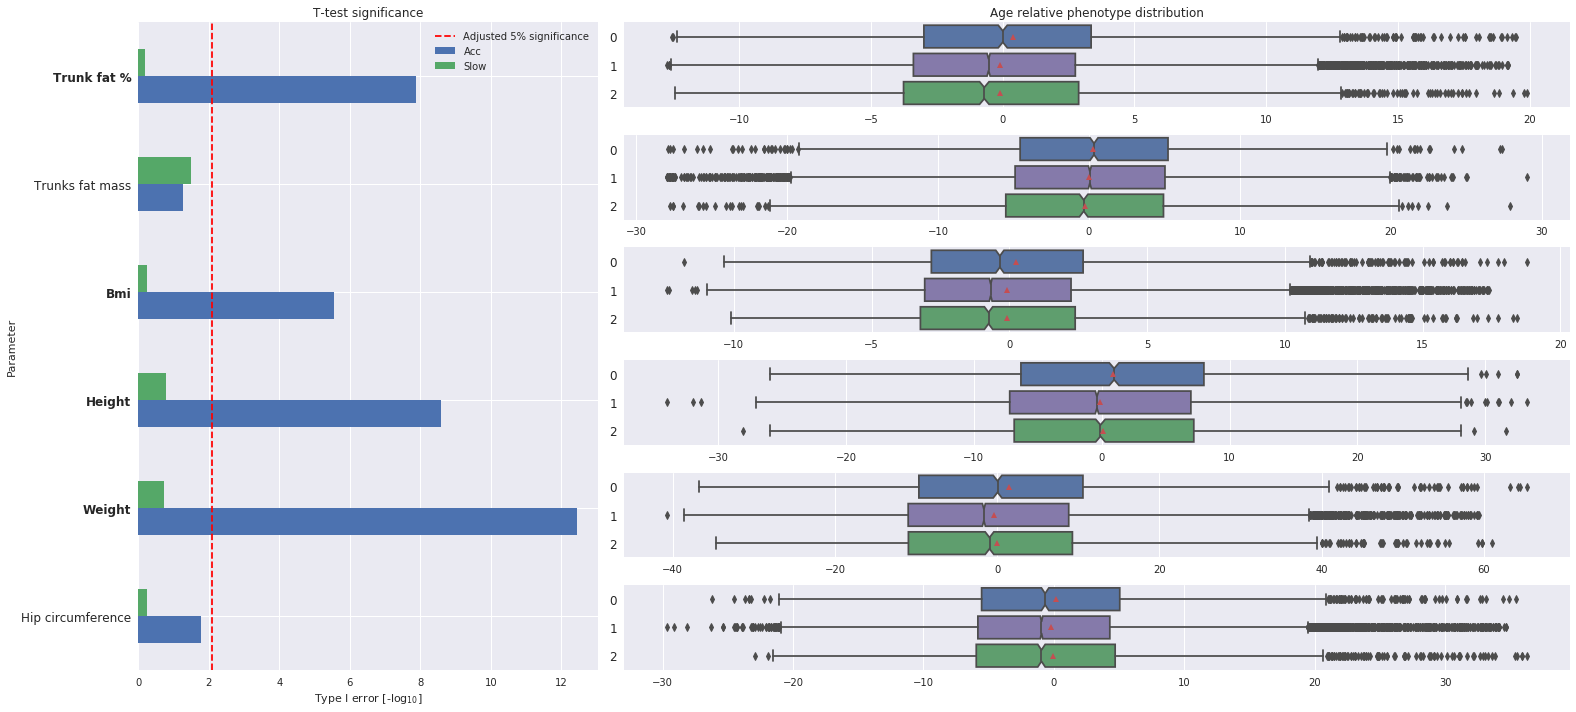

In [285]:
antro = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/Antropometry.p', 'rb'))
antro = pd.concat((antro,preds_corrected[['Residual','Age']]), axis=1)
antro.dropna(subset=['Residual'], inplace=True)
antro.columns = [a.capitalize() for a in antro.columns]
Pred_Age = preds_corrected.loc[antro.index, ['Age','Residual']].dropna()
plot_parameter_t_test(antro, percent = 0.1)

#### Old

In [583]:
antro = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/Antropometry.p', 'rb'))
antro = pd.concat((antro,preds_corrected['Residual']), axis=1)
antro.dropna(subset=['Residual'], inplace=True)
Pred_Age = preds_corrected.loc[antro.index, ['Age','Residual']].dropna()

100%|██████████| 19/19 [06:26<00:00, 20.36s/it]


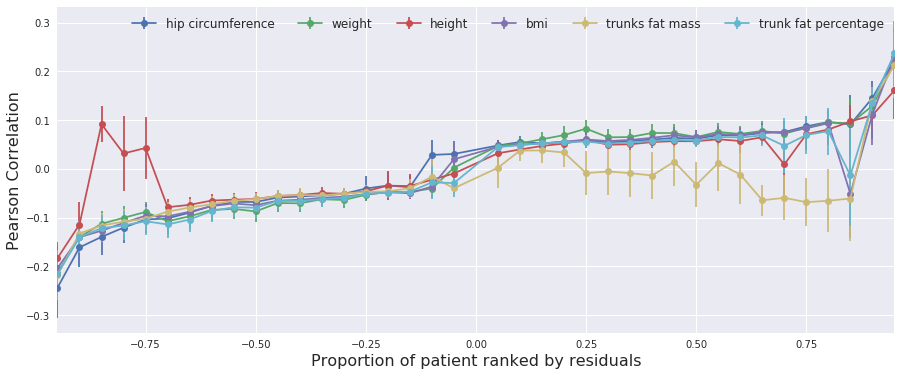

In [584]:
antro = pd.concat((antro,Pred_Age['Age']),join='inner', axis=1)
antro.dropna(subset=['Residual'], inplace=True)
antro.rename(columns={'trunk fat %': 'trunk fat percentage'}, inplace=True)
#get_correlation(antro.copy(), 0.2, Pred_Age.copy(), plot_ResVsRawCondition = False,
#                    plot_ResVsCorrCondition = False, plot_AgeDistrib =False,
#                    plot_top = False, plot_corr_evolution = False)
plot_corr_evolution(antro.copy(),False, True)

In [748]:
def plot_meandiff_evolution(df, sliding_window = False, merged =False):
    
    df_mean_diff_pos= pd.DataFrame() 
    df_mean_diff_pos_signif = pd.DataFrame() 
    df_mean_diff_neg= pd.DataFrame() 
    df_mean_diff_neg_signif = pd.DataFrame() 
    
    if sliding_window:
        window = int(df.shape[0]*sliding_window)
        window_begging = 0
        j=1
        while window_begging < df.shape[0]:
            top_percent_pos = df.sort_values('Residual', ascending=False).iloc[window_begging:window_begging+window]
            top_percent_neg = df.sort_values('Residual', ascending=True).iloc[window_begging:window_begging+window]
            percent = sliding_window*j
            j += 1
            
            for i, col in enumerate(top_percent_pos.drop(columns=['Residual', 'Age']).columns):
                #Positives residuals
                tmp = top_percent_pos[col].dropna()
                not_tmp = df.loc[~df.index.isin(tmp.index), col]
                not_tmp.dropna(inplace=True)

                df_mean_diff_pos.loc[percent, col] = not_tmp.mean() - tmp.mean()

                #Negatives residuals
                tmp = top_percent_neg[col].dropna()
                not_tmp = df.loc[~df.index.isin(tmp.index), col]
                not_tmp.dropna(inplace=True)

                df_mean_diff_neg.loc[percent, col] = not_tmp.mean() - tmp.mean()

            window_begging += window
            
            # plotting
        if merged :
            plt.figure(figsize(15,6))
            df_mean_diff_neg.index= -df_mean_diff_neg.index
            df_corr = pd.concat((df_mean_diff_neg,df_mean_diff_pos),axis=0)
            df_mean_diff_pos.plot(marker='o', yerr = df_mean_diff_pos_err, drawstyle="steps",legend=False)
            plt.xlabel('Proportion of patient ranked by residuals')
        else:
            fig, axes = plt.subplots(1,2, figsize=(20,8), sharey='row', sharex=False)#, sharex='col')
            #(ax1, ax2, ax3, ax4) = axes.flatten()
            (ax1, ax2) = axes.flatten()
            df_mean_diff_pos.plot(ax=ax1, marker='o', yerr = df_mean_diff_pos_err, drawstyle="steps",legend=False)
            df_mean_diff_neg.plot(ax=ax2,marker='o', yerr = df_mean_diff_neg_err, drawstyle="steps",legend=False)

            ax1.set_ylabel('Pearson Correlation')
            ax1.set_title('Positive residuals - Slow Agers')
            ax2.set_title('Negative residuals - Accelerated Agers')
            ax2.set_xlim([0,df_mean_diff_pos.index[-1]])
            ax1.set_xlim([0,df_mean_diff_pos.index[-1]])
            ax1.set_xlabel('Top proportion of miss-predicted')
            ax2.set_xlabel('Top proportion of miss-predicted')
    
    else:
        for percent in tqdm(np.arange(0.05,1, 0.05)):
            top_percent_pos = df.sort_values('Residual', ascending=False).iloc[:int(percent*df.shape[0])]
            top_percent_neg = df.sort_values('Residual', ascending=True).iloc[:int(percent*df.shape[0])]
            

            for i, col in enumerate(top_percent_pos.drop(columns=('Residual')).columns):
                #Positives residuals
                tmp = top_percent_pos[col].dropna()
                not_tmp = df.loc[~df.index.isin(tmp.index), col]
                not_tmp.dropna(inplace=True)

                _, p_val = ttest_ind(tmp, not_tmp)#, axis=0)
                if p_val < 0.05:
                    df_mean_diff_pos.loc[percent, col] = not_tmp.mean() - tmp.mean()
                    df_mean_diff_pos_signif.loc[percent, col] = p_val

                else:
                    df_mean_diff_pos.loc[percent, col] = not_tmp.mean() - tmp.mean()
                    df_mean_diff_pos_signif.loc[percent, col] = p_val


                #Negatives residuals
                tmp = top_percent_neg[col].dropna()
                not_tmp = df.loc[~df.index.isin(tmp.index), col]
                not_tmp.dropna(inplace=True)
                
                _, p_val = ttest_ind(tmp, not_tmp)#, axis=0)
                if p_val < 0.05:
                    df_mean_diff_neg.loc[percent, col] = not_tmp.mean() - tmp.mean()
                    df_mean_diff_neg_signif.loc[percent, col] = p_val
                    
                else:
                    df_mean_diff_neg.loc[percent, col] = not_tmp.mean() - tmp.mean()
                    df_mean_diff_neg_signif.loc[percent, col] = p_val

        
        # plotting
        if merged :
            
            fig, ax = plt.subplots(1,1, figsize=(15,6))
            df_mean_diff_pos= df_mean_diff_pos.iloc[::-1]
            df_mean_diff_neg.index= -1+df_mean_diff_neg.index
            df_mean_diff_pos.index= 1-df_mean_diff_pos.index
            df_corr = pd.concat((df_mean_diff_neg,df_mean_diff_pos),axis=0)
            
            df_mean_diff_neg_err.index= -1+df_mean_diff_neg_err.index
            df_mean_diff_pos_err.index= 1-df_mean_diff_pos_err.index
            df_corr_err = pd.concat((df_mean_diff_neg_err,df_mean_diff_pos_err),axis=0)
            
            df_corr.plot(ax=ax, marker='o', yerr = df_corr_err)
            ax.legend(ncol=len(df_corr.columns))
            ax.set_xlabel('Proportion of patient ranked by residuals')
            ax.set_ylabel('Pearson Correlation')

        else:
            fig, axes = plt.subplots(1,2, figsize=(20,8), sharey='row', sharex=False)#, sharex='col')
            #(ax1, ax2, ax3, ax4) = axes.flatten()
            (ax1, ax2) = axes.flatten()
            display(df_mean_diff_pos_signif)
            df_mean_diff_pos_signif.mask(df_mean_diff_pos_signif > 0.05, inplace=True)
            significance = df_mean_diff_pos*(df_mean_diff_pos*df_mean_diff_pos_signif)/(df_mean_diff_pos*df_mean_diff_pos_signif)
            ax1.plot(significance.index, significance, linestyle = 'None',marker='o', color='r')
            df_mean_diff_pos.plot(ax=ax1, legend= False)
            #df_mean_diff_neg_signif.mask(df_mean_diff_pos_signif < 0.05, inplace=True)
            #significance = df_mean_diff_neg*(df_mean_diff_neg*df_mean_diff_neg_signif)/(df_mean_diff_neg*df_mean_diff_neg_signif)
            #ax2.scatter(significance.index, significance, marker='o', color='r')
            
            ax1.set_ylabel('Pearson Correlation')
            ax1.set_title('Positive residuals - Slow Agers')
            ax2.set_title('Negative residuals - Accelerated Agers')
            ax2.set_xlim([0,df_mean_diff_pos.index[-1]])
            ax1.set_xlim([0,df_mean_diff_pos.index[-1]])
            ax1.set_xlabel('Top proportion of miss-predicted')
            ax2.set_xlabel('Top proportion of miss-predicted')
            fig.tight_layout()
    """
    df_count_pos.plot.bar(ax= ax3)
    df_count_neg.plot.bar(ax=ax4, legend= False)
    ax3.set_ylabel('Number of patients')
    ax3.set_xlabel('Top proportion of miss-predicted')
    ax4.set_xlabel('Top proportion of miss-predicted')
    ax3.legend(ncol= len(df_count_pos), bbox_to_anchor= (1.5, 0.0))
    """

100%|██████████| 19/19 [00:01<00:00, 17.29it/s]


hip circumference    weight    height       bmi  trunks fat mass  \
0.05           0.425138  0.210126  0.282372  0.633478         0.710361   
0.10           0.308238  0.051107  0.336338  0.169625         0.124782   
0.15           0.042075  0.006147  0.299744  0.008931         0.721690   
0.20           0.152807  0.048839  0.341057  0.115718         0.935235   
0.25           0.094240  0.021378  0.169920  0.074142         0.964544   
0.30           0.062515  0.006931  0.055145  0.078878         0.815363   
0.35           0.083946  0.067669  0.302971  0.204150         0.638369   
0.40           0.094580  0.057094  0.203332  0.211438         0.918064   
0.45           0.240768  0.258457  0.427052  0.589336         0.794750   
0.50           0.112383  0.102761  0.279247  0.387166         0.907725   
0.55           0.383865  0.556134  0.602262  0.998198         0.805698   
0.60           0.428755  0.959976  0.856997  0.868491         0.925176   
0.65           0.391313  0.885103  0.702468  0.910946         0.979696   
0.70           0.386966  0.912031  0.798701  0.781416         0.909295   
0.75           0.947000  0.031459  0.056444  0.242634         0.993526   
0.80           0.648808  0.029627  0.110252  0.198697         0.527433   
0.85           0.528454  0.028444  0.129521  0.154906         0.212931   
0.90           0.256480  0.069407  0.883208  0.085143         0.057961   
0.95           0.434994  0.095762  0.758464  0.069577         0.303396   

      trunk fat %  
0.05     0.644716  
0.10     0.936005  
0.15     0.153533  
0.20     0.245610  
0.25     0.220227  
0.30     0.128609  
0.35     0.229330  
0.40     0.357757  
0.45     0.726591  
0.50     0.392624  
0.55     0.949209  
0.60     0.848570  
0.65     0.996084  
0.70     0.879083  
0.75     0.224412  
0.80     0.075139  
0.85     0.019921  
0.90     0.021279  
0.95     0.042167

hip circumference    weight  height       bmi  trunks fat mass  \
0.05                NaN       NaN     NaN       NaN              NaN   
0.10                NaN       NaN     NaN       NaN              NaN   
0.15           0.042075  0.006147     NaN  0.008931              NaN   
0.20                NaN  0.048839     NaN       NaN              NaN   
0.25                NaN  0.021378     NaN       NaN              NaN   
0.30                NaN  0.006931     NaN       NaN              NaN   
0.35                NaN       NaN     NaN       NaN              NaN   
0.40                NaN       NaN     NaN       NaN              NaN   
0.45                NaN       NaN     NaN       NaN              NaN   
0.50                NaN       NaN     NaN       NaN              NaN   
0.55                NaN       NaN     NaN       NaN              NaN   
0.60                NaN       NaN     NaN       NaN              NaN   
0.65                NaN       NaN     NaN       NaN              NaN   
0.70                NaN       NaN     NaN       NaN              NaN   
0.75                NaN  0.031459     NaN       NaN              NaN   
0.80                NaN  0.029627     NaN       NaN              NaN   
0.85                NaN  0.028444     NaN       NaN              NaN   
0.90                NaN       NaN     NaN       NaN              NaN   
0.95                NaN       NaN     NaN       NaN              NaN   

      trunk fat %  
0.05          NaN  
0.10          NaN  
0.15          NaN  
0.20          NaN  
0.25          NaN  
0.30          NaN  
0.35          NaN  
0.40          NaN  
0.45          NaN  
0.50          NaN  
0.55          NaN  
0.60          NaN  
0.65          NaN  
0.70          NaN  
0.75          NaN  
0.80          NaN  
0.85     0.019921  
0.90     0.021279  
0.95     0.042167

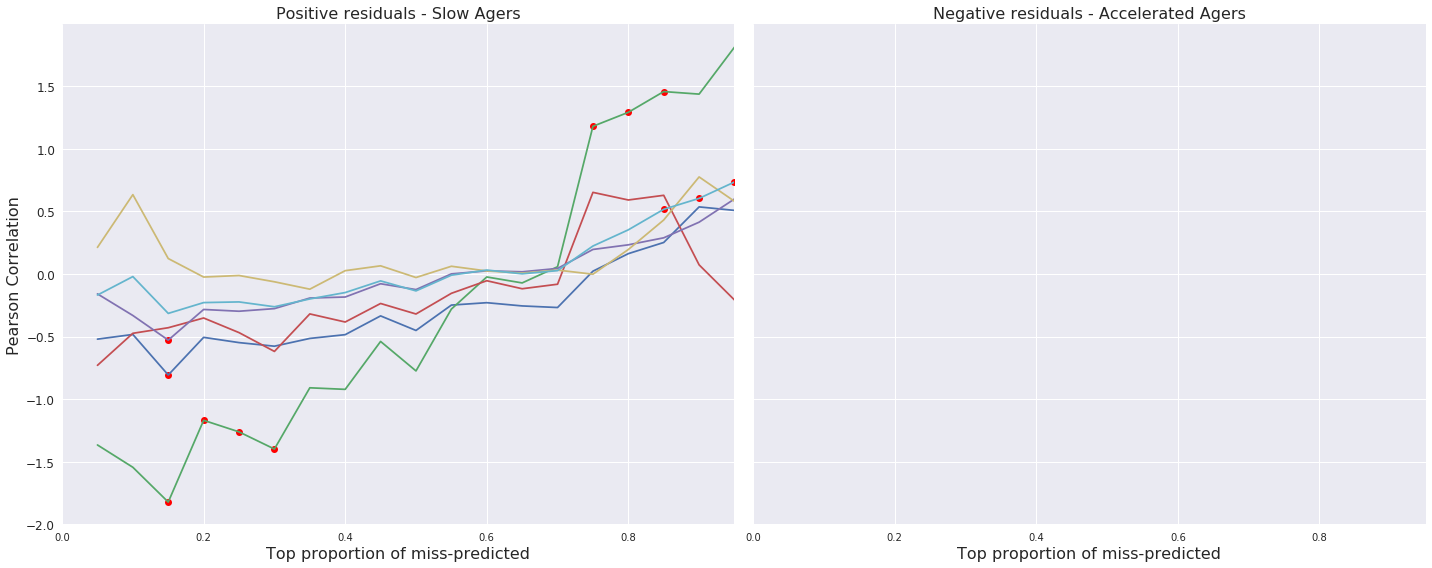

In [749]:
plot_meandiff_evolution(antro, sliding_window = False, merged =False)

In [677]:
a['bmi'].head(10)

eid
1522873    22.3076
3971538    36.5126
5562400    27.2783
2104738    31.9979
2038964    25.1024
4088676    26.5241
3962597    33.1006
3835243    30.3562
1286569    22.1814
5929683    26.4593
Name: bmi, dtype: float64

In [651]:
b['bmi'].var()
a['bmi'].var()

19.67109236318359

## ECG

100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


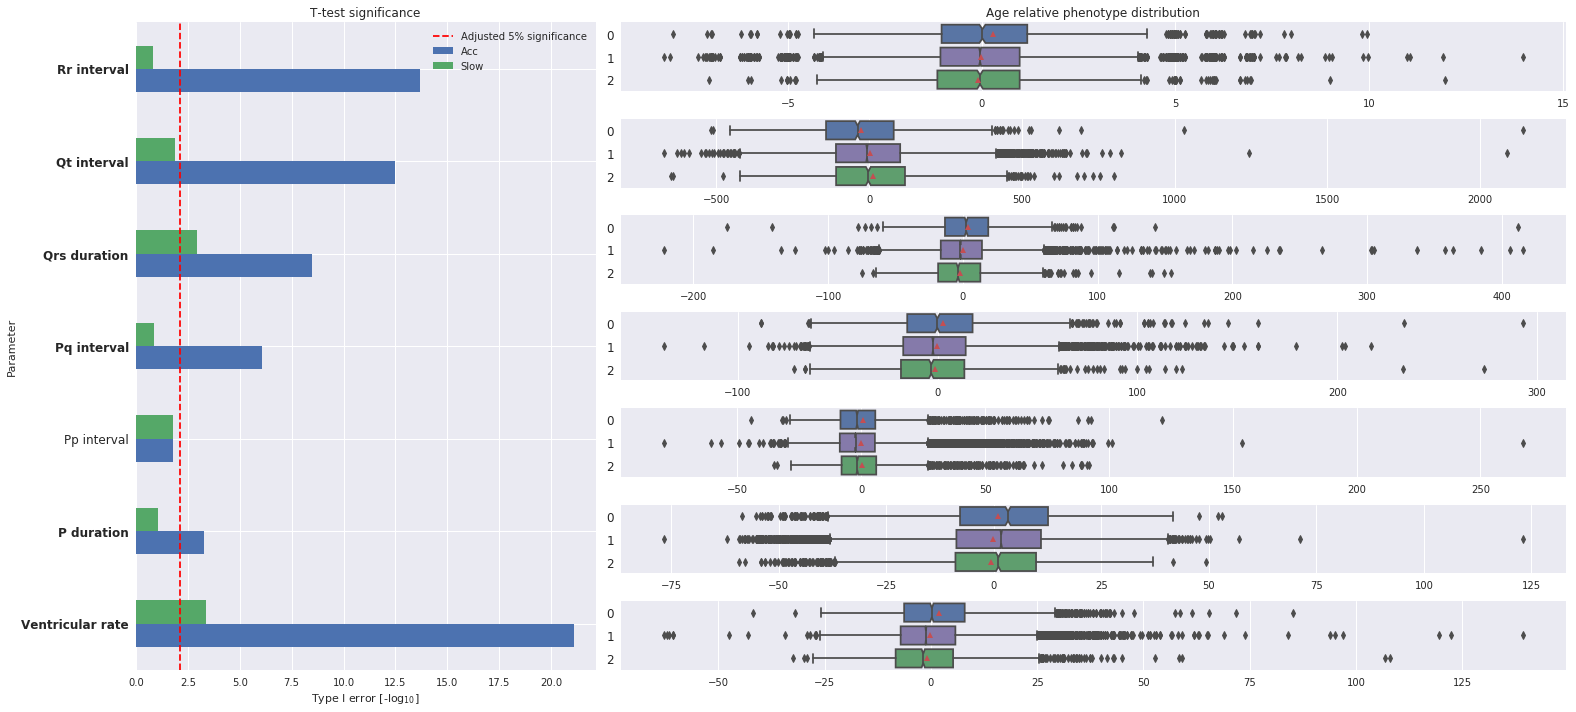

In [280]:
ecg = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/ECG.p', 'rb'))
ecg = ecg.drop(columns=['QTC interval', 'QRS num'])
ecg = pd.concat((ecg,preds_corrected[['Residual','Age']]), axis=1)
ecg.dropna(subset=['Residual'], inplace=True)
ecg.columns = [a.capitalize() for a in ecg.columns]
Pred_Age = preds_corrected.loc[ecg.index, ['Age','Residual']].dropna()
plot_parameter_t_test(ecg, percent = 0.1)

#### Old

In [265]:
ecg = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/ECG.p', 'rb'))

In [208]:
ecg = pd.concat((ecg,preds_corrected['Residual']), axis=1)
ecg.dropna(subset=['Residual'], inplace=True)
Pred_Age = preds_corrected.loc[ecg.index, ['Age','Residual']].dropna()

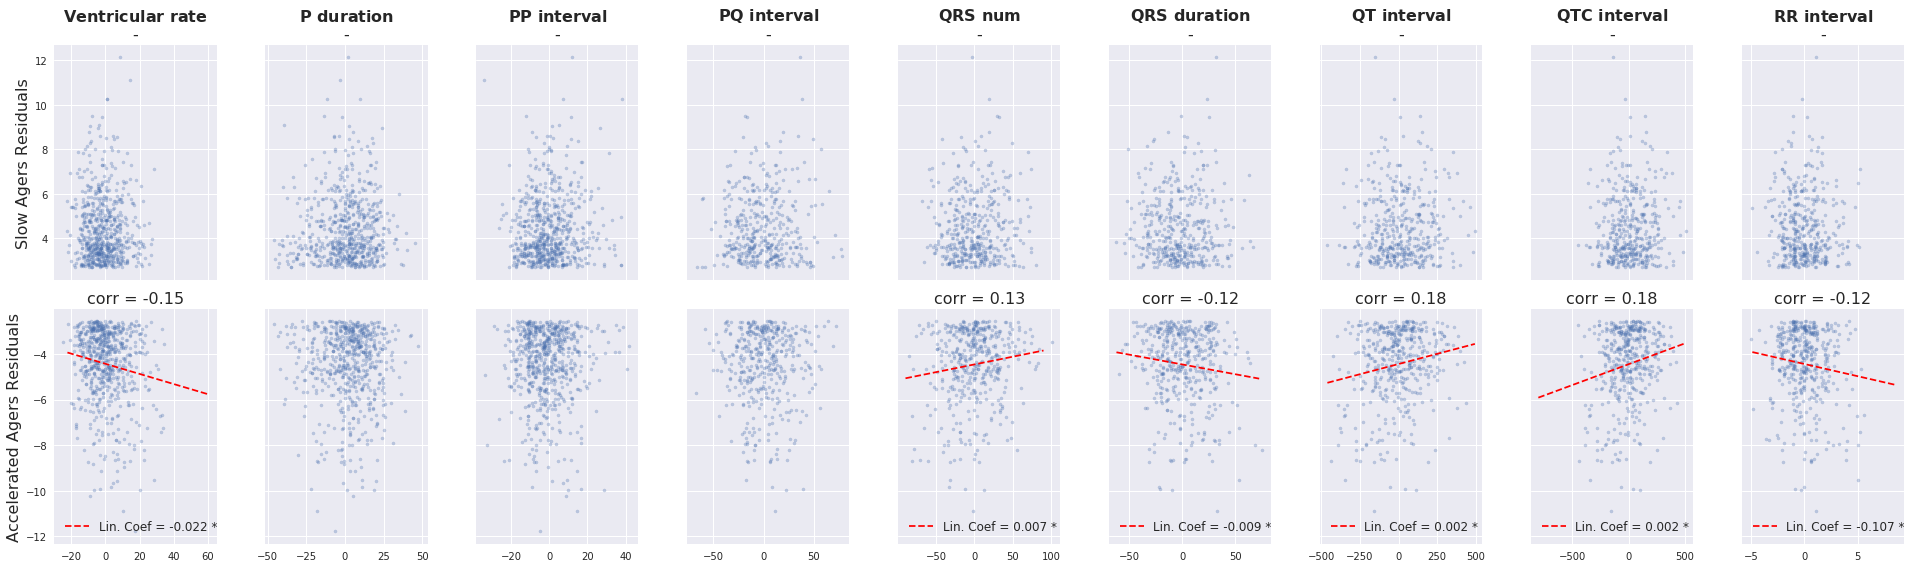

In [209]:
ecg = pd.concat((ecg,Pred_Age['Age']),join='inner', axis=1)
ecg.dropna(subset=['Residual'], inplace=True)
ecg.rename(columns={'trunk fat %': 'trunk fat percentage'}, inplace=True)
get_correlation(ecg.copy(), 0.2, Pred_Age.copy(), plot_ResVsRawCondition = False,
                    plot_ResVsCorrCondition = False, plot_AgeDistrib =False,
                    plot_top = False, plot_corr_evolution = False)

In [65]:
ecg = pd.concat((ecg,preds_corrected['Residual']), axis=1)
ecg.dropna(subset=['Residual'], inplace=True)

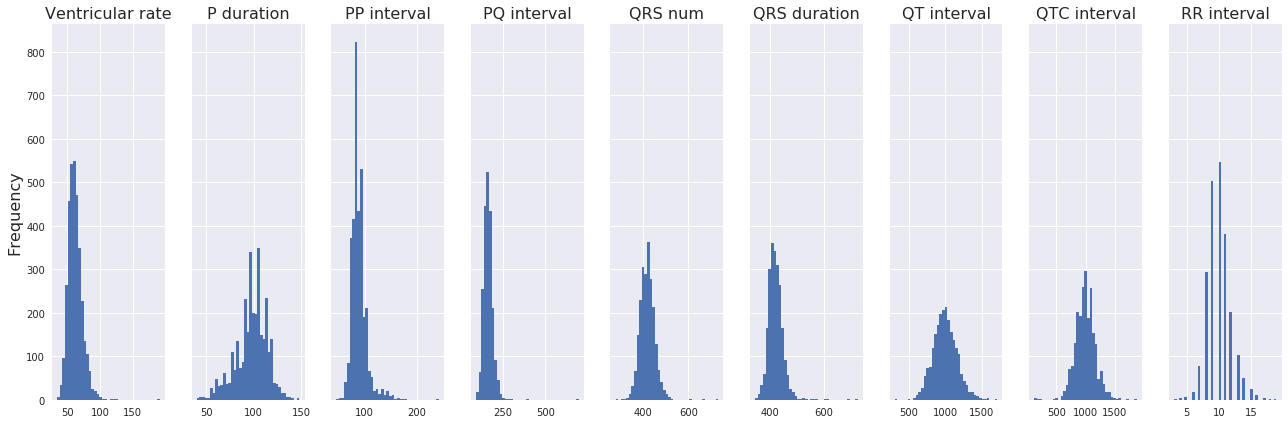

In [68]:
fig, axes = plt.subplots(1,ecg.shape[1]-1, figsize=(18,6), sharey=True)
nbins= int(ecg.shape[0]/100)
for i,col in enumerate(ecg.columns[:-1]):
    axes[i].hist(ecg[col], bins=nbins)
    axes[i].set_title(col[0].upper()+ col[1:])
axes[0].set_ylabel('Frequency')
fig.tight_layout()

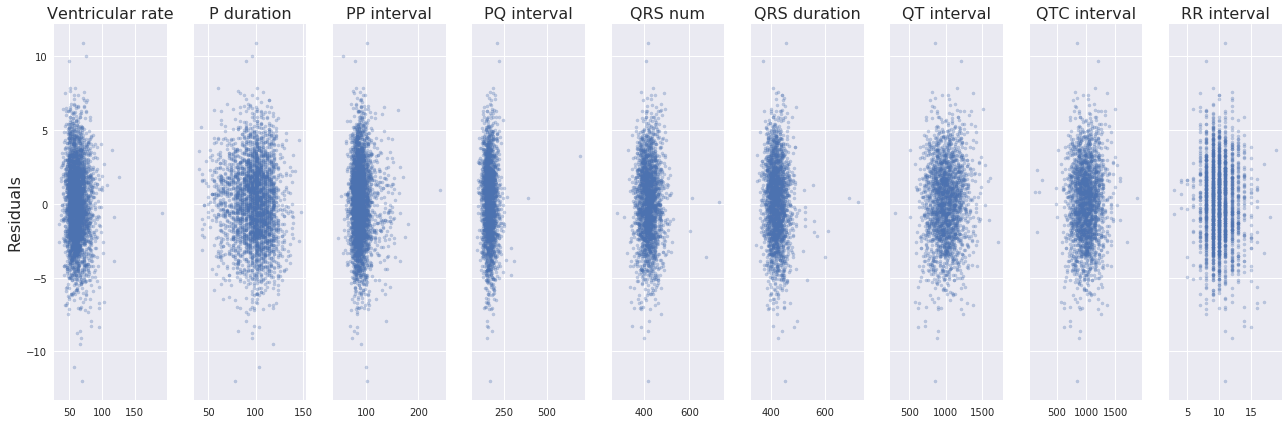

In [77]:
fig, axes = plt.subplots(1,len(ecg.columns[:-2]), figsize=(18,6), sharey=True)
for i,col in enumerate(ecg.columns[:-2]):
    axes[i].scatter(ecg[col],ecg['Residual'], alpha=0.3, s=10)
    tmp = ecg[col].dropna()
    coef, pval = pearsonr(tmp,ecg.loc[tmp.index, 'Residual'])
    axes[i].set_title(col[0].upper()+ col[1:] )#+ ' ' + str(np.round(coef, 3)))
axes[0].set_ylabel('Residuals')
fig.tight_layout()

##### Top misclassified

In [ ]:
get_correlation(df, percent, Pred_Age, plot_ResVsRawCondition = False,
                    plot_ResVsCorrCondition = False, plot_AgeDistrib =False,
                    plot_top = False, plot_corr_evolution = False,
                   plot_TopResVsCorrCondition = True):

In [122]:
percent = 0.1
ecg['Abs Residual'] = abs(ecg.Residual)
#top_percent = ecg.sort_values('Abs Residual', ascending=False).iloc[:int(percent*ecg.shape[0])]
top_percent_pos = ecg.sort_values('Residual', ascending=False).iloc[:int(percent*ecg.shape[0])]
top_percent_neg = ecg.sort_values('Residual', ascending=True).iloc[:int(percent*ecg.shape[0])]
top_percent_pos= top_percent_pos.drop(columns=('Abs Residual'))
top_percent_neg= top_percent_neg.drop(columns=('Abs Residual'))

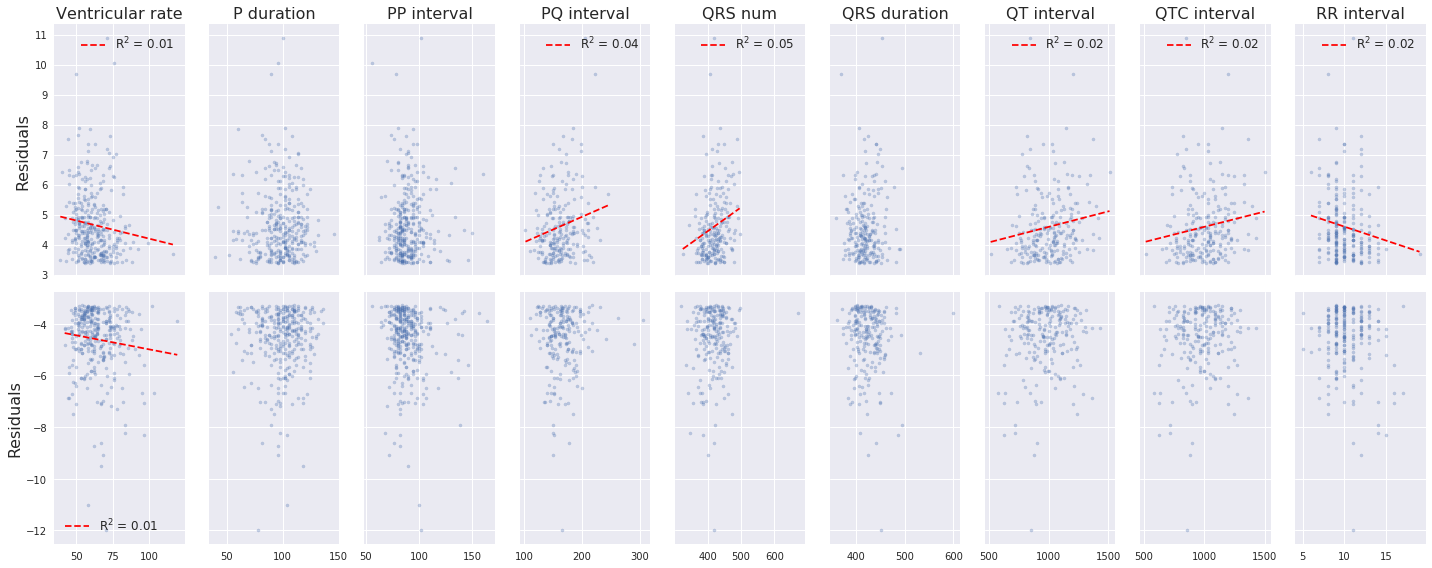

In [123]:
fig, axes = plt.subplots(2,len(ecg.columns[:-2]), figsize=(20,8), sharey='row', sharex='col')
axes = axes.flatten()

df_corr_pos= pd.DataFrame() 
df_corr_neg= pd.DataFrame() 

for i, col in enumerate(top_percent_pos.columns[:-1]):
    #Positives residuals
    axes[i].scatter(top_percent_pos[col],top_percent_pos['Residual'], alpha=0.3, s=10)
    tmp = top_percent_pos[col].dropna()
    coef, pval = pearsonr(tmp,top_percent_pos.loc[tmp.index, 'Residual'])
    axes[i].set_title(col[0].upper()+ col[1:] )#+ ' ' + str(np.round(coef, 3)))
    df_corr_pos.loc[col, 'P-value'] = pval
    df_corr_pos.loc[col, 'Correlation'] = coef
    
    if pval < 0.05:
        reg = LinearRegression().fit(tmp.to_numpy().reshape(-1, 1),
                                     top_percent_pos.loc[tmp.index, 'Residual'].to_numpy().reshape(-1, 1))
        X = np.array([top_percent_pos[col].min(),top_percent_pos[col].max()]).reshape(-1,1)
        axes[i].plot(X, reg.intercept_ + reg.coef_*X, 'r--', label='R$^2$ = {}'.format(np.round(coef*coef, 2)))
        axes[i].legend()
        df_corr_pos.loc[col, 'Linear coefficient'] = reg.coef_

    
    #Negatives residuals
    axes[i+len(ecg.columns[:-2])].scatter(top_percent_neg[col],top_percent_neg['Residual'], alpha=0.3, s=10)
    tmp = top_percent_neg[col].dropna()
    coef, pval = pearsonr(tmp,top_percent_neg.loc[tmp.index, 'Residual'])
    df_corr_neg.loc[col, 'P-value'] = pval
    df_corr_neg.loc[col, 'Correlation'] = coef
    
    if pval < 0.05:
        reg = LinearRegression().fit(tmp.to_numpy().reshape(-1, 1),
                                     top_percent_neg.loc[tmp.index, 'Residual'].to_numpy().reshape(-1, 1))
        X = np.array([top_percent_neg[col].min(),top_percent_neg[col].max()]).reshape(-1,1)
        axes[i+len(ecg.columns[:-2])].plot(X, reg.intercept_ + reg.coef_*X, 'r--', label='R$^2$ = {}'.format(np.round(coef*coef, 2)))
        axes[i+len(ecg.columns[:-2])].legend()
        df_corr_neg.loc[col, 'Linear coefficient'] = reg.coef_

        
axes[0].set_ylabel('Residuals')
axes[len(ecg.columns[:-2])].set_ylabel('Residuals')
fig.tight_layout()

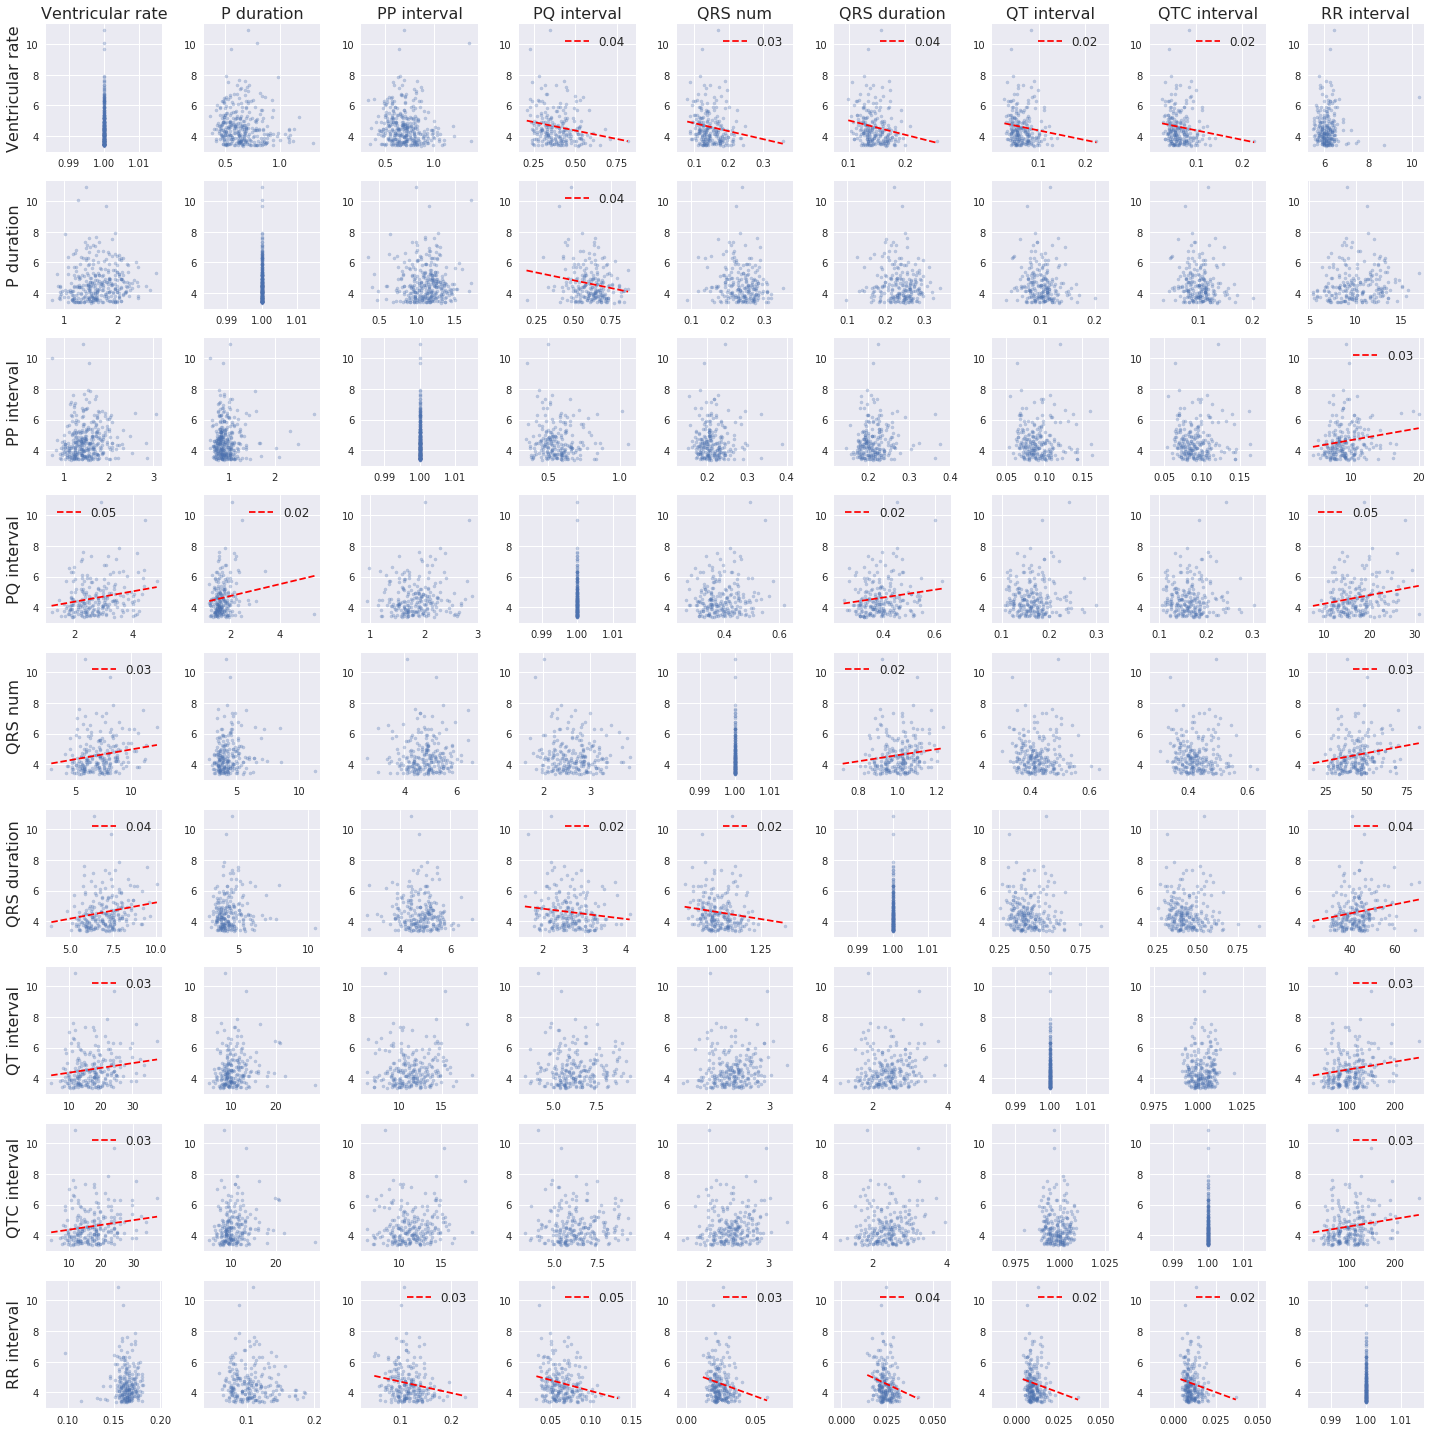

In [161]:
fig, axes = plt.subplots(len(ecg.columns[:-2]),len(ecg.columns[:-2]), figsize=(20,20)) #, sharey='row', sharex='col')
axes = axes.flatten()

df_corr_pos= pd.DataFrame() 
df_corr_neg= pd.DataFrame() 

p = 0
for i, col in enumerate(top_percent_pos.columns[:-1]):
    axes[i].set_title(col[0].upper()+ col[1:] )
    for j, colj in enumerate(top_percent_pos.columns[:-1]):
    #Positives residuals
        X =  top_percent_pos[col]/top_percent_pos[colj]
        axes[p].scatter(X,top_percent_pos['Residual'], alpha=0.3, s=10)
        tmp = X.dropna()
        coef, pval = pearsonr(tmp,top_percent_pos.loc[tmp.index, 'Residual'])
        #axes[p].set_title(col[0].upper()+ col[1:] +'/'+colj[0].upper()+ colj[1:] )#+ ' ' + str(np.round(coef, 3)))
        
        df_corr_pos.loc[col, 'P-value'] = pval
        df_corr_pos.loc[col, 'Correlation'] = coef

        if pval < 0.05:
            reg = LinearRegression().fit(tmp.to_numpy().reshape(-1, 1),
                                         top_percent_pos.loc[tmp.index, 'Residual'].to_numpy().reshape(-1, 1))
            X = np.array([X.min(), X.max()]).reshape(-1,1)
            axes[p].plot(X, reg.intercept_ + reg.coef_*X, 'r--', label='{}'.format(np.round(coef*coef, 2)))
            axes[p].legend()
            df_corr_pos.loc[col, 'Linear coefficient'] = reg.coef_
            
        if p%len(ecg.columns[:-2]) ==0:
            axes[p].set_ylabel(col[0].upper()+ col[1:])
        p+=1

fig.tight_layout()

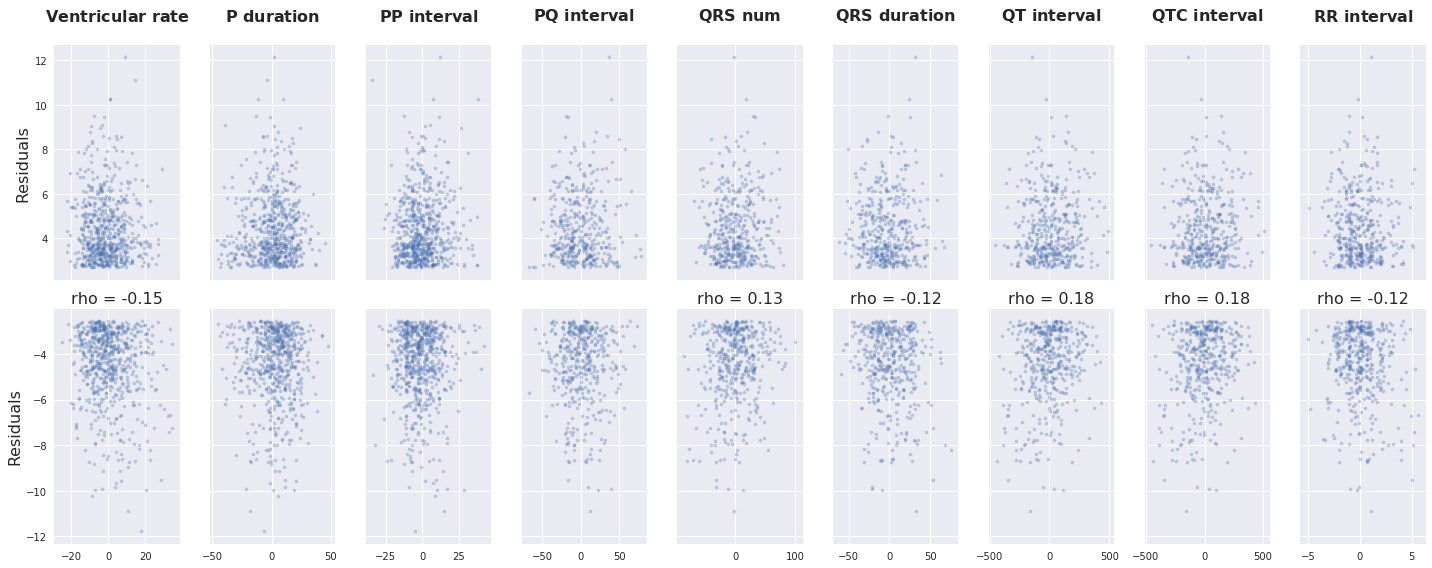

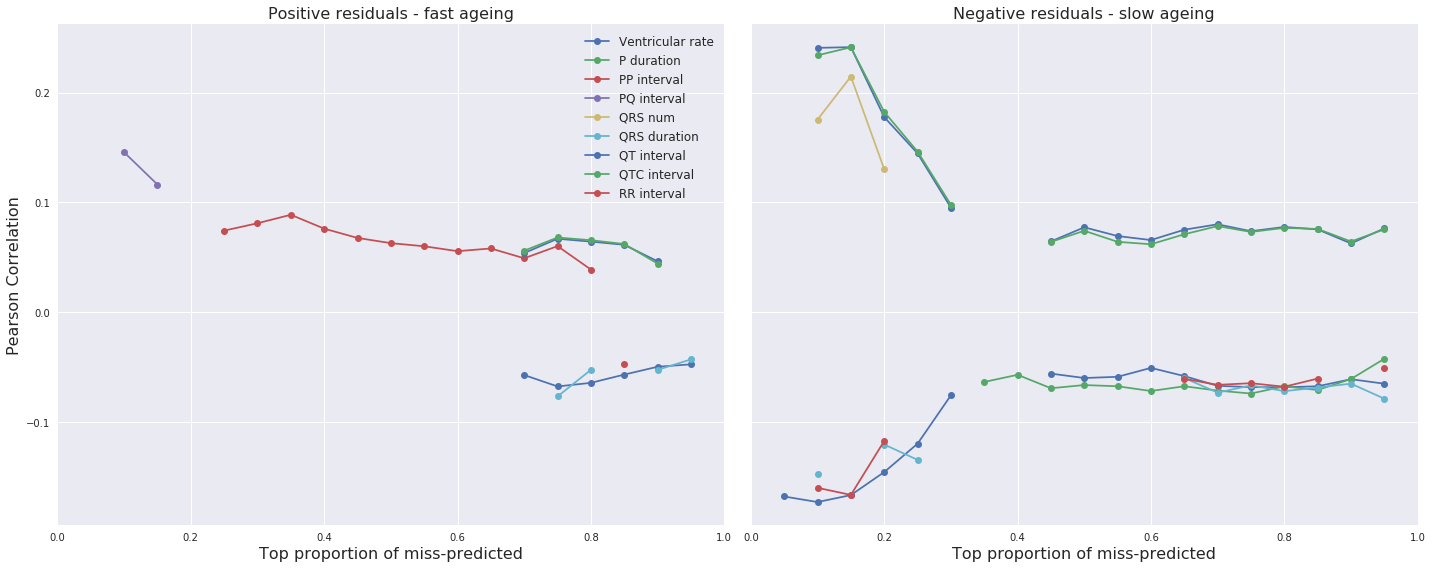

In [213]:
ecg = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/ECG.p', 'rb'))

ecg = pd.concat((ecg,preds_corrected['Residual']), axis=1)
ecg.dropna(subset=['Residual'], inplace=True)
Pred_Age = preds_corrected.loc[ecg.index, ['Age','Residual']].dropna()
ecg = pd.concat((ecg,Pred_Age['Age']),join='inner', axis=1)
ecg.dropna(subset=['Residual'], inplace=True)
ecg.rename(columns={'trunk fat %': 'trunk fat percentage'}, inplace=True)
get_correlation(ecg.copy(), 0.2, Pred_Age, plot_ResVsConditions = False,
                    plot_top = False, plot_corr_evolution= True )

## Left Ventricular Function

100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


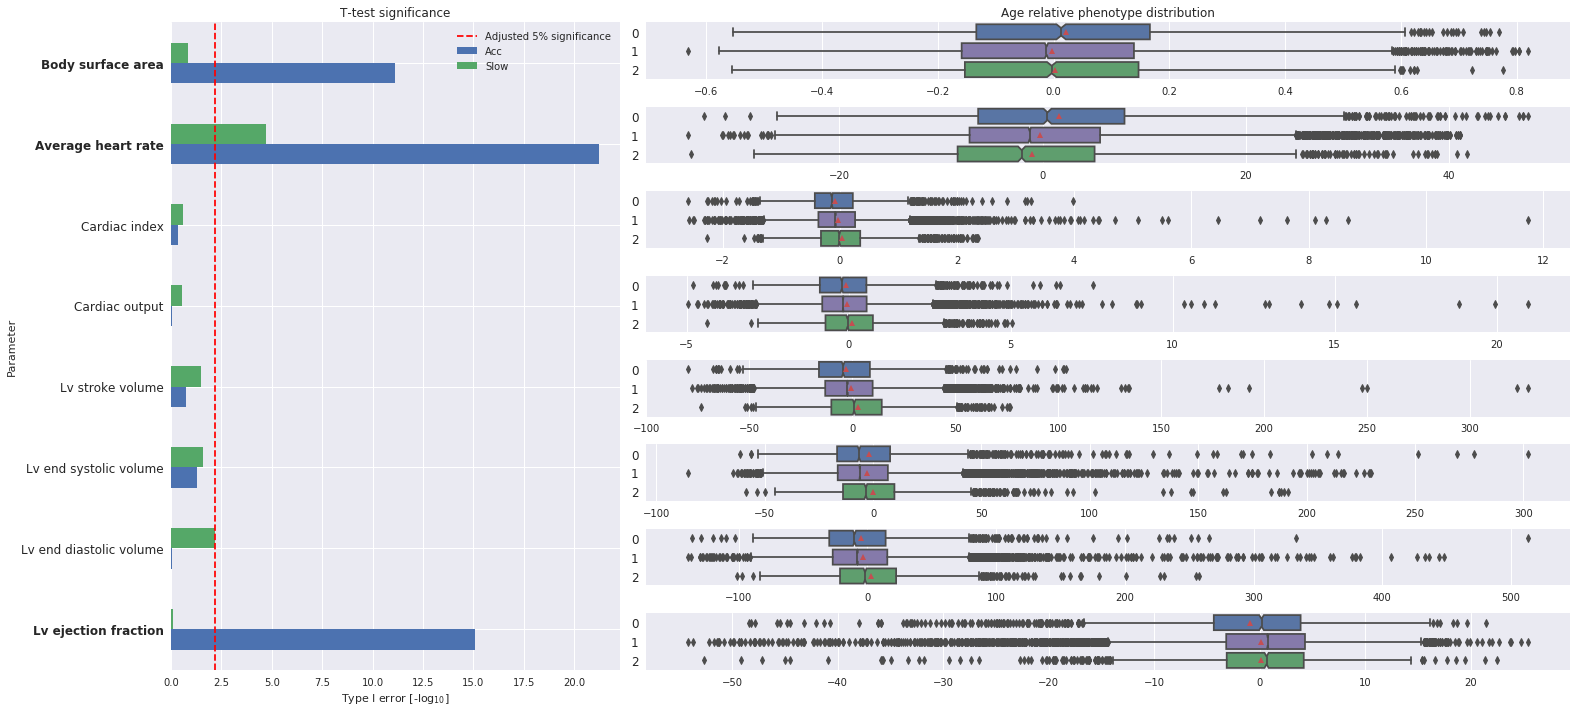

In [286]:
lf = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/LVfunction.p', 'rb'))
lf = pd.concat((lf,preds_corrected[['Residual','Age']]), axis=1)
lf.dropna(subset=['Residual'], inplace=True)
lf.columns = [a.capitalize() for a in lf.columns]
Pred_Age = preds_corrected.loc[lf.index, ['Age','Residual']].dropna()
plot_parameter_t_test(lf, percent = 0.1)


#### Old

In [222]:
lf = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/LVfunction.p', 'rb'))

In [223]:
lf = pd.concat((lf,preds_corrected['Residual']), axis=1)
lf.dropna(subset=['Residual'], inplace=True)
Pred_Age = preds_corrected.loc[lf.index, ['Age','Residual']].dropna()

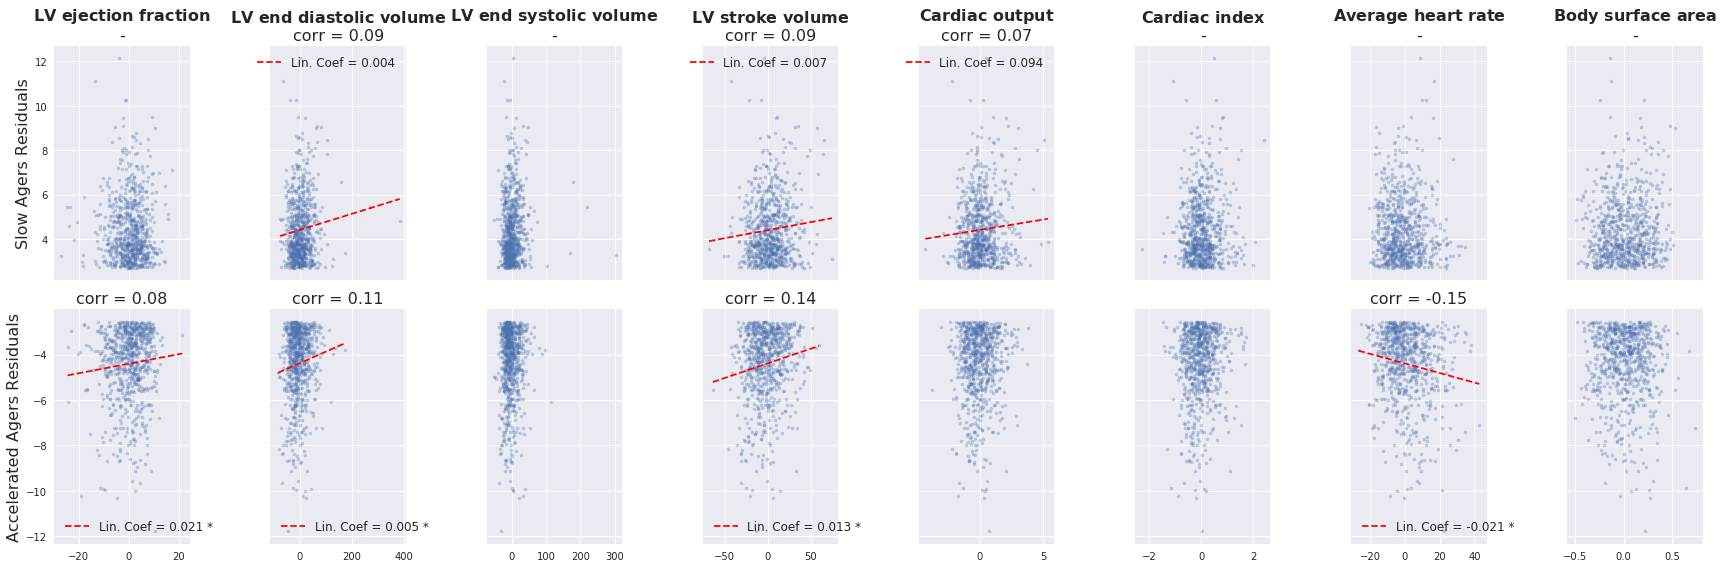

In [224]:
lf = pd.concat((lf,Pred_Age['Age']),join='inner', axis=1)
lf.dropna(subset=['Residual'], inplace=True)
lf.rename(columns={'trunk fat %': 'trunk fat percentage'}, inplace=True)
get_correlation(lf.copy(), 0.2, Pred_Age.copy(), plot_ResVsRawCondition = False,
                    plot_ResVsCorrCondition = False, plot_AgeDistrib =False,
                    plot_top = False, plot_corr_evolution = False)

##### Top misclassified

In [111]:
percent = 0.1
lf['Abs Residual'] = abs(lf.Residual)
#top_percent = lf.sort_values('Abs Residual', ascending=False).iloc[:int(percent*lf.shape[0])]
top_percent_pos = lf.sort_values('Residual', ascending=False).iloc[:int(percent*lf.shape[0])]
top_percent_neg = lf.sort_values('Residual', ascending=True).iloc[:int(percent*lf.shape[0])]
top_percent_pos= top_percent_pos.drop(columns=('Abs Residual'))
top_percent_neg= top_percent_neg.drop(columns=('Abs Residual'))

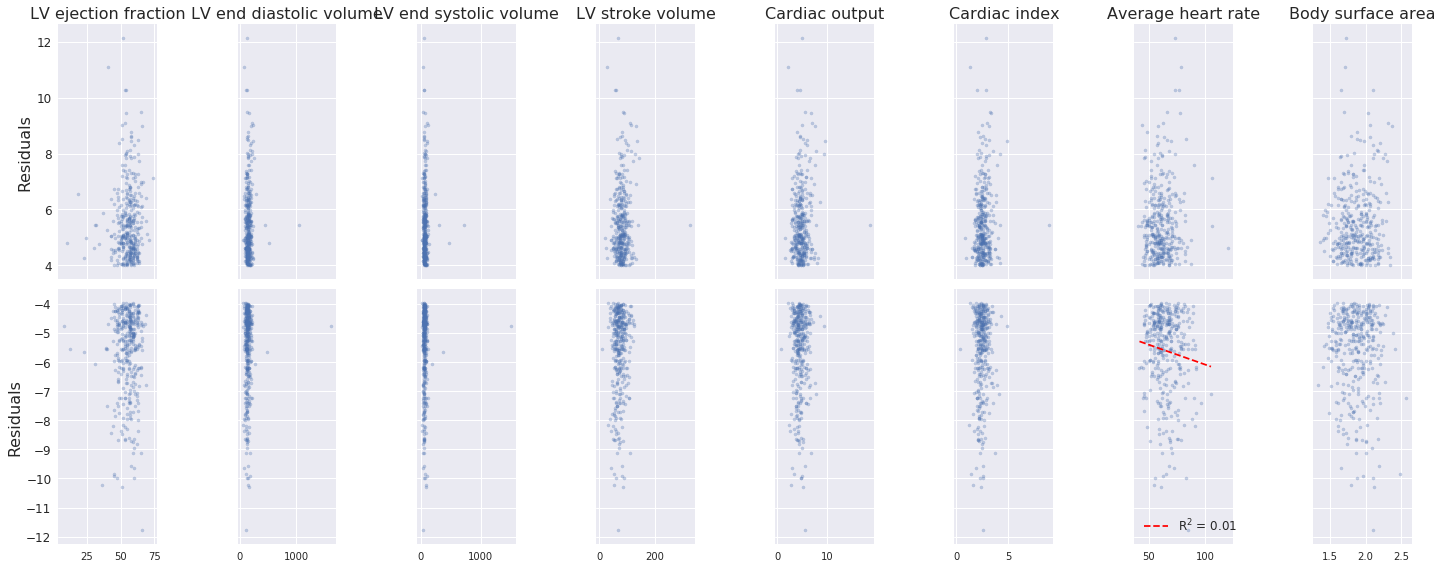

In [112]:
fig, axes = plt.subplots(2,len(lf.columns[:-2]), figsize=(20,8), sharey='row', sharex='col')
axes = axes.flatten()

df_corr_pos= pd.DataFrame() 
df_corr_neg= pd.DataFrame() 

for i, col in enumerate(top_percent_pos.columns[:-1]):
    #Positives residuals
    axes[i].scatter(top_percent_pos[col],top_percent_pos['Residual'], alpha=0.3, s=10)
    tmp = top_percent_pos[col].dropna()
    coef, pval = pearsonr(tmp,top_percent_pos.loc[tmp.index, 'Residual'])
    axes[i].set_title(col[0].upper()+ col[1:] )#+ ' ' + str(np.round(coef, 3)))
    df_corr_pos.loc[col, 'P-value'] = pval
    df_corr_pos.loc[col, 'Correlation'] = coef
    
    if pval < 0.05:
        reg = LinearRegression().fit(tmp.to_numpy().reshape(-1, 1),
                                     top_percent_pos.loc[tmp.index, 'Residual'].to_numpy().reshape(-1, 1))
        X = np.array([top_percent_pos[col].min(),top_percent_pos[col].max()]).reshape(-1,1)
        axes[i].plot(X, reg.intercept_ + reg.coef_*X, 'r--', label='R$^2$ = {}'.format(np.round(coef*coef, 2)))
        axes[i].legend()
        df_corr_pos.loc[col, 'Linear coefficient'] = reg.coef_

    
    #Negatives residuals
    axes[i+len(lf.columns[:-2])].scatter(top_percent_neg[col],top_percent_neg['Residual'], alpha=0.3, s=10)
    tmp = top_percent_neg[col].dropna()
    coef, pval = pearsonr(tmp,top_percent_neg.loc[tmp.index, 'Residual'])
    df_corr_neg.loc[col, 'P-value'] = pval
    df_corr_neg.loc[col, 'Correlation'] = coef
    
    if pval < 0.05:
        reg = LinearRegression().fit(tmp.to_numpy().reshape(-1, 1),
                                     top_percent_neg.loc[tmp.index, 'Residual'].to_numpy().reshape(-1, 1))
        X = np.array([top_percent_neg[col].min(),top_percent_neg[col].max()]).reshape(-1,1)
        axes[i+len(lf.columns[:-2])].plot(X, reg.intercept_ + reg.coef_*X, 'r--', label='R$^2$ = {}'.format(np.round(coef*coef, 2)))
        axes[i+len(lf.columns[:-2])].legend()
        df_corr_neg.loc[col, 'Linear coefficient'] = reg.coef_

        
axes[0].set_ylabel('Residuals')
axes[len(lf.columns[:-2])].set_ylabel('Residuals')
fig.tight_layout()

In [220]:
df = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/LVfunction.p', 'rb'))
df.dropna(how='all', inplace=True)
Pred_Age = preds_corrected.loc[df.index, ['Age','Residual']].dropna()
percent = 0.2
df = pd.concat((df,Pred_Age),join='inner', axis=1)
df.dropna(subset=['Residual'], inplace=True)
df.rename(columns={'LV ejection fraction': 'LV ejection frac',
                   'LV end diastolic volume': 'LV end disatolic vol', 
                   'LV end systolic volume': 'LV end systolic vol',
                   'LV stroke volume': 'LV stroke vol' }, inplace=True)

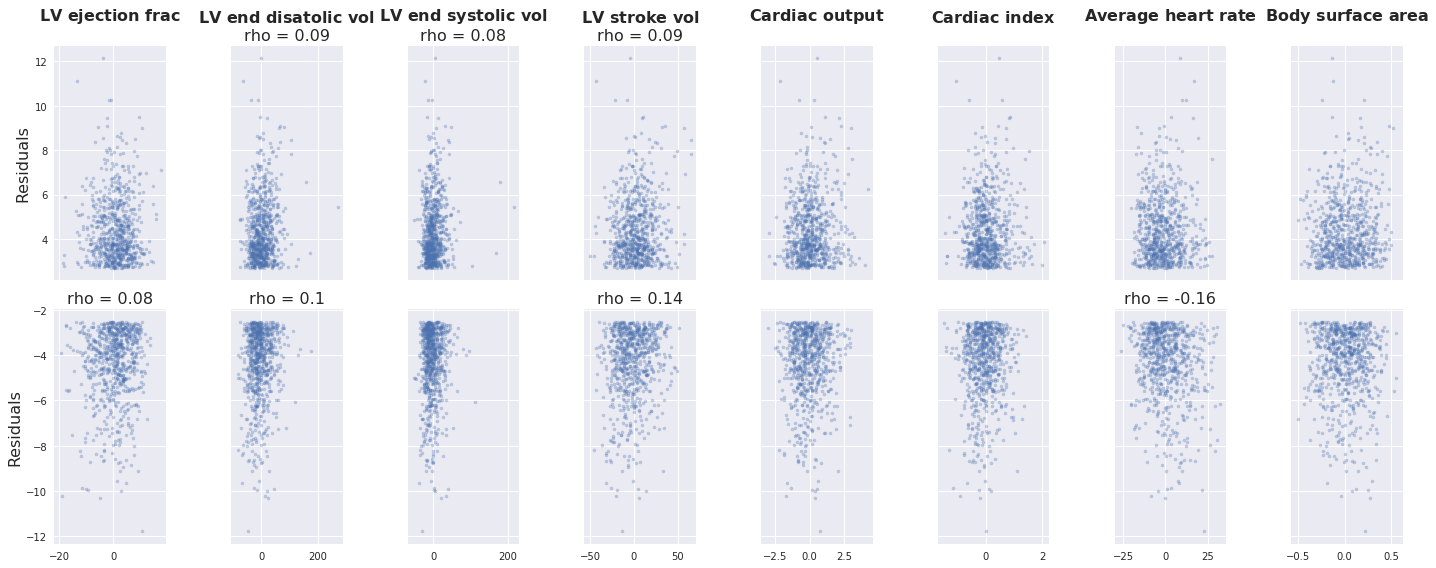

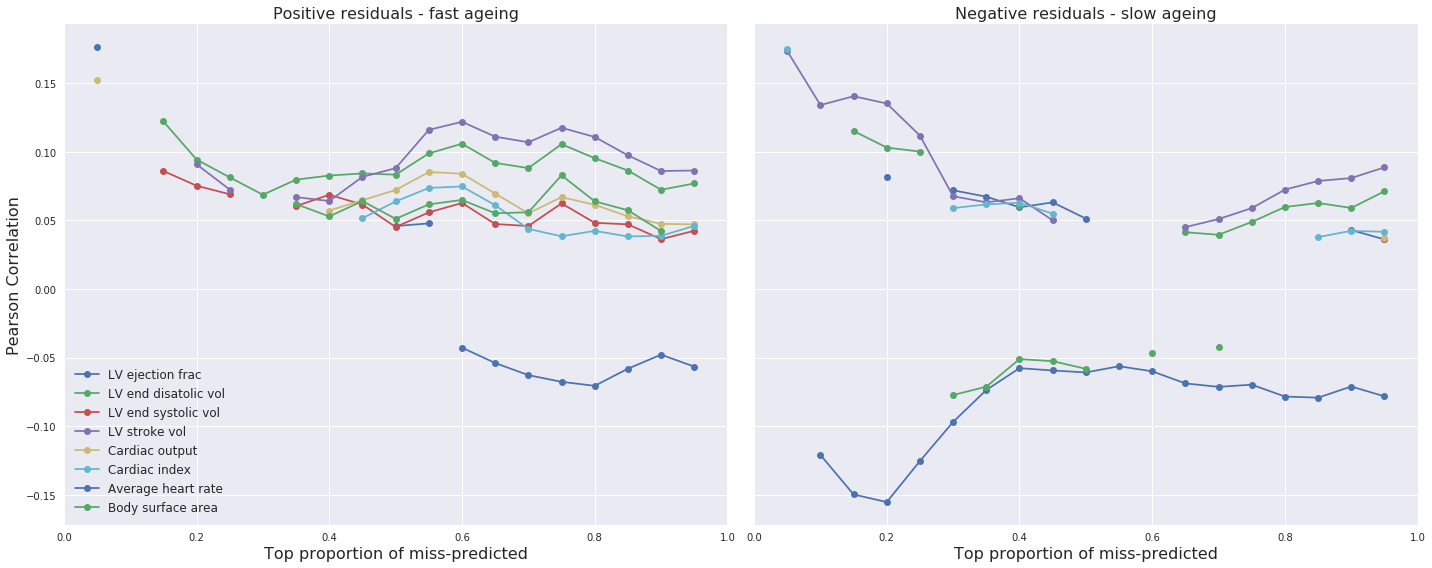

In [221]:
get_correlation(df, percent, Pred_Age, plot_ResVsConditions = False,
                    plot_top = False, plot_corr_evolution= True )

In [114]:
df_corr_pos= pd.DataFrame() 
df_corr_neg= pd.DataFrame() 
for percent in np.arange(0.05,1, 0.05):
    top_percent_pos = df.sort_values('Residual', ascending=False).iloc[:int(percent*df.shape[0])]
    top_percent_neg = df.sort_values('Residual', ascending=True).iloc[:int(percent*df.shape[0])]

    for i, col in enumerate(top_percent_pos.columns[:-2]):
        #Positives residuals
        tmp = top_percent_pos[col].dropna()
        tmp = tmp[(np.abs(zscore(tmp)) < 3)]
        coef, pval = pearsonr(tmp,top_percent_pos.loc[tmp.index, 'Residual'])
        if pval < 0.05:
            df_corr_pos.loc[percent, col] = coef
        else:
            df_corr_pos.loc[percent, col] = np.nan

        #Negatives residuals
        tmp = top_percent_neg[col].dropna()
        tmp = tmp[(np.abs(zscore(tmp)) < 3)]
        coef, pval = pearsonr(tmp,top_percent_neg.loc[tmp.index, 'Residual'])
        if pval < 0.05:
            df_corr_neg.loc[percent, col] = coef
        else:
            df_corr_neg.loc[percent, col] = np.nan

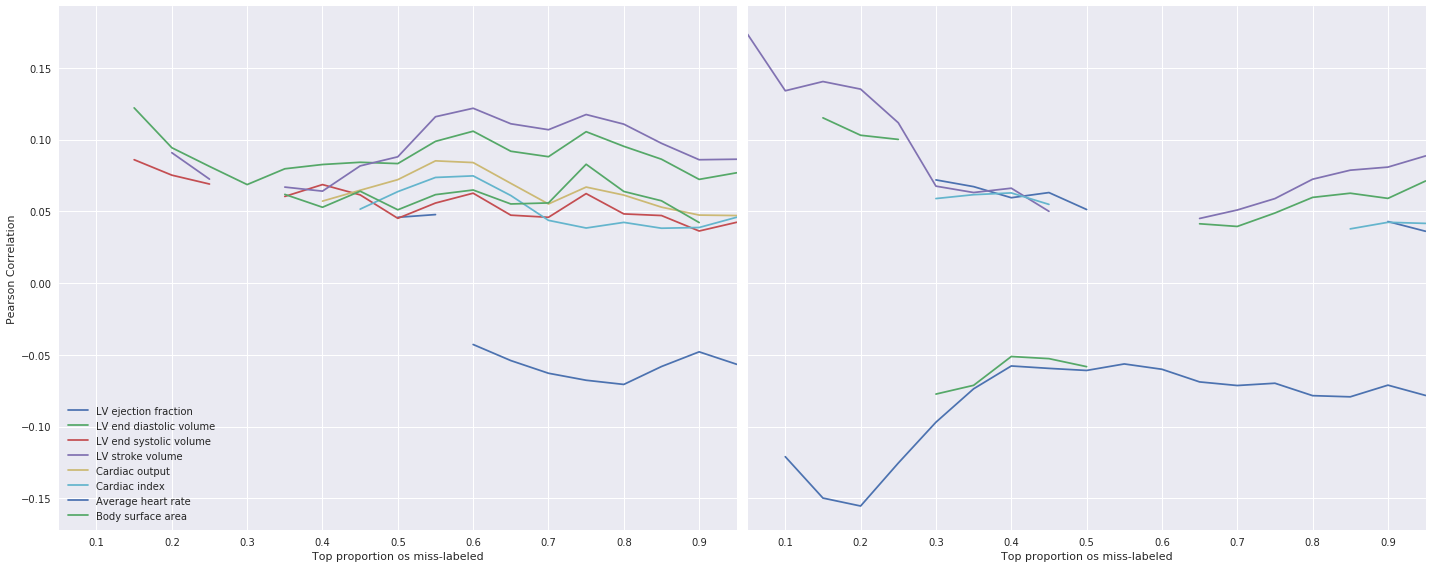

In [115]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8), sharey=True)#, sharex='col')
df_corr_pos.plot(ax=ax1)
df_corr_neg.plot(ax=ax2, legend=False)
ax1.set_ylabel('Pearson Correlation')
ax1.set_xlabel('Top proportion os miss-labeled')
ax2.set_xlabel('Top proportion os miss-labeled')

fig.tight_layout()

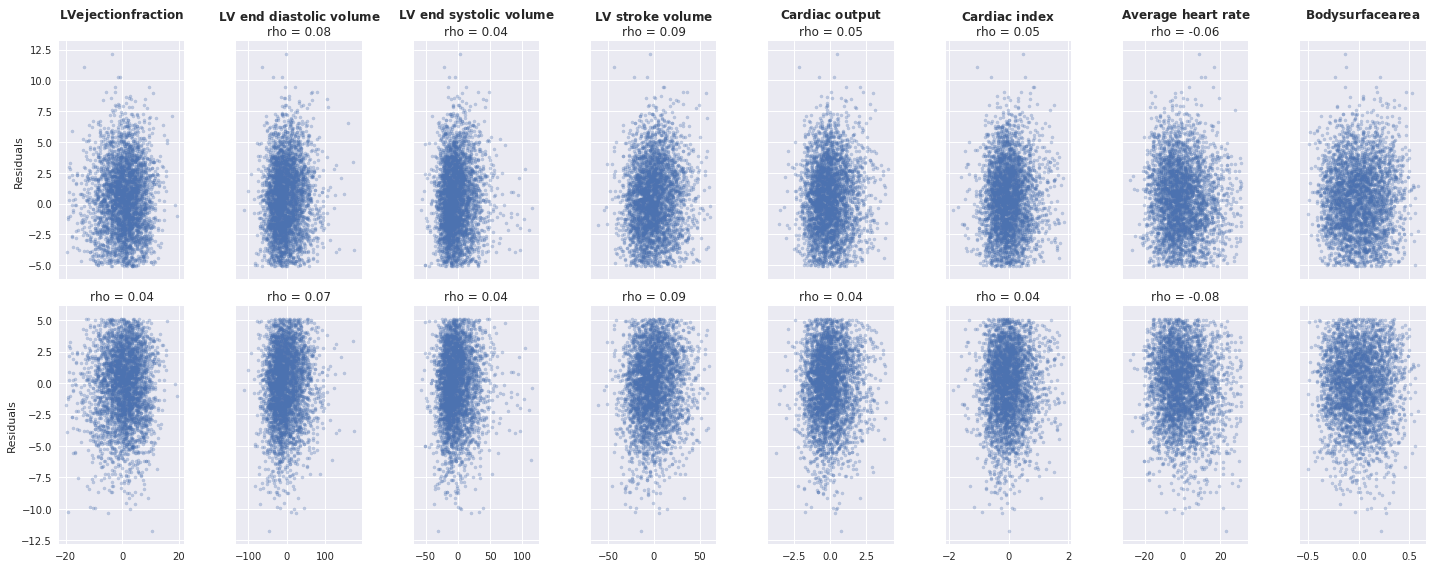

In [117]:
fig, axes = plt.subplots(2,len(df.columns[:-2]), figsize=(20,8), sharey='row', sharex='col')
axes = axes.flatten()
percent=0.1
for i, col in enumerate(top_percent_pos.columns[:-2]):
    #Positives residuals
    tmp = top_percent_pos[col].dropna()
    tmp = tmp[(np.abs(zscore(tmp)) < 3)]
    axes[i].scatter(top_percent_pos.loc[tmp.index,col],top_percent_pos.loc[tmp.index,'Residual'], alpha=0.3, s=10)
    coef, pval = pearsonr(tmp,top_percent_pos.loc[tmp.index, 'Residual'])
    df_corr_pos.loc[col, 'P-value'] = pval
    df_corr_pos.loc[col, 'Correlation'] = coef

    if pval < 0.05:
        axes[i].set_title( r"$\bf{" +(col[0].upper()+ col[1:]).replace(' ', ' \\ ') +r'}$'+ '\nrho = {}'.format(np.round(coef, 2) ))
    else:
        axes[i].set_title( r"$\bf{" +col[0].upper()+ col[1:] +r'}$'+ '\n' )

    #Negatives residuals
    tmp = top_percent_neg[col].dropna()
    tmp = tmp[(np.abs(zscore(tmp)) < 3)]
    coef, pval = pearsonr(tmp,top_percent_neg.loc[tmp.index, 'Residual'])
    df_corr_neg.loc[col, 'P-value'] = pval
    df_corr_neg.loc[col, 'Correlation'] = coef

    if pval < 0.05:
        label = 'rho = {}'.format(np.round(coef, 2))
        axes[i+len(df.columns[:-2])].scatter(top_percent_neg.loc[tmp.index,col],
                                             top_percent_neg.loc[tmp.index,'Residual'],
                                             alpha=0.3, s=10,
                                             label = label)
        axes[i+len(df.columns[:-2])].set_title(label)
    else:
        axes[i+len(df.columns[:-2])].scatter(top_percent_neg.loc[tmp.index,col],
                                             top_percent_neg.loc[tmp.index,'Residual'],
                                             alpha=0.3, s=10)
axes[0].set_ylabel('Residuals')
axes[len(df.columns[:-2])].set_ylabel('Residuals')
fig.tight_layout()

## LVF and ECG

In [221]:
def get_t_test_phenotype(df, percent = 0.1, age_normalization =True):
    """
    df : all patient dataframe. True in the column of df or Nan.
    """
    # --- Correcting phenotypes per age ---
    if age_normalization : 
        df_mean = df.drop(columns='Residual').groupby('Age').mean()
        df_mean['Residual'] =0
        df_mean['Age'] =0
        for age in df.Age.unique():
            df[df.Age==age] -= df_mean.loc[age,]
    
    # --- Definies the group ---
    df_acc = df.sort_values('Residual', ascending=True).\
                    iloc[:int(percent*df.shape[0])]
    df_slow = df.sort_values('Residual', ascending=False).\
                iloc[:int(percent*df.shape[0])]
    idx_agers = df_acc.index.tolist() +df_slow.index.tolist()
    df = df.loc[~df.index.isin(idx_agers)]

    # --- Residuals associated with each patient suffering from a certain CVD  ---
    df_p_val = pd.DataFrame()
    df_fold_change = pd.DataFrame() 
    for col in tqdm(df.drop(columns=['Residual', 'Age']).columns):
        #positive
        tmp = df_acc[col]
        tmp.dropna(inplace=True)
        not_tmp = df[col]
        not_tmp.dropna(inplace=True)
        _, p_val = ttest_ind(tmp, not_tmp)#, axis=0)
        df_p_val.loc[col,'Accelerated Agers'] = p_val
        df_fold_change.loc[col,'Accelerated Agers'] = (tmp.mean() - not_tmp.mean()) / not_tmp.mean()
        #negative
        tmp = df_slow[col]
        tmp.dropna(inplace=True)
        _, p_val = ttest_ind(tmp, not_tmp)#, axis=0)
        df_p_val.loc[col,'Slow Agers'] = p_val
        df_fold_change.loc[col,'Slow Agers'] = (tmp.mean() - not_tmp.mean()) / not_tmp.mean()
    
    df_p_val = -np.log10(df_p_val)
    
    return df_p_val, df_fold_change


In [222]:
lf = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/LVfunction.p', 'rb'))
lf = pd.concat((lf,preds_corrected[['Residual','Age']]), axis=1)
lf.dropna(subset=['Residual'], inplace=True)
lf.columns = [a.capitalize() for a in lf.columns]

ecg = pickle.load(open('/n/groups/patel/JbProst/Heart/Data/ECG.p', 'rb'))
ecg = ecg.drop(columns=['QTC interval', 'QRS num'])
ecg = pd.concat((ecg,preds_corrected[['Residual','Age']]), axis=1)
ecg.dropna(subset=['Residual'], inplace=True)
ecg.columns = [a.capitalize() for a in ecg.columns]

df_all = pd.concat((lf.drop(columns= ['Age', 'Residual']), ecg), axis=1)

In [223]:
p_val, mean_diff = get_t_test_phenotype(df_all, percent = 0.1, age_normalization =True)


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


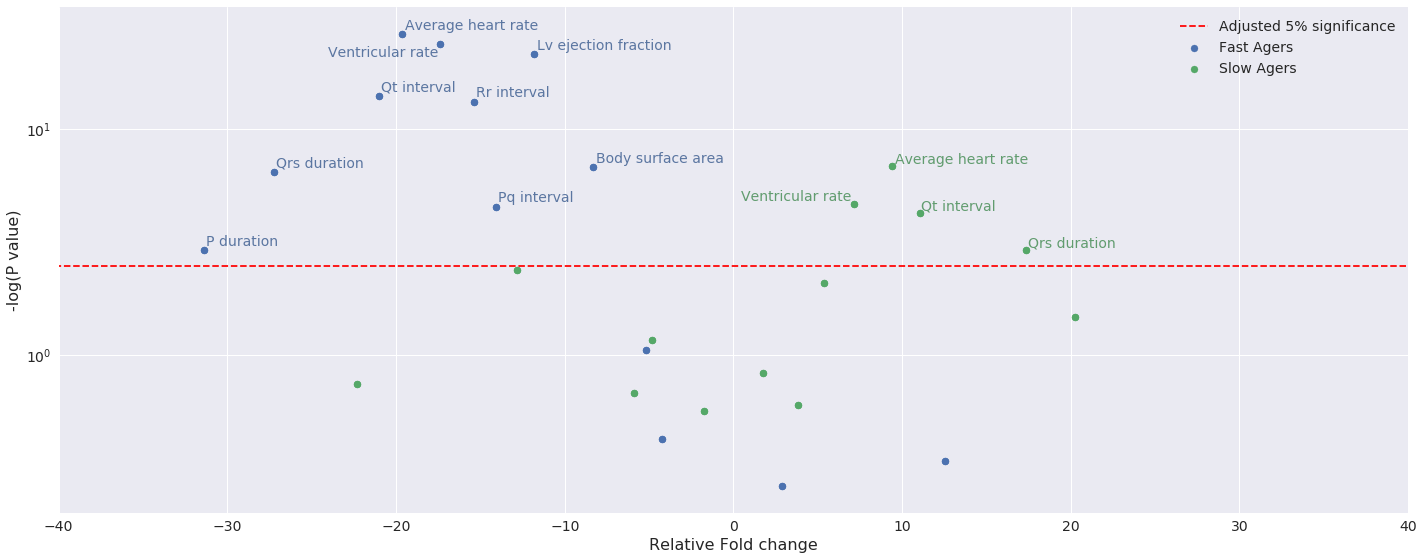

In [235]:
TICKS = 14
LEGEND = 14
AXES = 16
TITLE = 18

plt.rc('font', size=TICKS)          # controls default text sizes
plt.rc('axes', titlesize=AXES)     # fontsize of the axes title
plt.rc('axes', labelsize=AXES)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICKS)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICKS)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND)    # legend fontsize
plt.rc('figure', titlesize=TITLE)
fig, ax1 = plt.subplots(1,1,figsize=(20,8))

typeI_err_corr =-np.log10( 0.05 / p_val.shape[0])
ax1.scatter(mean_diff['Accelerated Agers'], p_val['Accelerated Agers'],
            color= sns.color_palette()[0], label='Fast Agers')
ax1.scatter(mean_diff['Slow Agers'], p_val['Slow Agers'],
            color= sns.color_palette()[1], label= 'Slow Agers')

boundaries= np.max([np.max(abs(mean_diff['Slow Agers'])),
                   np.max(abs(mean_diff['Accelerated Agers']))])

ax1.plot([2-boundaries, boundaries],
         [typeI_err_corr, typeI_err_corr],
          'r--', label= 'Adjusted 5% significance')

ax1.set_yscale('log')
#ax1.set_xlim([-np.max(abs(df_cvds_res['Fold_change'])), np.max(abs(df_cvds_res['Fold_change']))])
ax1.set_ylabel('-log(P value)')
ax1.set_xlabel('Prevalance difference')
ax1.set_xlim([-40,40])

texts =[] 
for pathology in p_val.index:
    if p_val.loc[pathology,'Accelerated Agers'] > typeI_err_corr:
        texts.append(ax1.annotate(pathology,  
                 (mean_diff.loc[pathology,'Accelerated Agers'], p_val.loc[pathology,'Accelerated Agers']),
                                 color=sns.color_palette(desat=0.7)[0],
                                 fontsize=14))

adjust_text(texts, only_move={'points':'y', 'text':'xy'})

for pathology in p_val.index:
    if p_val.loc[pathology,'Slow Agers'] > typeI_err_corr:
        texts.append(ax1.annotate(pathology, 
                 (mean_diff.loc[pathology,'Slow Agers'], p_val.loc[pathology,'Slow Agers']), 
                                  color=sns.color_palette(desat=0.7)[1],
                                 fontsize=14))

adjust_text(texts, only_move={'points':'x', 'text':'x'})
    

ax1.scatter(mean_diff['Accelerated Agers'], p_val['Accelerated Agers'],
            color= sns.color_palette()[0])
ax1.scatter(mean_diff['Slow Agers'], p_val['Slow Agers'],
            color= sns.color_palette()[1])
ax1.set_yscale('log')
ax1.set_ylabel('-log(P value)')
ax1.set_xlabel('Relative Fold change')
ax1.legend()
fig.tight_layout()
fig.show()

In [236]:
mean_diff

Accelerated Agers  Slow Agers
Lv ejection fraction            -11.847265    1.728946
Lv end diastolic volume           2.895369  -12.825222
Lv end systolic volume           -5.194436   -4.838835
Lv stroke volume                 71.374713  -80.429145
Cardiac output                   12.525152  -22.331900
Cardiac index                   220.101747 -227.197497
Average heart rate              -19.629133    9.411333
Body surface area                -8.341153   -1.735324
Ventricular rate                -17.364078    7.122024
P duration                      -31.369450   20.236421
Pp interval                      -4.220515   -5.864978
Pq interval                     -14.047111    3.834427
Qrs duration                    -27.215388   17.320888
Qt interval                     -20.987548   11.033709
Rr interval                     -15.362179    5.354740